# Preprocessing

In [1]:
# Import nltk files
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
import os
import re
import csv
import json
import time
import requests
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import svm
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.metrics import Recall, BinaryAccuracy, Precision
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

# !pip install tensorflow==2.11.0
# !pip install tensorflow_text==2.11.0
# !pip install tf-models-official

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
# Import initial files
df_pure = pd.read_csv('pure.csv', header=0)
df_promise = pd.read_csv('promise.csv')
df_sec_init = pd.read_csv('issues_sec_with_desc.csv', sep=';')
df_nonsec_init = pd.read_csv('issues_nonsec_with_desc.csv', sep=';')

In [5]:
# Print shapes of datasets
print("PURE:", df_pure.shape)
print("PROMISE:", df_promise.shape)
print("GitHub security:", df_sec_init.shape)
print("GitHub non-security:", df_nonsec_init.shape)

PURE: (6308, 8)
PROMISE: (2322, 2)
GitHub security: (6069, 6)
GitHub non-security: (9874, 6)


## Create test issues

In [6]:
i = df_sec_init[df_sec_init["issue_title"] == 'Security issue: Data representation leaks because validation takes places before authentication'].index
print('Index =', i[0])
sec_sample_issue = df_sec_init.iloc[i[0]]
print('Issue = "', sec_sample_issue["issue_title"], '"')

print('\nSize before drop =', df_sec_init.shape)
df_sec_init = df_sec_init.drop(i)
print('\nSize after drop =', df_sec_init.shape)

Index = 6068
Issue = " Security issue: Data representation leaks because validation takes places before authentication "

Size before drop = (6069, 6)

Size after drop = (6068, 6)


In [7]:
print(sec_sample_issue)

repository                                                   dropwizard
repository_api_url    https://api.github.com/repos/dropwizard/dropwi...
issue_title           Security issue: Data representation leaks beca...
labels                                                     ['security']
issue_api_url         https://api.github.com/repos/dropwizard/dropwi...
description           'Reported this on the mailing list and was ask...
Name: 6068, dtype: object


In [8]:
i = df_nonsec_init[df_nonsec_init["issue_title"] == 'Add stack trace logging for slow requests'].index
print('Index =', i[0])
nonsec_sample_issue = df_nonsec_init.iloc[i[0]]
print('Issue = "', nonsec_sample_issue["issue_title"], '"')

print('\nSize before drop =', df_nonsec_init.shape)
df_nonsec_init = df_nonsec_init.drop(i)
print('\nSize after drop =', df_nonsec_init.shape)

Index = 5829
Issue = " Add stack trace logging for slow requests "

Size before drop = (9874, 6)

Size after drop = (9873, 6)


In [9]:
nonsec_sample_issue

repository                                                   dropwizard
repository_api_url    https://api.github.com/repos/dropwizard/dropwi...
issue_title                   Add stack trace logging for slow requests
labels                                                      ['feature']
issue_api_url         https://api.github.com/repos/dropwizard/dropwi...
description           "Steal heavily from [dogslow](https://bitbucke...
Name: 5829, dtype: object

## PURE dataset

In [10]:
df_pure.isna().sum()

Initial number           0
Requirement              0
Context (Keywords)       3
Name of Doc              1
Sec / Not Sec            1
Labeled by               0
Comments              6197
Unnamed: 7            6305
dtype: int64

In [11]:
df_pure = df_pure.rename(columns={"Sec / Not Sec": 'Label', 'Requirement': 'Text'})
df_pure = df_pure[["Text", "Label"]]
df_pure = df_pure.dropna()
df_pure["Label"] = df_pure["Label"].astype(int)
df_pure.head()

<ipython-input-11-6afacfff6184>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pure["Label"] = df_pure["Label"].astype(int)


,Text,Label
0,If the object is in a locked state the user s...,0
1,It may point to soil type or local cultural p...,0
2,The system shall provide a list of all parame...,0
3,The system shall support a hierarchical repre...,0
4,The system shall support the definition of ro...,1


In [12]:
df_pure.isna().sum()

Text     0
Label    0
dtype: int64

In [13]:
# Preprocess PURE dataset

print("Before:", df_pure.loc[1]['Text'])

# Step 1 - lowercase
df_pure['Text_clean'] = df_pure['Text'].str.lower()

# Step 2 - remove urls
df_pure['Text_clean'] = df_pure['Text_clean'].apply(lambda x: re.sub(r'http:/\S+','link', x))
df_pure['Text_clean'] = df_pure['Text_clean'].apply(lambda x: re.sub(r'https:/\S+','link', x))

# Step 3 - remove numbers and other
df_pure['Text_clean'] = df_pure['Text_clean'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))

# Step 4 - remove multi-spaces
df_pure['Text_clean'] = df_pure['Text_clean'].apply(lambda x: re.sub(' +', ' ', x))

# Step 5 - tokenization
df_pure['Text_clean'] = df_pure['Text_clean'].apply(lambda x: word_tokenize(x))

# Step 6 - remove short(==1) words
df_pure['Text_clean'] = df_pure['Text_clean'].apply(lambda x: [i for i in x if len(i)>1])

# Step 7 (superclean) - remove stopwords
stop_words = set(stopwords.words("english"))
df_pure['Text_superclean'] = df_pure['Text_clean'].apply(lambda x: [i for i in x if i not in stop_words])

# Step 8 (superclean) - Lemmatization
lemma = WordNetLemmatizer()
df_pure['Text_superclean'] = df_pure['Text_superclean'].apply(lambda x: [lemma.lemmatize(word=i,pos='v') for i in x])

# Step 9 (superclean) - remove short(<=2) words
df_pure['Text_superclean'] = df_pure['Text_superclean'].apply(lambda x: [i for i in x if len(i)>2])

# Final Step - convert to string
df_pure['Text_clean'] = df_pure['Text_clean'].apply(lambda x: " ".join(x))
df_pure['Text_superclean'] = df_pure['Text_superclean'].apply(lambda x: " ".join(x))

print('After Text_clean:', df_pure.loc[1]['Text_clean'])
print('After Text_superclean:', df_pure.loc[1]['Text_superclean'])

Before:  It may point to soil type or local cultural practice problems.
After Text_clean: it may point to soil type or local cultural practice problems
After Text_superclean: may point soil type local cultural practice problems


In [14]:
df_pure.head()

,Text,Label,Text_clean,Text_superclean
0,If the object is in a locked state the user s...,0,if the object is in locked state the user shal...,object lock state user shall prompt delete pro...
1,It may point to soil type or local cultural p...,0,it may point to soil type or local cultural pr...,may point soil type local cultural practice pr...
2,The system shall provide a list of all parame...,0,the system shall provide list of all parameter...,system shall provide list parameters category
3,The system shall support a hierarchical repre...,0,the system shall support hierarchical represen...,system shall support hierarchical representati...
4,The system shall support the definition of ro...,1,the system shall support the definition of roles,system shall support definition roles


In [15]:
# Balance PURE dataset
print("Before balancing PURE dataset:")
print(df_pure["Label"].value_counts())

df_pure_nonsec = df_pure[df_pure["Label"]==0].sample(n=df_pure[df_pure["Label"]==1].shape[0], random_state=42).reset_index(drop=True)
df_pure_sec = df_pure[df_pure["Label"]==1].reset_index(drop=True)

df_pure_superclean = pd.concat([df_pure_sec, df_pure_nonsec])[["Text_superclean", "Label"]]
df_pure_superclean = df_pure_superclean.sample(n=df_pure_superclean.shape[0], random_state=42).reset_index(drop=True)

df_pure = pd.concat([df_pure_sec, df_pure_nonsec])[["Text_clean", "Label"]]
df_pure = df_pure.sample(n=df_pure.shape[0], random_state=42).reset_index(drop=True)

print("\nAfter balancing PURE dataset:")
print(df_pure["Label"].value_counts())

Before balancing PURE dataset:
0    5691
1     616
Name: Label, dtype: int64

After balancing PURE dataset:
1    616
0    616
Name: Label, dtype: int64


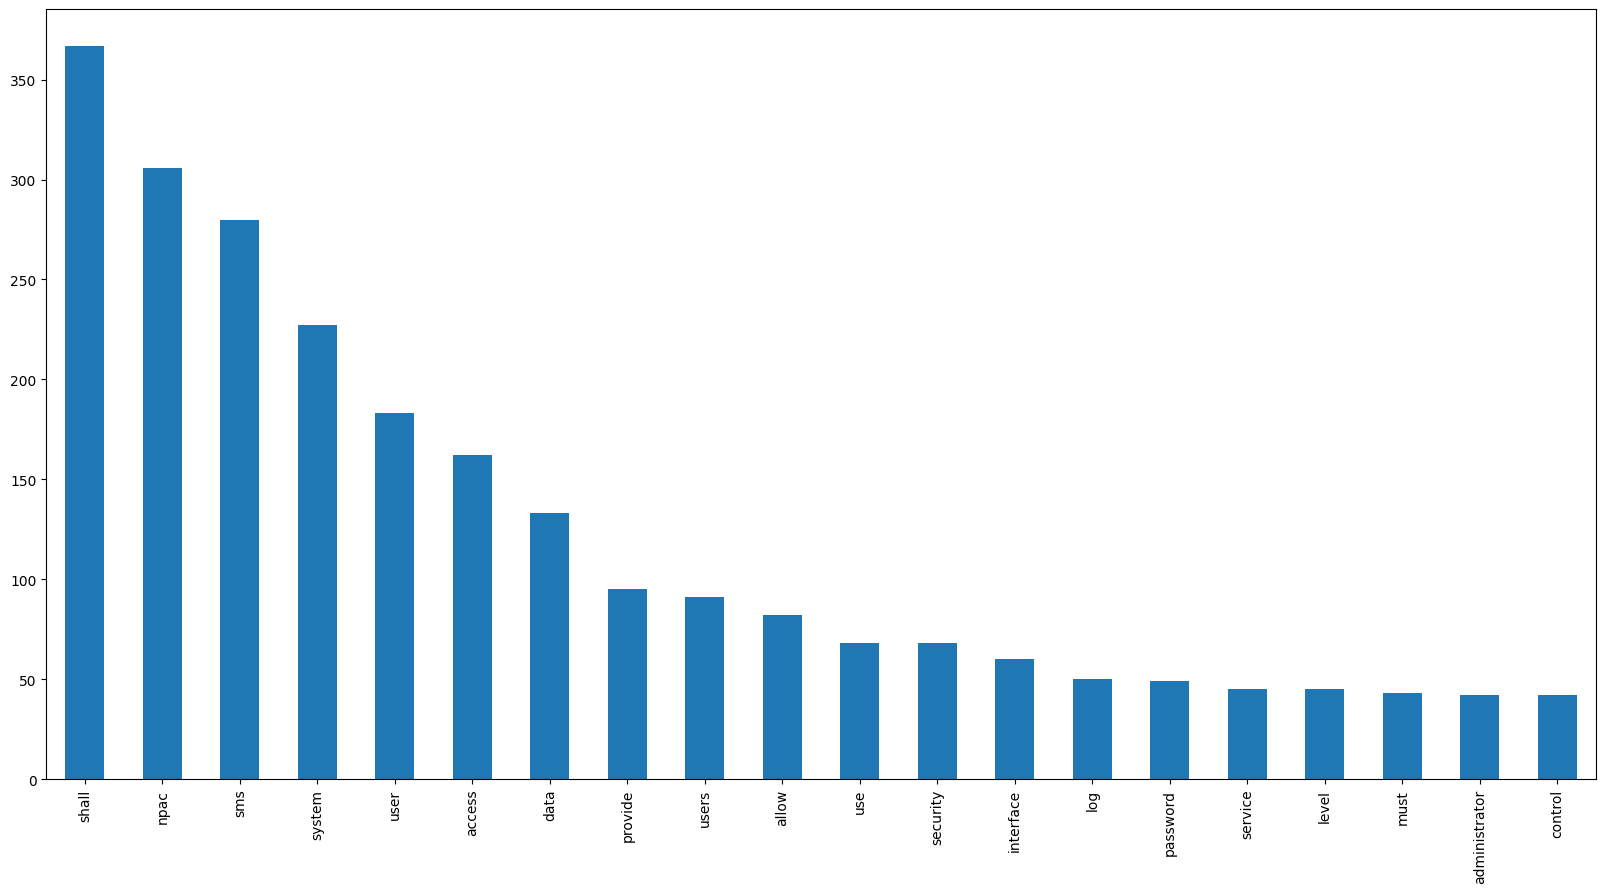

shall            367
npac             306
sms              280
system           227
user             183
access           162
data             133
provide           95
users             91
allow             82
use               68
security          68
interface         60
log               50
password          49
service           45
level             45
must              43
administrator     42
control           42
dtype: int64


In [16]:
# Plot graph of top words in PURE security
plt.figure(figsize=(20,10))
visual = pd.Series(" ".join([i for i in df_pure_superclean[df_pure_superclean["Label"]==1]['Text_superclean']]).split())
visual.value_counts().head(20).plot(kind='bar')
plt.show()
print(visual.value_counts().head(20))

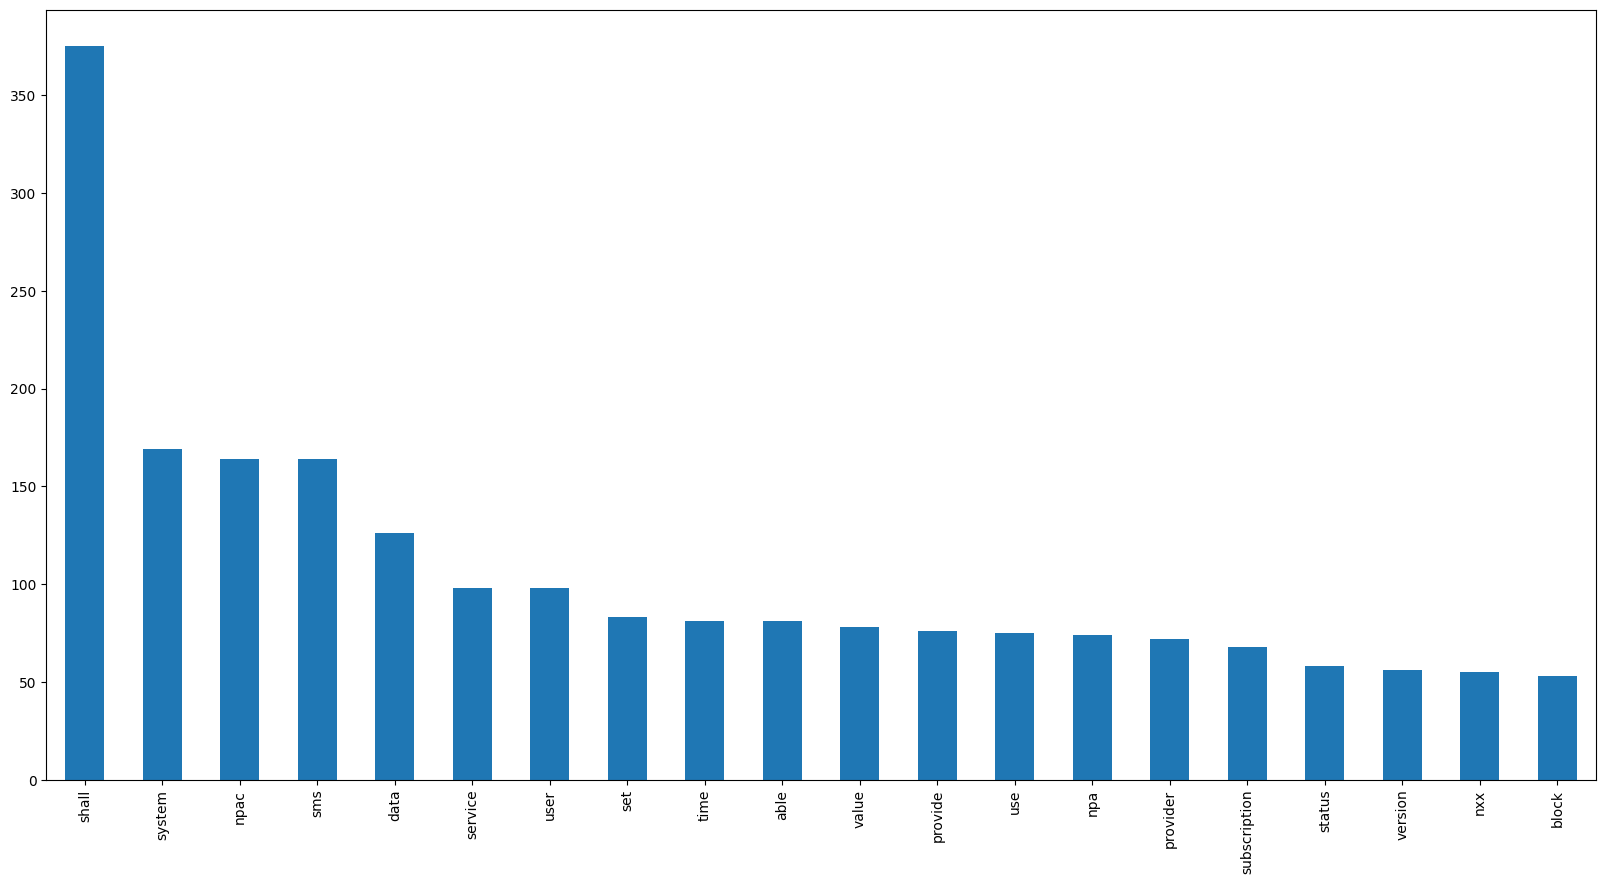

shall           375
system          169
npac            164
sms             164
data            126
service          98
user             98
set              83
time             81
able             81
value            78
provide          76
use              75
npa              74
provider         72
subscription     68
status           58
version          56
nxx              55
block            53
dtype: int64


In [17]:
# Plot graph of top words in PURE non-security
plt.figure(figsize=(20,10))
visual = pd.Series(" ".join([i for i in df_pure_superclean[df_pure_superclean["Label"]==0]['Text_superclean']]).split())
visual.value_counts().head(20).plot(kind='bar')
plt.show()
print(visual.value_counts().head(20))

## PROMISE dataset

In [18]:
df_promise.isna().sum()

Text     0
Label    0
dtype: int64

In [19]:
df_promise['Label'] = df_promise['Label'].replace(['nonsec','sec', 'xyz'],[0, 1, 1])
df_promise.head()

,Text,Label
0,All applications under the GlobalPlatform shal...,1
1,The run time environment shall be responsible ...,1
2,The run time environment shall responsible to ...,0
3,Security domain shall ensure complete seperati...,1
4,"""Security Domains shall support security servi...",1


In [20]:
# Preprocess PROMISE dataset

print("Before:", df_promise.loc[1]['Text'])

# Step 1 - lowercase
df_promise['Text_clean'] = df_promise['Text'].str.lower()

# Step 2 - remove urls
df_promise['Text_clean'] = df_promise['Text_clean'].apply(lambda x: re.sub(r'http:/\S+','link', x))
df_promise['Text_clean'] = df_promise['Text_clean'].apply(lambda x: re.sub(r'https:/\S+','link', x))

# Step 3 - remove numbers and other
df_promise['Text_clean'] = df_promise['Text_clean'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))

# Step 4 - remove multi-spaces
df_promise['Text_clean'] = df_promise['Text_clean'].apply(lambda x: re.sub(' +', ' ', x))

# Step 5 - tokenization
df_promise['Text_clean'] = df_promise['Text_clean'].apply(lambda x: word_tokenize(x))

# Step 6 - remove short(==1) words
df_promise['Text_clean'] = df_promise['Text_clean'].apply(lambda x: [i for i in x if len(i)>1])

# Step 7 (superclean) - remove stopwords
stop_words = set(stopwords.words("english"))
df_promise['Text_superclean'] = df_promise['Text_clean'].apply(lambda x: [i for i in x if i not in stop_words])

# Step 8 (superclean) - Lemmatization
lemma = WordNetLemmatizer()
df_promise['Text_superclean'] = df_promise['Text_superclean'].apply(lambda x: [lemma.lemmatize(word=i,pos='v') for i in x])

# Step 9 (superclean) - remove short(<=2) words
df_promise['Text_superclean'] = df_promise['Text_superclean'].apply(lambda x: [i for i in x if len(i)>2])

# Final Step - convert to string
df_promise['Text_clean'] = df_promise['Text_clean'].apply(lambda x: " ".join(x))
df_promise['Text_superclean'] = df_promise['Text_superclean'].apply(lambda x: " ".join(x))

print('After Text_clean:', df_promise.loc[1]['Text_clean'])
print('After Text_superclean:', df_promise.loc[1]['Text_superclean'])

Before: The run time environment shall be responsible to separate secure storage for the application code and data
After Text_clean: the run time environment shall be responsible to separate secure storage for the application code and data
After Text_superclean: run time environment shall responsible separate secure storage application code data


In [21]:
df_promise.head()

,Text,Label,Text_clean,Text_superclean
0,All applications under the GlobalPlatform shal...,1,all applications under the globalplatform shal...,applications globalplatform shall implement ha...
1,The run time environment shall be responsible ...,1,the run time environment shall be responsible ...,run time environment shall responsible separat...
2,The run time environment shall responsible to ...,0,the run time environment shall responsible to ...,run time environment shall responsible establi...
3,Security domain shall ensure complete seperati...,1,security domain shall ensure complete seperati...,security domain shall ensure complete seperati...
4,"""Security Domains shall support security servi...",1,security domains shall support security servic...,security domains shall support security servic...


In [22]:
# Balance PROMISE dataset
print("Before balancing PROMISE dataset:")
print(df_promise["Label"].value_counts())

df_promise_nonsec = df_promise[df_promise["Label"]==0].sample(n=df_promise[df_promise["Label"]==1].shape[0], random_state=42).reset_index(drop=True)
df_promise_sec = df_promise[df_promise["Label"]==1].reset_index(drop=True)

df_promise_superclean = pd.concat([df_promise_sec, df_promise_nonsec])[["Text_superclean", "Label"]]
df_promise_superclean = df_promise_superclean.sample(n=df_promise_superclean.shape[0], random_state=42).reset_index(drop=True)

df_promise = pd.concat([df_promise_sec, df_promise_nonsec])[["Text_clean", "Label"]]
df_promise = df_promise.sample(n=df_promise.shape[0], random_state=42).reset_index(drop=True)

print("\nAfter balancing PROMISE dataset:")
print(df_promise["Label"].value_counts())

Before balancing PROMISE dataset:
0    1518
1     804
Name: Label, dtype: int64

After balancing PROMISE dataset:
1    804
0    804
Name: Label, dtype: int64


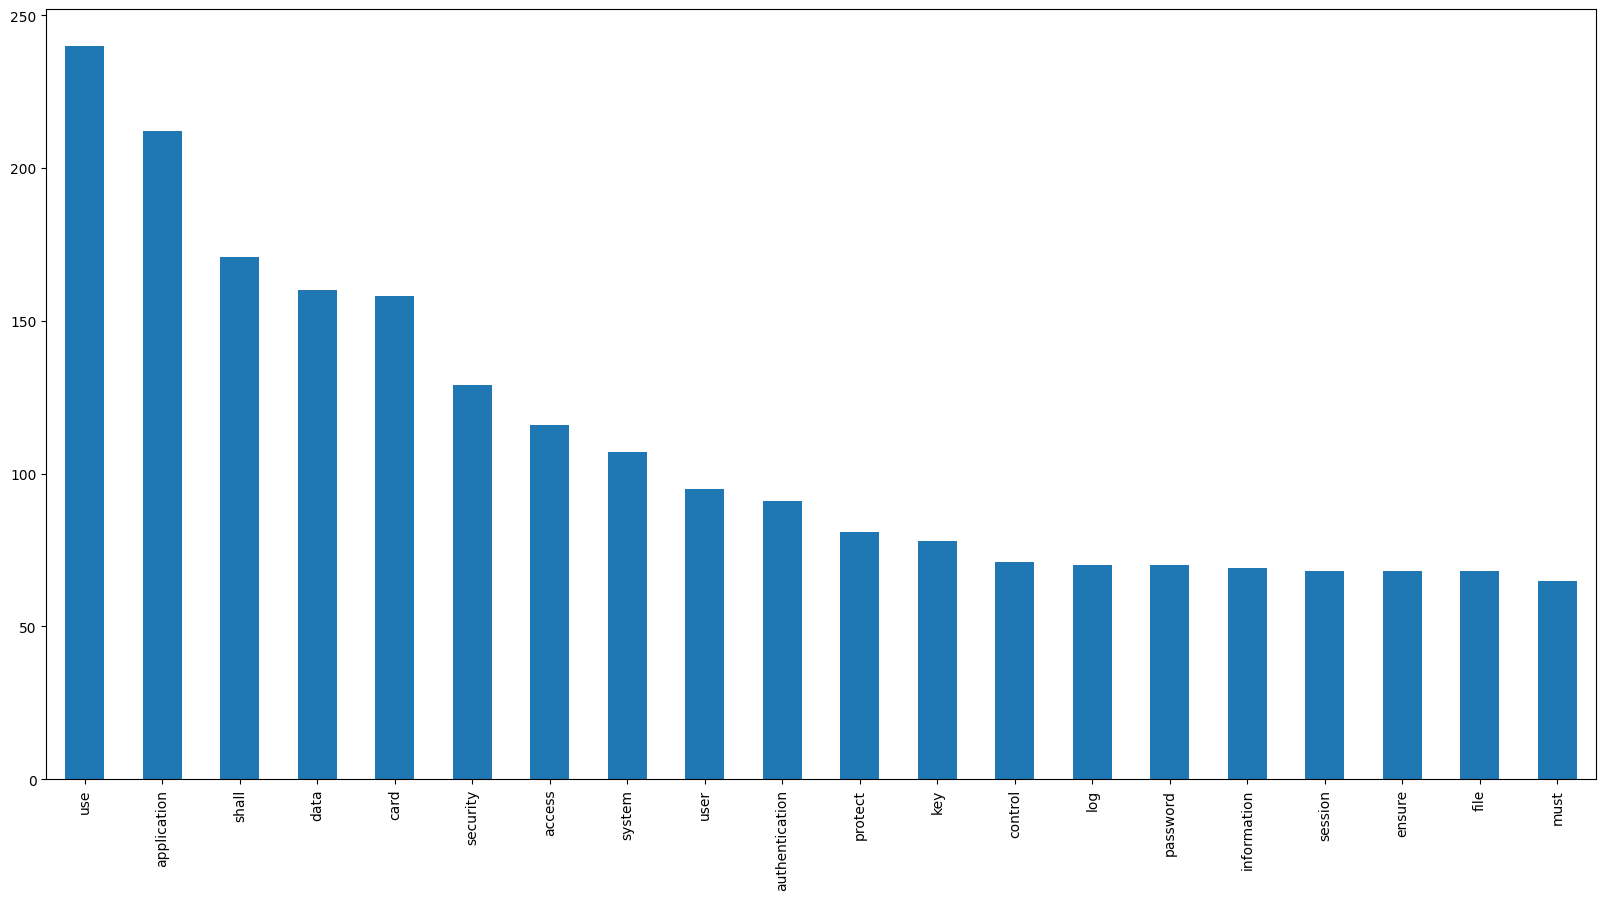

use               240
application       212
shall             171
data              160
card              158
security          129
access            116
system            107
user               95
authentication     91
protect            81
key                78
control            71
log                70
password           70
information        69
session            68
ensure             68
file               68
must               65
dtype: int64


In [23]:

# Plot graph of top words in PROMISE security
plt.figure(figsize=(20,10))
visual = pd.Series(" ".join([i for i in df_promise_superclean[df_promise_superclean["Label"]==1]['Text_superclean']]).split())
visual.value_counts().head(20).plot(kind='bar')
plt.show()
print(visual.value_counts().head(20))

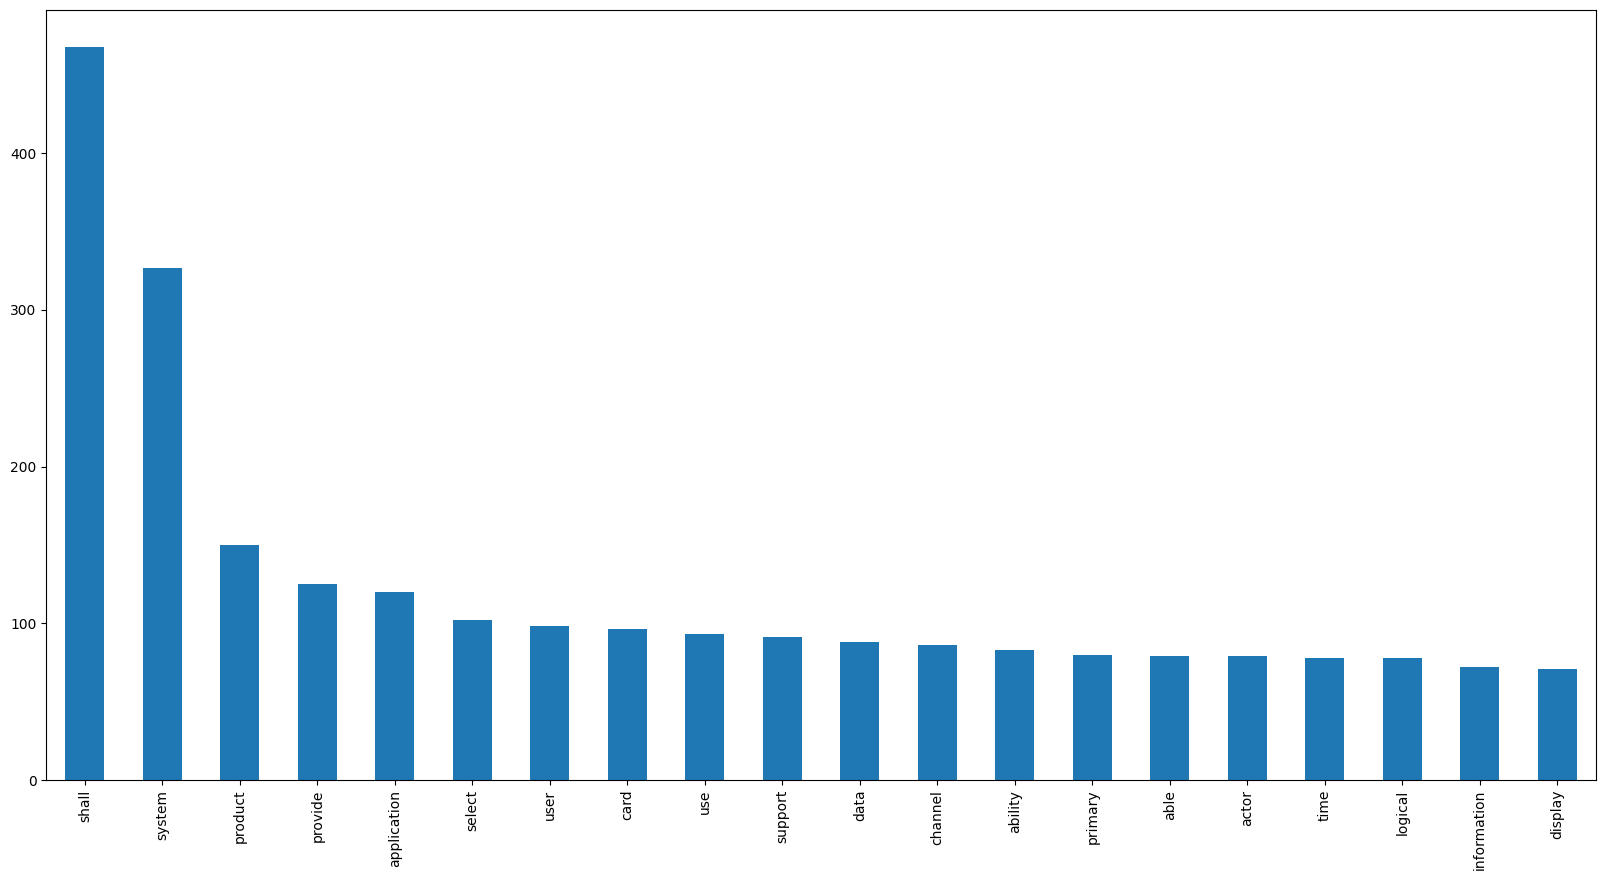

shall          468
system         327
product        150
provide        125
application    120
select         102
user            98
card            96
use             93
support         91
data            88
channel         86
ability         83
primary         80
able            79
actor           79
time            78
logical         78
information     72
display         71
dtype: int64


In [24]:
# Plot graph of top words in PROMISE non-security
plt.figure(figsize=(20,10))
visual = pd.Series(" ".join([i for i in df_promise_superclean[df_promise_superclean["Label"]==0]['Text_superclean']]).split())
visual.value_counts().head(20).plot(kind='bar')
plt.show()
print(visual.value_counts().head(20))

## GitHub dataset

### Security dataset

In [25]:
df_sec_init.isna().sum()

repository            0
repository_api_url    0
issue_title           0
labels                0
issue_api_url         0
description           0
dtype: int64

In [26]:
# Combine title and description into one text
df_sec_init['description'] = df_sec_init[['issue_title', 'description']].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

# Set label: 1 - security
df_sec_init['label'] = 1

In [27]:
df_sec_init.head()

,repository,repository_api_url,issue_title,labels,issue_api_url,description,label
0,react,https://api.github.com/repos/facebook/react,Security: 4 Electron (react-devtools dep) secu...,"['component: developer tools', 'good first iss...",https://api.github.com/repos/facebook/react/is...,Security: 4 Electron (react-devtools dep) secu...,1
1,ohmyzsh,https://api.github.com/repos/ohmyzsh/ohmyzsh,Report for vulnerabilities in Oh My Zsh (2021-...,"['security', 'area: meta']",https://api.github.com/repos/ohmyzsh/ohmyzsh/i...,Report for vulnerabilities in Oh My Zsh (2021-...,1
2,ohmyzsh,https://api.github.com/repos/ohmyzsh/ohmyzsh,Discussion: vulnerabilities in Oh My Zsh (2021...,"['discussion', 'security']",https://api.github.com/repos/ohmyzsh/ohmyzsh/i...,Discussion: vulnerabilities in Oh My Zsh (2021...,1
3,ohmyzsh,https://api.github.com/repos/ohmyzsh/ohmyzsh,Trying to get in touch regarding a security issue,"['security', 'area: meta']",https://api.github.com/repos/ohmyzsh/ohmyzsh/i...,Trying to get in touch regarding a security is...,1
4,ohmyzsh,https://api.github.com/repos/ohmyzsh/ohmyzsh,module_init extra output (pid?) on every new t...,"['resolution: not our issue', 'security']",https://api.github.com/repos/ohmyzsh/ohmyzsh/i...,module_init extra output (pid?) on every new t...,1


In [28]:
# Preprocess security dataset

print("Before:", df_sec_init.loc[149]['issue_title'])

# Step 1 - lowercase
df_sec_init['issue_title_clean'] = df_sec_init['issue_title'].str.lower()
df_sec_init['description_clean'] = df_sec_init['description'].str.lower()

# Step 2 - remove urls
df_sec_init['issue_title_clean'] = df_sec_init['issue_title_clean'].apply(lambda x: re.sub(r'http:/\S+','link', x))
df_sec_init['issue_title_clean'] = df_sec_init['issue_title_clean'].apply(lambda x: re.sub(r'https:/\S+','link', x))
df_sec_init['description_clean'] = df_sec_init['description_clean'].apply(lambda x: re.sub(r'http:/\S+','link', x))
df_sec_init['description_clean'] = df_sec_init['description_clean'].apply(lambda x: re.sub(r'https:/\S+','link', x))

# Step 3 - remove numbers and other
df_sec_init['issue_title_clean'] = df_sec_init['issue_title_clean'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))
df_sec_init['description_clean'] = df_sec_init['description_clean'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))

# Step 4 - remove multi-spaces
df_sec_init['issue_title_clean'] = df_sec_init['issue_title_clean'].apply(lambda x: re.sub(' +', ' ', x))
df_sec_init['description_clean'] = df_sec_init['description_clean'].apply(lambda x: re.sub(' +', ' ', x))

# Step 5 - tokenization
df_sec_init['issue_title_clean'] = df_sec_init['issue_title_clean'].apply(lambda x: word_tokenize(x))
df_sec_init['description_clean'] = df_sec_init['description_clean'].apply(lambda x: word_tokenize(x))

# Step 6 - remove short(==1) words
df_sec_init['issue_title_clean'] = df_sec_init['issue_title_clean'].apply(lambda x: [i for i in x if len(i)>1])
df_sec_init['description_clean'] = df_sec_init['description_clean'].apply(lambda x: [i for i in x if len(i)>1])

# Step 7 (superclean) - remove stopwords
stop_words = set(stopwords.words("english"))
df_sec_init['issue_title_superclean'] = df_sec_init['issue_title_clean'].apply(lambda x: [i for i in x if i not in stop_words])
df_sec_init['description_superclean'] = df_sec_init['description_clean'].apply(lambda x: [i for i in x if i not in stop_words])

# Step 8 (superclean) - Lemmatization
lemma = WordNetLemmatizer()
df_sec_init['issue_title_superclean'] = df_sec_init['issue_title_superclean'].apply(lambda x: [lemma.lemmatize(word=i,pos='v') for i in x])
df_sec_init['description_superclean'] = df_sec_init['description_superclean'].apply(lambda x: [lemma.lemmatize(word=i,pos='v') for i in x])

# Step 9 (superclean) - remove short(<=2) words
df_sec_init['issue_title_superclean'] = df_sec_init['issue_title_superclean'].apply(lambda x: [i for i in x if len(i)>2])
df_sec_init['description_superclean'] = df_sec_init['description_superclean'].apply(lambda x: [i for i in x if len(i)>2])

# Final Step - convert to string
df_sec_init['issue_title_superclean'] = df_sec_init['issue_title_superclean'].apply(lambda x: " ".join(x))
df_sec_init['issue_title_clean'] = df_sec_init['issue_title_clean'].apply(lambda x: " ".join(x))

df_sec_init['description_superclean'] = df_sec_init['description_superclean'].apply(lambda x: " ".join(x))
df_sec_init['description_clean'] = df_sec_init['description_clean'].apply(lambda x: " ".join(x))

print('After issue_title_clean:', df_sec_init.loc[149]['issue_title_clean'])
print('After issue_title_superclean:', df_sec_init.loc[149]['issue_title_superclean'])

Before: x/build/cmd/coordinator: http://farmer.golang.org should redirect to https
After issue_title_clean: build cmd coordinator link should redirect to https
After issue_title_superclean: build cmd coordinator link redirect https


In [29]:
df_sec_init.head()

,repository,repository_api_url,issue_title,labels,issue_api_url,description,label,issue_title_clean,description_clean,issue_title_superclean,description_superclean
0,react,https://api.github.com/repos/facebook/react,Security: 4 Electron (react-devtools dep) secu...,"['component: developer tools', 'good first iss...",https://api.github.com/repos/facebook/react/is...,Security: 4 Electron (react-devtools dep) secu...,1,security electron react devtools dep security ...,security electron react devtools dep security ...,security electron react devtools dep security ...,security electron react devtools dep security ...
1,ohmyzsh,https://api.github.com/repos/ohmyzsh/ohmyzsh,Report for vulnerabilities in Oh My Zsh (2021-...,"['security', 'area: meta']",https://api.github.com/repos/ohmyzsh/ohmyzsh/i...,Report for vulnerabilities in Oh My Zsh (2021-...,1,report for vulnerabilities in oh my zsh,report for vulnerabilities in oh my zsh days a...,report vulnerabilities zsh,report vulnerabilities zsh days ago link infor...
2,ohmyzsh,https://api.github.com/repos/ohmyzsh/ohmyzsh,Discussion: vulnerabilities in Oh My Zsh (2021...,"['discussion', 'security']",https://api.github.com/repos/ohmyzsh/ohmyzsh/i...,Discussion: vulnerabilities in Oh My Zsh (2021...,1,discussion vulnerabilities in oh my zsh,discussion vulnerabilities in oh my zsh feel f...,discussion vulnerabilities zsh,discussion vulnerabilities zsh feel free ask q...
3,ohmyzsh,https://api.github.com/repos/ohmyzsh/ohmyzsh,Trying to get in touch regarding a security issue,"['security', 'area: meta']",https://api.github.com/repos/ohmyzsh/ohmyzsh/i...,Trying to get in touch regarding a security is...,1,trying to get in touch regarding security issue,trying to get in touch regarding security issu...,try get touch regard security issue,try get touch regard security issue hey belong...
4,ohmyzsh,https://api.github.com/repos/ohmyzsh/ohmyzsh,module_init extra output (pid?) on every new t...,"['resolution: not our issue', 'security']",https://api.github.com/repos/ohmyzsh/ohmyzsh/i...,module_init extra output (pid?) on every new t...,1,module init extra output pid on every new term...,module init extra output pid on every new term...,module init extra output pid every new terminal,module init extra output pid every new termina...


### Non-security dataset

In [30]:
df_nonsec_init.isna().sum()

repository            0
repository_api_url    0
issue_title           0
labels                0
issue_api_url         0
description           0
dtype: int64

In [31]:
# Combine title and description into one text
df_nonsec_init['description'] = df_nonsec_init[['issue_title', 'description']].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

# Set label: 0 - nonsecurity
df_nonsec_init['label'] = 0

In [32]:
df_nonsec_init.head()

,repository,repository_api_url,issue_title,labels,issue_api_url,description,label
0,underscore,https://api.github.com/repos/jashkenas/underscore,single quotes in template cause parse error,"['fixed', 'bug']",https://api.github.com/repos/jashkenas/undersc...,single quotes in template cause parse error 'I...,0
1,tensorflow,https://api.github.com/repos/tensorflow/tensor...,Possible bug with session handle as feed dict ...,"['stat:awaiting tensorflower', 'type:bug', 'co...",https://api.github.com/repos/tensorflow/tensor...,Possible bug with session handle as feed dict ...,0
2,ansible,https://api.github.com/repos/ansible/ansible,core 2.13.4 breaking change in apt only_upgrade,"['module', 'support:core', 'bug', 'has_pr', 'a...",https://api.github.com/repos/ansible/ansible/i...,core 2.13.4 breaking change in apt only_upgrad...,0
3,vscode,https://api.github.com/repos/microsoft/vscode,Debugging yeoman generator doesn't launch on W...,['debug'],https://api.github.com/repos/microsoft/vscode/...,Debugging yeoman generator doesn't launch on W...,0
4,metabase,https://api.github.com/repos/metabase/metabase,Toggle in mobile when setting up Metabase gets...,"['type:bug', '.css', 'priority:p3', 'client:mo...",https://api.github.com/repos/metabase/metabase...,Toggle in mobile when setting up Metabase gets...,0


In [33]:
# Preprocess security dataset

print("Before:", df_nonsec_init.loc[15]['issue_title'])

# Step 1 - lowercase
df_nonsec_init['issue_title_clean'] = df_nonsec_init['issue_title'].str.lower()
df_nonsec_init['description_clean'] = df_nonsec_init['description'].str.lower()

# Ster 2 - remove urls
df_nonsec_init['issue_title_clean'] = df_nonsec_init['issue_title_clean'].apply(lambda x: re.sub(r'http:/\S+','link', x))
df_nonsec_init['issue_title_clean'] = df_nonsec_init['issue_title_clean'].apply(lambda x: re.sub(r'https:/\S+','link', x))
df_nonsec_init['description_clean'] = df_nonsec_init['description_clean'].apply(lambda x: re.sub(r'http:/\S+','link', x))
df_nonsec_init['description_clean'] = df_nonsec_init['description_clean'].apply(lambda x: re.sub(r'https:/\S+','link', x))

# Step 3 - remove numbers and other
df_nonsec_init['issue_title_clean'] = df_nonsec_init['issue_title_clean'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))
df_nonsec_init['description_clean'] = df_nonsec_init['description_clean'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))
# Step 4 - remove multi-spaces
df_nonsec_init['issue_title_clean'] = df_nonsec_init['issue_title_clean'].apply(lambda x: re.sub(' +', ' ', x))
df_nonsec_init['description_clean'] = df_nonsec_init['description_clean'].apply(lambda x: re.sub(' +', ' ', x))

# Step 5 - tokenization
df_nonsec_init['issue_title_clean'] = df_nonsec_init['issue_title_clean'].apply(lambda x: word_tokenize(x))
df_nonsec_init['description_clean'] = df_nonsec_init['description_clean'].apply(lambda x: word_tokenize(x))

# Step 6 - remove short(==1) words
df_nonsec_init['issue_title_clean'] = df_nonsec_init['issue_title_clean'].apply(lambda x: [i for i in x if len(i)>1])
df_nonsec_init['description_clean'] = df_nonsec_init['description_clean'].apply(lambda x: [i for i in x if len(i)>1])

# Step 7 (superclean) - remove stopwords
df_nonsec_init['issue_title_superclean'] = df_nonsec_init['issue_title_clean'].apply(lambda x: [i for i in x if i not in stop_words])
df_nonsec_init['description_superclean'] = df_nonsec_init['description_clean'].apply(lambda x: [i for i in x if i not in stop_words])

# Step 8 (superclean) - Lemmatization
df_nonsec_init['issue_title_superclean'] = df_nonsec_init['issue_title_superclean'].apply(lambda x: [lemma.lemmatize(word=i,pos='v') for i in x])
df_nonsec_init['description_superclean'] = df_nonsec_init['description_superclean'].apply(lambda x: [lemma.lemmatize(word=i,pos='v') for i in x])

# Step 9 (superclean) - remove short(<=2) words
df_nonsec_init['issue_title_superclean'] = df_nonsec_init['issue_title_superclean'].apply(lambda x: [i for i in x if len(i)>2])
df_nonsec_init['description_superclean'] = df_nonsec_init['description_superclean'].apply(lambda x: [i for i in x if len(i)>2])

# Final Step - convert to string
df_nonsec_init['issue_title_superclean'] = df_nonsec_init['issue_title_superclean'].apply(lambda x: " ".join(x))
df_nonsec_init['issue_title_clean'] = df_nonsec_init['issue_title_clean'].apply(lambda x: " ".join(x))

df_nonsec_init['description_superclean'] = df_nonsec_init['description_superclean'].apply(lambda x: " ".join(x))
df_nonsec_init['description_clean'] = df_nonsec_init['description_clean'].apply(lambda x: " ".join(x))

print('After issue_title_clean:', df_nonsec_init.loc[15]['issue_title_clean'])
print('After issue_title_superclean:', df_nonsec_init.loc[15]['issue_title_superclean'])

Before: db:wipe doesn't remove migrations table from second schema
After issue_title_clean: db wipe doesn remove migrations table from second schema
After issue_title_superclean: wipe remove migrations table second schema


In [34]:
df_nonsec_init.head()

,repository,repository_api_url,issue_title,labels,issue_api_url,description,label,issue_title_clean,description_clean,issue_title_superclean,description_superclean
0,underscore,https://api.github.com/repos/jashkenas/underscore,single quotes in template cause parse error,"['fixed', 'bug']",https://api.github.com/repos/jashkenas/undersc...,single quotes in template cause parse error 'I...,0,single quotes in template cause parse error,single quotes in template cause parse error it...,single quote template cause parse error,single quote template cause parse error seem s...
1,tensorflow,https://api.github.com/repos/tensorflow/tensor...,Possible bug with session handle as feed dict ...,"['stat:awaiting tensorflower', 'type:bug', 'co...",https://api.github.com/repos/tensorflow/tensor...,Possible bug with session handle as feed dict ...,0,possible bug with session handle as feed dict ...,possible bug with session handle as feed dict ...,possible bug session handle fee dict input,possible bug session handle fee dict input ple...
2,ansible,https://api.github.com/repos/ansible/ansible,core 2.13.4 breaking change in apt only_upgrade,"['module', 'support:core', 'bug', 'has_pr', 'a...",https://api.github.com/repos/ansible/ansible/i...,core 2.13.4 breaking change in apt only_upgrad...,0,core breaking change in apt only upgrade,core breaking change in apt only upgrade summa...,core break change apt upgrade,core break change apt upgrade summary nusing a...
3,vscode,https://api.github.com/repos/microsoft/vscode,Debugging yeoman generator doesn't launch on W...,['debug'],https://api.github.com/repos/microsoft/vscode/...,Debugging yeoman generator doesn't launch on W...,0,debugging yeoman generator doesn launch on win...,debugging yeoman generator doesn launch on win...,debug yeoman generator launch windows,debug yeoman generator launch windows test nst...
4,metabase,https://api.github.com/repos/metabase/metabase,Toggle in mobile when setting up Metabase gets...,"['type:bug', '.css', 'priority:p3', 'client:mo...",https://api.github.com/repos/metabase/metabase...,Toggle in mobile when setting up Metabase gets...,0,toggle in mobile when setting up metabase gets...,toggle in mobile when setting up metabase gets...,toggle mobile set metabase get text,toggle mobile set metabase get text describe b...


### Init dataset (Security + Non-security)

In [35]:
# Combine security and non-security dataset
df_init = pd.concat([df_sec_init, df_nonsec_init]).reset_index(drop=True)
df_init = df_init.reindex(np.random.permutation(df_init.index)).reset_index(drop=True)
df_init["label"].value_counts()

0    9873
1    6068
Name: label, dtype: int64

## GitHub Dataset (with external repository)

In [36]:
# Searching for external repos. 
# We get only those which have difference smaller than 50 
# between number of issues in security and non-security issues.

diff = set(df_sec_init['repository']).intersection(set(df_nonsec_init['repository']))
s = df_sec_init[df_sec_init['repository'].isin(diff)]['repository'].value_counts()
s2 = df_nonsec_init[df_nonsec_init['repository'].isin(diff)]['repository'].value_counts()
c = 0
repos = set()
for i in zip(s.index, s.to_numpy()):
  for j in zip(s2.index, s2.to_numpy()):
    if i[0]==j[0] and (0<=j[1]-i[1]<=100 or 0<=i[1]-j[1]<=20):
      if c <= 2500:
        c+=i[1]+j[1]
        repos.add(i[0])
      else:
        break

print("Number of external issues:", c)
print("External repos:", repos)
print("Security issues:", df_sec_init[df_sec_init['repository'].isin(repos)].shape[0])
print("Non-security issues:", df_nonsec_init[df_nonsec_init['repository'].isin(repos)].shape[0])

Number of external issues: 2502
External repos: {'rancher', 'tidb', 'bitcoin-central', 'dgraph', 'openemr', 'forem', 'angular.js', 'storybook', 'cypress', 'Drawpile', 'SparkleShare', 'pyramid', 'minikube', 'netty', 'atom', 'marked', 'strapi', 'users', 'scrapy', 'chef', 'airflow', 'dropwizard', 'graylog2-web-interface', 'bleach', 'geonode', 'etcd', 'influxdb', 'graphql-engine', 'joplin', 'perkeep', 'uppy', 'redaxo', 'ricochet', 'fish-shell', 'paramiko', 'Tasmota', 'jellyfin', 'NoNonsenseForum', 'PartKeepr', 'rust', 'neovim', 'pi-hole', 'sharp', 'ThinkUp', 'firecracker', 'textpattern', 'spacemacs', 'electron', 'mosh', 'postgrest', 'photoprism', 'serverless', 'alaveteli', 'code-server', 'couchdb', 'ohmyzsh', 'vite', 'ghidra', 'Font-Awesome', 'julia', 'highlight.js', 'osquery', 'dbeaver', 'lshell', 'seltzer', 'Loris', 'tendenci', 'parcel'}
Security issues: 1054
Non-security issues: 1448


In [37]:
df_new = df_init[df_init['repository'].isin(repos)]
df_main = df_init[~df_init['repository'].isin(repos)]
df_new = df_new.sample(n=df_new.shape[0], random_state=42).reset_index(drop=True)
df_main = df_main.sample(n=df_main.shape[0], random_state=42).reset_index(drop=True)

print("Shape of dataset with external repos:", df_new.shape)
print("Shape of dataset without external repos:", df_main.shape)

Shape of dataset with external repos: (2502, 11)
Shape of dataset without external repos: (13439, 11)


In [38]:
df_main["label"].value_counts()

0    8425
1    5014
Name: label, dtype: int64

In [39]:
df_new["label"].value_counts()

0    1448
1    1054
Name: label, dtype: int64

In [40]:
# Balance main dataset
df_main_nonsec = df_main[df_main["label"]==0].sample(n=df_main[df_main["label"]==1].shape[0], random_state=42).reset_index(drop=True)
df_main_sec = df_main[df_main["label"]==1].reset_index(drop=True)
df_main = pd.concat([df_main_sec, df_main_nonsec])
df_main["label"].value_counts()

1    5014
0    5014
Name: label, dtype: int64

In [41]:
df_main_clean_title = df_main[["issue_title_clean", "label"]].sample(n=df_main.shape[0], random_state=42).reset_index(drop=True)
df_main_clean_description = df_main[["description_clean", "label"]].sample(n=df_main.shape[0], random_state=42).reset_index(drop=True)

df_main_superclean_title = df_main[["issue_title_superclean", "label"]].sample(n=df_main.shape[0], random_state=42).reset_index(drop=True)
df_main_superclean_description = df_main[["description_superclean", "label"]].sample(n=df_main.shape[0], random_state=42).reset_index(drop=True)

df_main_clean_title.head()

,issue_title_clean,label
0,set authenticodesignature unkown error,1
1,strange reliance on strict mode undefined refe...,0
2,vinyl merge hot upserts in the background,0
3,allow sketch names starting with numbers,0
4,tolowercase mustache function for search templ...,0


In [42]:
df_main["label"].value_counts()

1    5014
0    5014
Name: label, dtype: int64

In [43]:
df_new_clean_title = df_new[["issue_title_clean", "label"]].sample(n=df_new.shape[0], random_state=42).reset_index(drop=True)
df_new_clean_description = df_new[["description_clean", "label"]].sample(n=df_new.shape[0], random_state=42).reset_index(drop=True)

df_new_superclean_title = df_new[["issue_title_superclean", "label"]].sample(n=df_new.shape[0], random_state=42).reset_index(drop=True)
df_new_superclean_description = df_new[["description_superclean", "label"]].sample(n=df_new.shape[0], random_state=42).reset_index(drop=True)
df_new_clean_title.head()

,issue_title_clean,label
0,issue with userhasperms,1
1,support password validation,1
2,google node driver cluster creation option ava...,0
3,auto suggest column type on create column,0
4,postgrestogcsoperator does not allow nested json,0


In [44]:
df_new["label"].value_counts() # Do not need balansing as it used as test dataset

0    1448
1    1054
Name: label, dtype: int64

## GitHub Dataset (without external repository)

In [45]:
# Balance main dataset
print("Before balancing init dataset:")
print(df_init["label"].value_counts())

df_norm_nonsec = df_init[df_init["label"]==0].sample(n=df_init[df_init["label"]==1].shape[0], random_state=42).reset_index(drop=True)
df_norm_sec = df_init[df_init["label"]==1].reset_index(drop=True)
df_norm = pd.concat([df_norm_sec, df_norm_nonsec]).sample(n=df_norm_sec.shape[0]+df_norm_nonsec.shape[0], random_state=42).reset_index(drop=True)

print("\nAfter balancing init dataset:")
print(df_norm["label"].value_counts())

Before balancing init dataset:
0    9873
1    6068
Name: label, dtype: int64

After balancing init dataset:
1    6068
0    6068
Name: label, dtype: int64


In [46]:
df_norm.head()

,repository,repository_api_url,issue_title,labels,issue_api_url,description,label,issue_title_clean,description_clean,issue_title_superclean,description_superclean
0,redaxo,https://api.github.com/repos/redaxo/redaxo,SQL escaping in allen category/articel service...,"['enhancement', 'security', 'structure']",https://api.github.com/repos/redaxo/redaxo/iss...,SQL escaping in allen category/articel service...,1,sql escaping in allen category articel service...,sql escaping in allen category articel service...,sql escape allen category articel service klas...,sql escape allen category articel service klas...
1,youtube-dl,https://api.github.com/repos/ytdl-org/youtube-dl,Get direct link with audio/video combined,['question'],https://api.github.com/repos/ytdl-org/youtube-...,"Get direct link with audio/video combined ""I a...",0,get direct link with audio video combined,get direct link with audio video combined am u...,get direct link audio video combine,get direct link audio video combine use follow...
2,python-telegram-bot,https://api.github.com/repos/python-telegram-b...,[BUG] JobQueue produces orphan processes,['bug :bug:'],https://api.github.com/repos/python-telegram-b...,[BUG] JobQueue produces orphan processes '<!--...,0,bug jobqueue produces orphan processes,bug jobqueue produces orphan processes nthanks...,bug jobqueue produce orphan process,bug jobqueue produce orphan process nthanks re...
3,istio,https://api.github.com/repos/istio/istio,add support for remote_jwks in Request Authent...,"['kind/enhancement', 'area/security']",https://api.github.com/repos/istio/istio/issue...,add support for remote_jwks in Request Authent...,1,add support for remote jwks in request authent...,add support for remote jwks in request authent...,add support remote jwks request authentication,add support remote jwks request authentication...
4,serenity,https://api.github.com/repos/SerenityOS/serenity,Kernel: Stack Overflow in TCPSocket::send_tcp_...,['security'],https://api.github.com/repos/SerenityOS/sereni...,Kernel: Stack Overflow in TCPSocket::send_tcp_...,1,kernel stack overflow in tcpsocket send tcp pa...,kernel stack overflow in tcpsocket send tcp pa...,kernel stack overflow tcpsocket send tcp packet,kernel stack overflow tcpsocket send tcp packe...


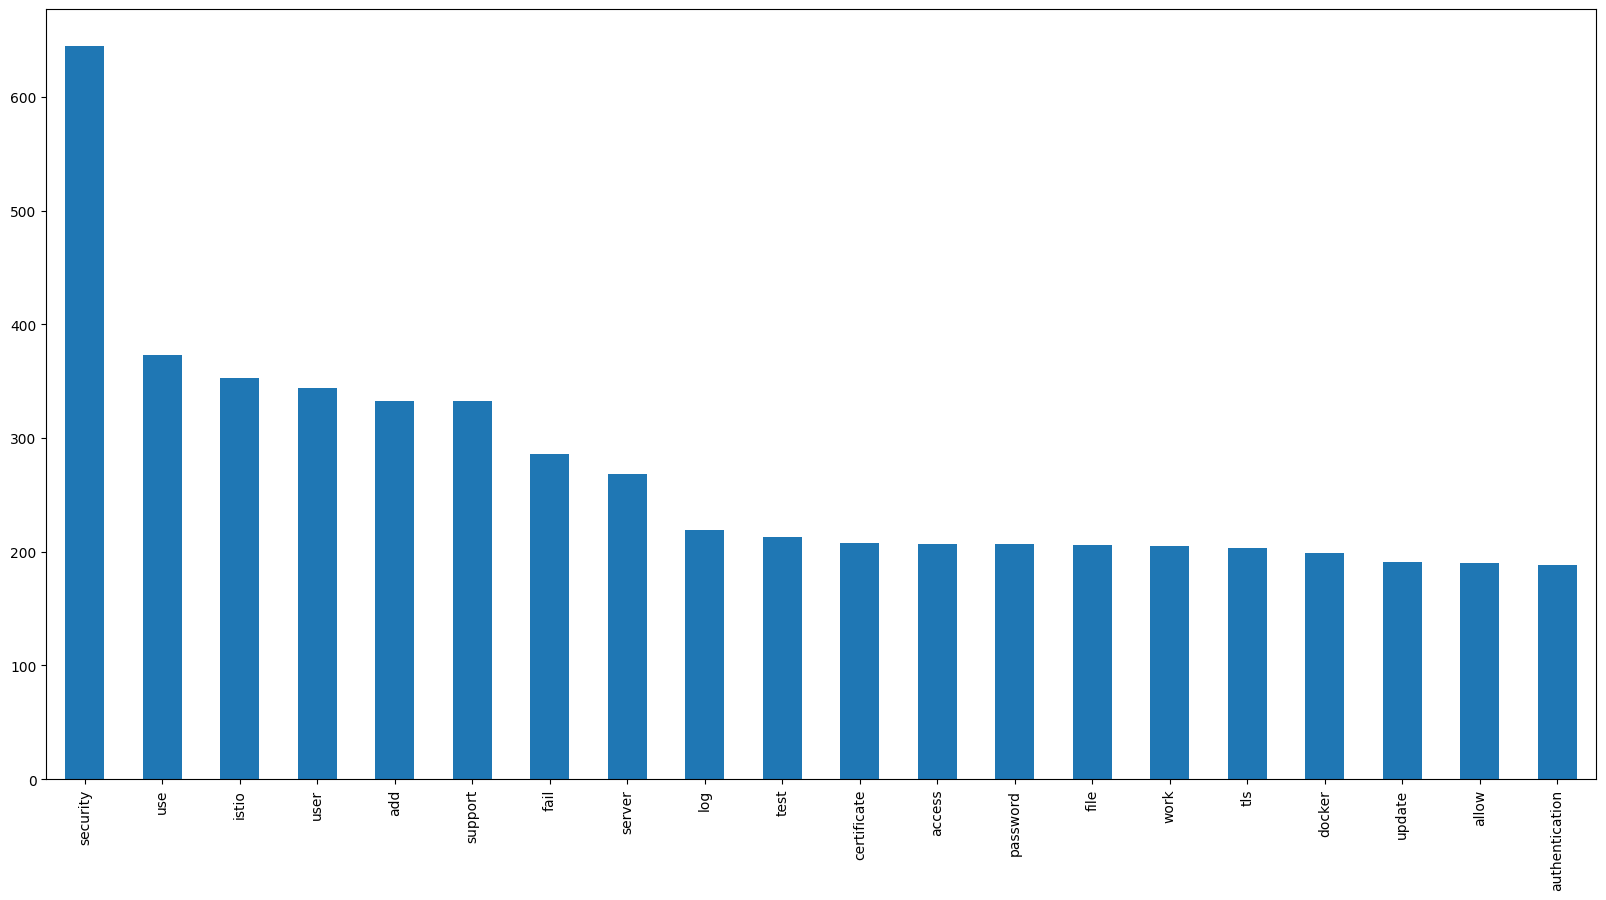

security          645
use               373
istio             353
user              344
add               333
support           333
fail              286
server            268
log               219
test              213
certificate       208
access            207
password          207
file              206
work              205
tls               203
docker            199
update            191
allow             190
authentication    188
dtype: int64


In [47]:
# Plot graph of top words in df_norm issue_title_superclean security
plt.figure(figsize=(20,10))
visual = pd.Series(" ".join([i for i in df_norm[df_norm["label"]==1]['issue_title_superclean']]).split())
visual.value_counts().head(20).plot(kind='bar')
plt.show()
print(visual.value_counts().head(20))

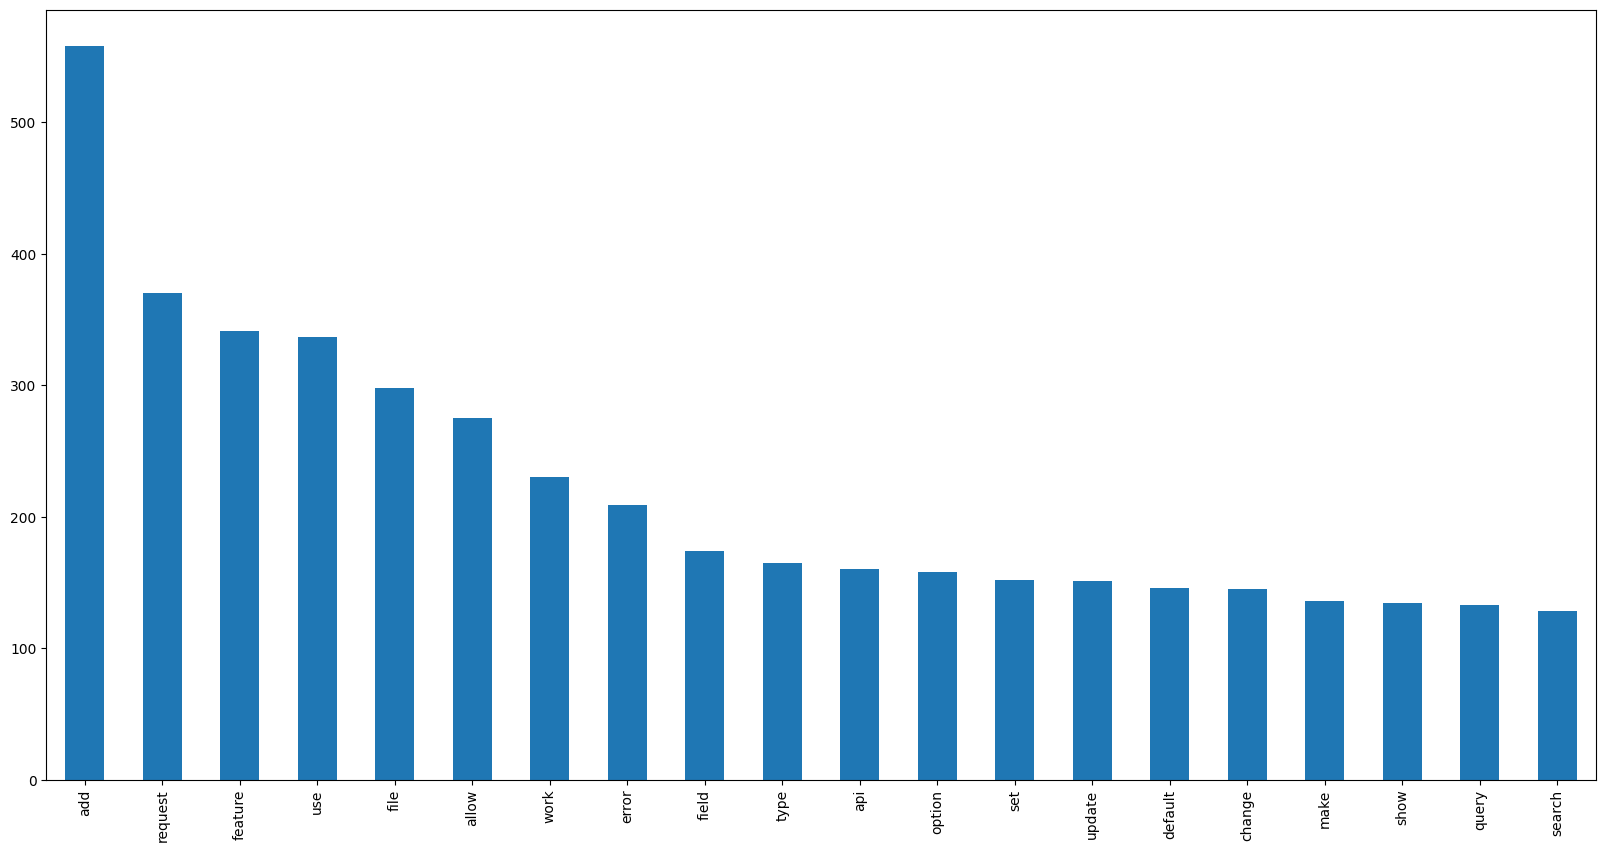

add        558
request    370
feature    341
use        337
file       298
allow      275
work       230
error      209
field      174
type       165
api        160
option     158
set        152
update     151
default    146
change     145
make       136
show       134
query      133
search     128
dtype: int64


In [48]:
# Plot graph of top words in df_norm issue_title_superclean non-security
plt.figure(figsize=(20,10))
visual = pd.Series(" ".join([i for i in df_norm[df_norm["label"]==0]['issue_title_superclean']]).split())
visual.value_counts().head(20).plot(kind='bar')
plt.show()
print(visual.value_counts().head(20))

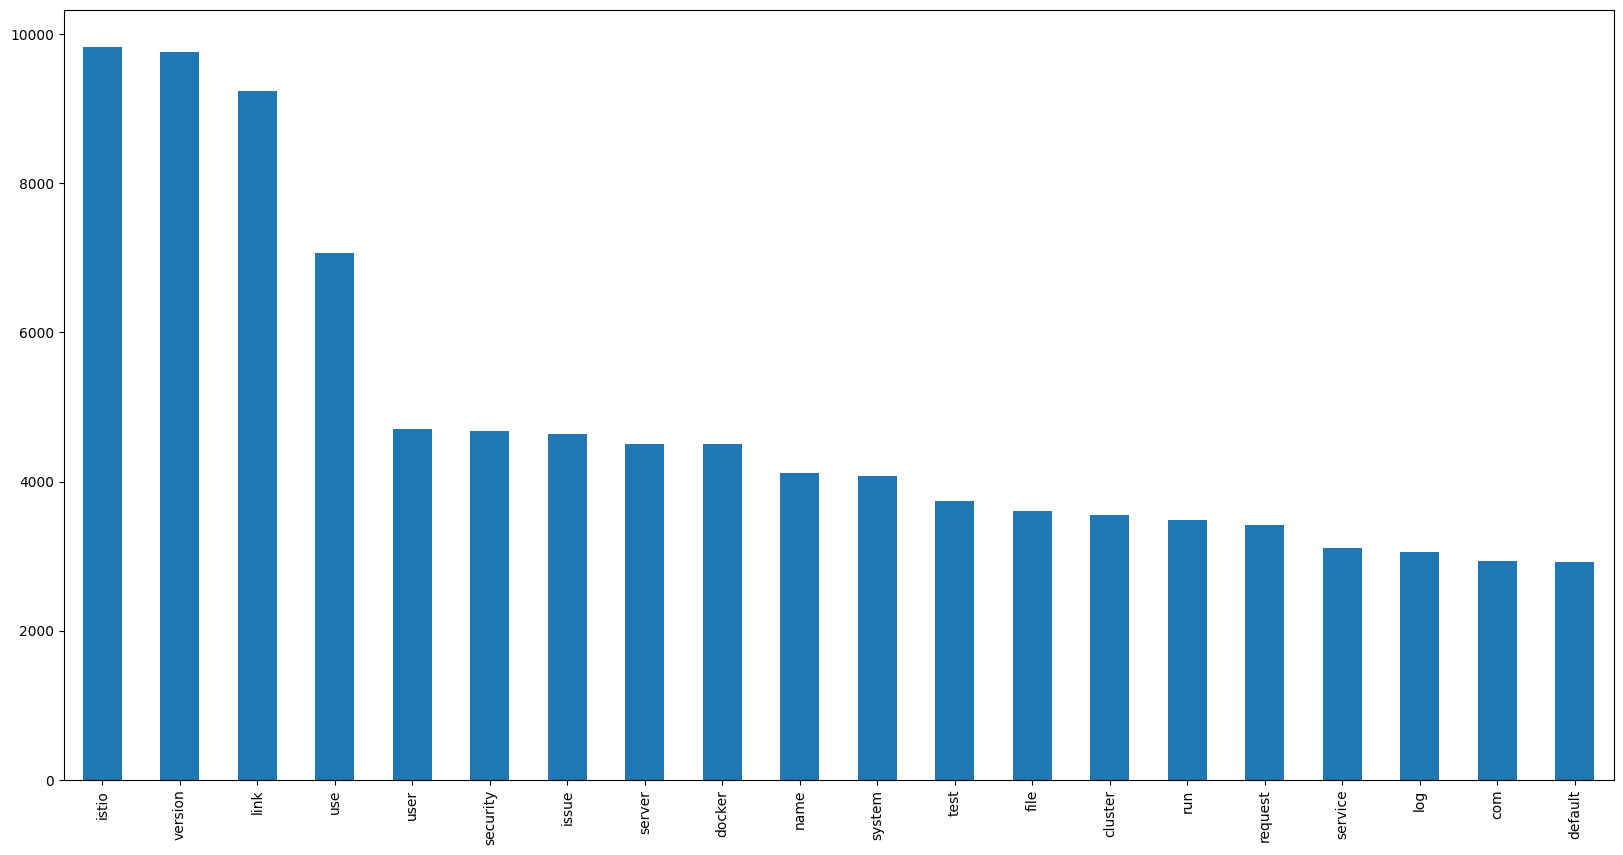

istio       9834
version     9759
link        9239
use         7072
user        4708
security    4685
issue       4641
server      4501
docker      4499
name        4115
system      4077
test        3736
file        3612
cluster     3556
run         3484
request     3414
service     3107
log         3051
com         2930
default     2917
dtype: int64


In [49]:
# Plot graph of top words in df_norm description_superclean security
plt.figure(figsize=(20,10))
visual = pd.Series(" ".join([i for i in df_norm[df_norm["label"]==1]['description_superclean']]).split())
visual.value_counts().head(20).plot(kind='bar')
plt.show()
print(visual.value_counts().head(20))

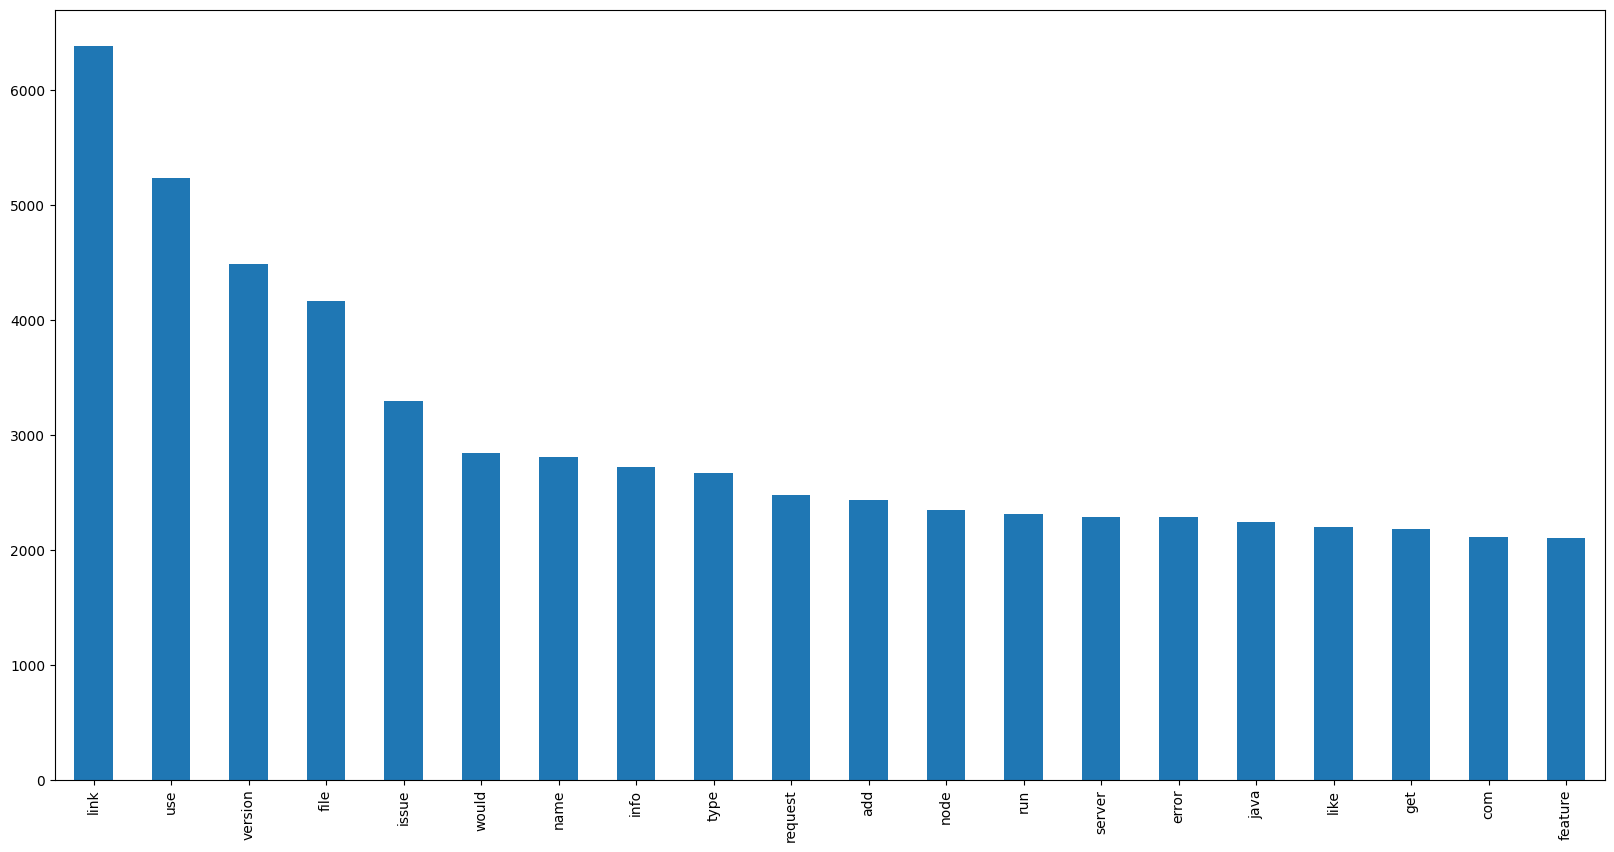

link       6383
use        5232
version    4484
file       4169
issue      3294
would      2839
name       2803
info       2718
type       2669
request    2476
add        2433
node       2348
run        2312
server     2289
error      2284
java       2239
like       2197
get        2179
com        2107
feature    2102
dtype: int64


In [50]:
# Plot graph of top words in df_norm description_superclean non-security
plt.figure(figsize=(20,10))
visual = pd.Series(" ".join([i for i in df_norm[df_norm["label"]==0]['description_superclean']]).split())
visual.value_counts().head(20).plot(kind='bar')
plt.show()
print(visual.value_counts().head(20))

## Combined Dataset (GitHub, PURE, PROMISE)

In [51]:
df_pure["Label"].value_counts()

1    616
0    616
Name: Label, dtype: int64

In [52]:
df_pure_superclean["Label"].value_counts()

1    616
0    616
Name: Label, dtype: int64

In [53]:
print(df_promise["Label"].value_counts())
df_promise_combined = pd.concat([
    df_promise[df_promise["Label"]==1].sample(
      n=df_pure[df_pure["Label"]==1].shape[0], random_state=42
    ),
    df_promise[df_promise["Label"]==0].sample(
      n=df_pure[df_pure["Label"]==1].shape[0], random_state=42
    ),
]).reset_index(drop=True)
print(df_promise_combined["Label"].value_counts())

1    804
0    804
Name: Label, dtype: int64
1    616
0    616
Name: Label, dtype: int64


In [54]:
print(df_promise_superclean["Label"].value_counts())
df_promise_superclean_combined = pd.concat([
    df_promise_superclean[df_promise_superclean["Label"]==1].sample(
      n=df_pure[df_pure["Label"]==1].shape[0], random_state=42
    ),
    df_promise_superclean[df_promise_superclean["Label"]==0].sample(
      n=df_pure[df_pure["Label"]==1].shape[0], random_state=42
    ),
]).reset_index(drop=True)
print(df_promise_superclean_combined["Label"].value_counts())

1    804
0    804
Name: Label, dtype: int64
1    616
0    616
Name: Label, dtype: int64


In [55]:
print(df_norm["label"].value_counts())
df_norm_combined = pd.concat([
    df_norm[df_norm["label"]==1].sample(
      n=df_pure[df_pure["Label"]==1].shape[0], random_state=42
    ),
    df_norm[df_norm["label"]==0].sample(
      n=df_pure[df_pure["Label"]==1].shape[0], random_state=42
    ),
]).reset_index(drop=True)
print(df_norm_combined["label"].value_counts())

1    6068
0    6068
Name: label, dtype: int64
1    616
0    616
Name: label, dtype: int64


In [56]:
df_combined = pd.concat([
    df_norm_combined[["issue_title_clean", "label"]].rename(columns={"issue_title_clean": 'Text', 'label': 'Label'}),
    df_pure.rename(columns={"Text_clean": 'Text'}), 
    df_promise_combined.rename(columns={"Text_clean": 'Text'})
]
)
df_combined = df_combined.sample(n=df_combined.shape[0], random_state=42).reset_index(drop=True)
df_combined["Label"].value_counts()

0    1848
1    1848
Name: Label, dtype: int64

In [57]:
df_combined_superclean = pd.concat([
    df_norm_combined[["issue_title_superclean", "label"]].rename(columns={"issue_title_superclean": 'Text', 'label': 'Label'}),
    df_pure_superclean.rename(columns={"Text_superclean": 'Text'}), 
    df_promise_superclean_combined.rename(columns={"Text_superclean": 'Text'})
]
)
df_combined_superclean = df_combined_superclean.sample(n=df_combined_superclean.shape[0], random_state=42).reset_index(drop=True)
df_combined_superclean["Label"].value_counts()

0    1848
1    1848
Name: Label, dtype: int64

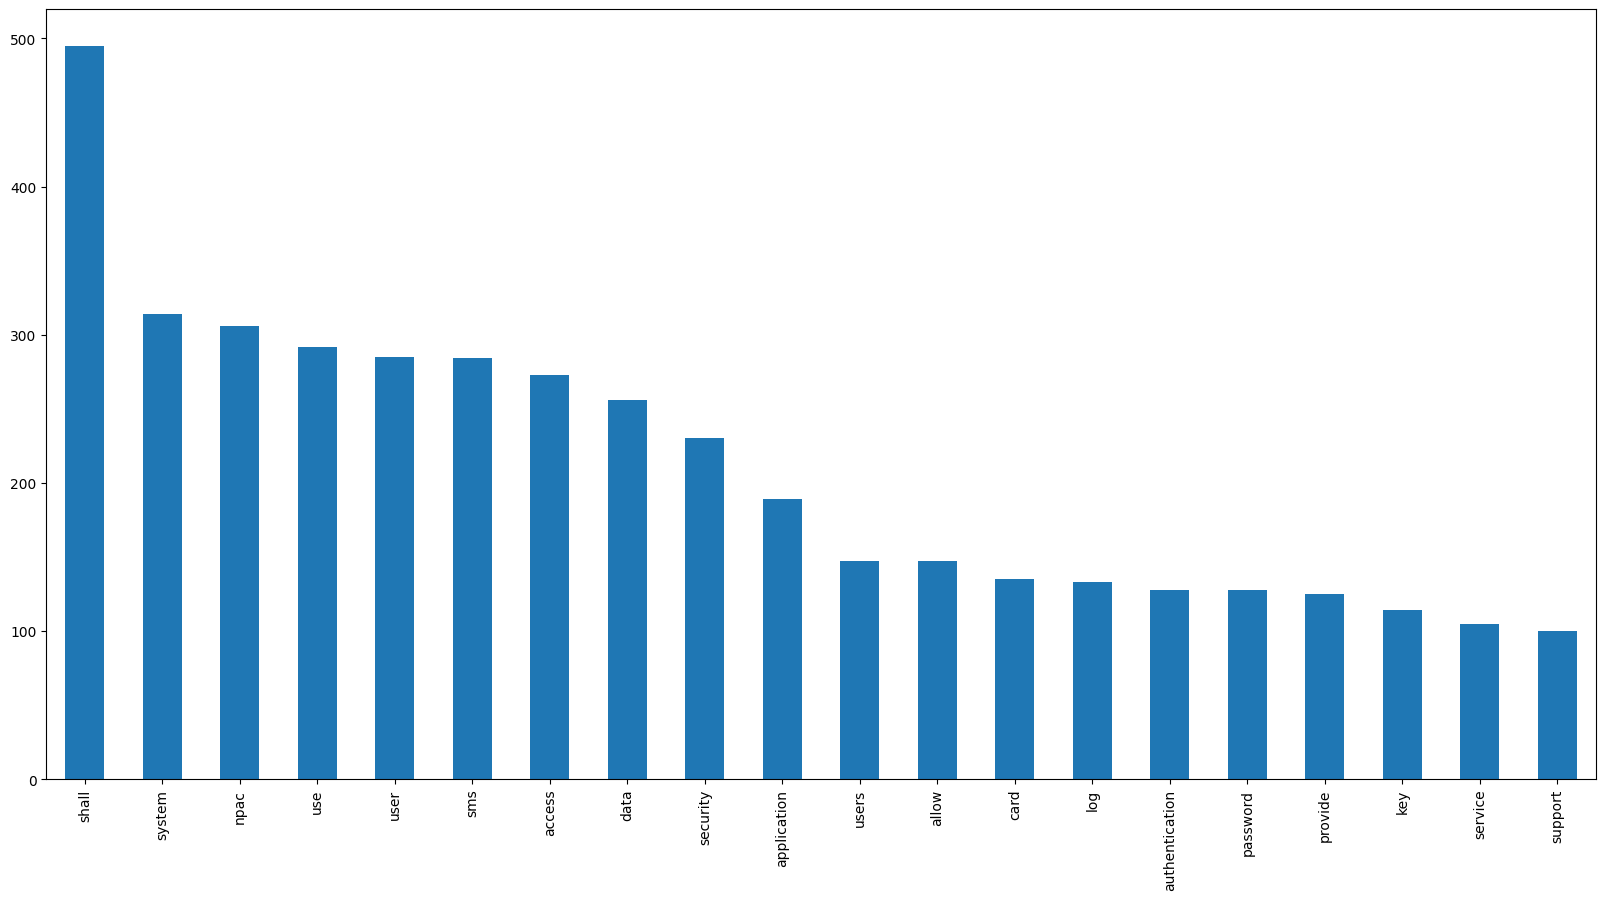

shall             495
system            314
npac              306
use               292
user              285
sms               284
access            273
data              256
security          230
application       189
users             147
allow             147
card              135
log               133
authentication    128
password          128
provide           125
key               114
service           105
support           100
dtype: int64


In [58]:
# Plot graph of top words in combined security
plt.figure(figsize=(20,10))
visual = pd.Series(" ".join([i for i in df_combined_superclean[df_combined_superclean["Label"]==1]['Text']]).split())
visual.value_counts().head(20).plot(kind='bar')
plt.show()
print(visual.value_counts().head(20))

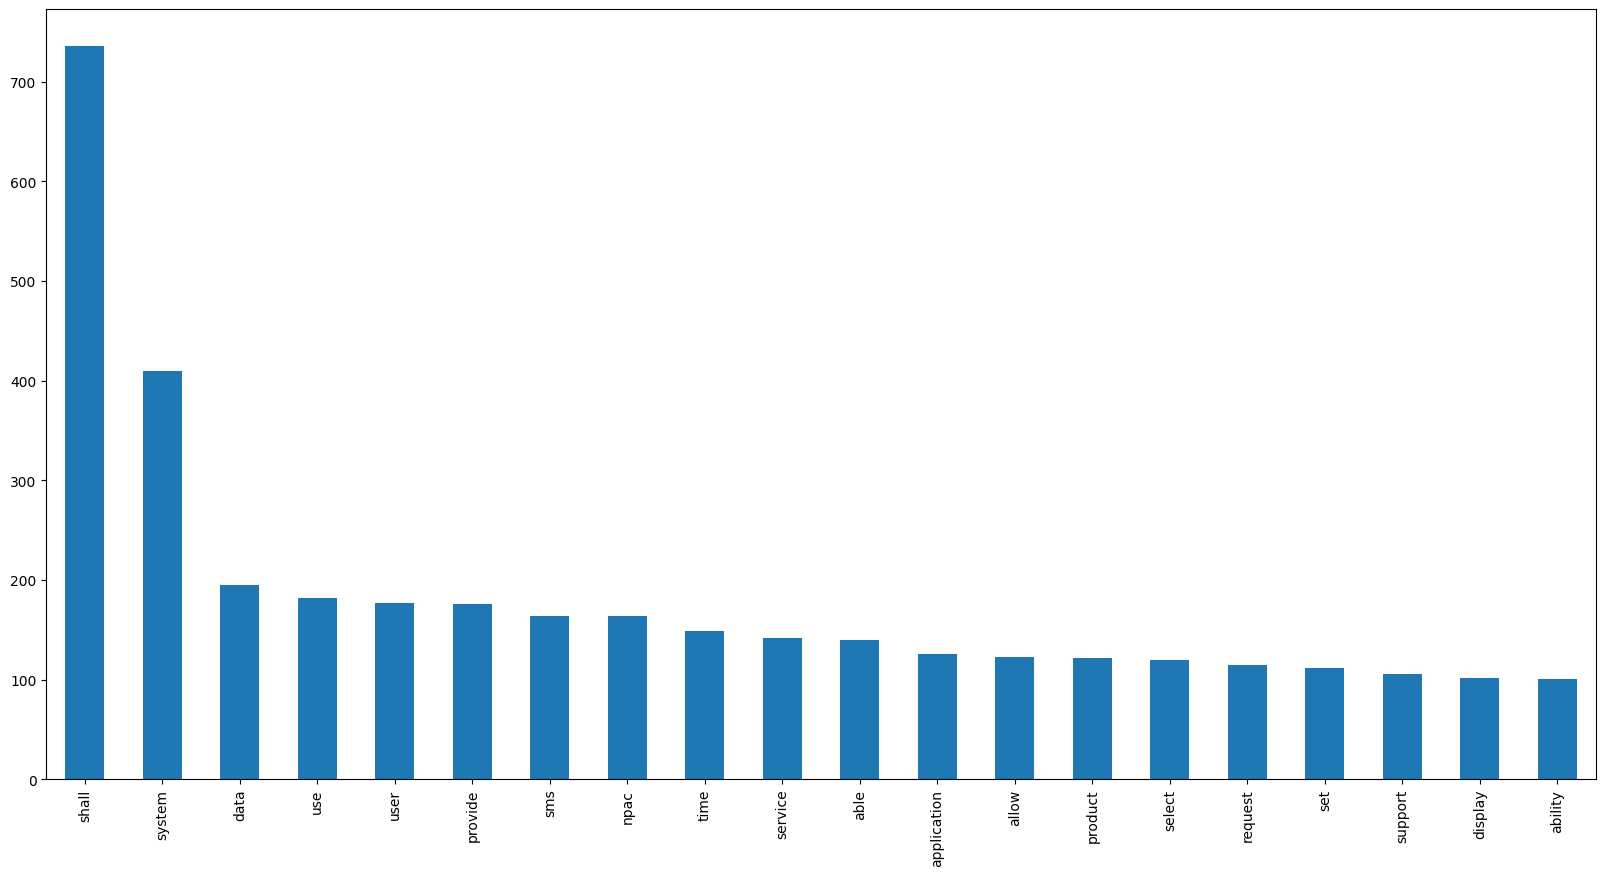

shall          736
system         410
data           195
use            182
user           177
provide        176
sms            164
npac           164
time           149
service        142
able           140
application    126
allow          123
product        122
select         120
request        115
set            112
support        106
display        102
ability        101
dtype: int64


In [59]:
# Plot graph of top words in combined non-security
plt.figure(figsize=(20,10))
visual = pd.Series(" ".join([i for i in df_combined_superclean[df_combined_superclean["Label"]==0]['Text']]).split())
visual.value_counts().head(20).plot(kind='bar')
plt.show()
print(visual.value_counts().head(20))

# Train and Test Splitting

## PURE

In [60]:
print(df_pure["Label"].value_counts())

1    616
0    616
Name: Label, dtype: int64


In [61]:
# Assign columns to X and y values
X_train_pure, X_test_pure, y_train_pure, y_test_pure = train_test_split(
    df_pure['Text_clean'],
    df_pure['Label'],
    test_size=0.2,
    random_state=42,
    stratify=df_pure['Label']
)

# Create tensorflow dataset
train_ds_pure = tf.data.Dataset.from_tensor_slices((X_train_pure, y_train_pure))
test_ds_pure = tf.data.Dataset.from_tensor_slices((X_test_pure, y_test_pure))

# Create batches
train_ds_pure = train_ds_pure.batch(32).prefetch(tf.data.AUTOTUNE)
test_ds_pure = test_ds_pure.batch(32).prefetch(tf.data.AUTOTUNE)


In [62]:
print(X_train_pure.shape)
print(X_test_pure.shape)

(985,)
(247,)


In [63]:
y_train_pure.value_counts()

1    493
0    492
Name: Label, dtype: int64

## PROMISE

In [64]:
print(df_promise["Label"].value_counts())

1    804
0    804
Name: Label, dtype: int64


In [65]:
# Assign columns to X and y values
X_train_promise, X_test_promise, y_train_promise, y_test_promise = train_test_split(
    df_promise['Text_clean'],
    df_promise['Label'],
    test_size=0.2,
    random_state=42,
    stratify=df_promise['Label']
)

# Create tensorflow dataset
train_ds_promise = tf.data.Dataset.from_tensor_slices((X_train_promise, y_train_promise))
test_ds_promise = tf.data.Dataset.from_tensor_slices((X_test_promise, y_test_promise))

# Create batches
train_ds_promise = train_ds_promise.batch(32).prefetch(tf.data.AUTOTUNE)
test_ds_promise = test_ds_promise.batch(32).prefetch(tf.data.AUTOTUNE)


In [66]:
print(X_train_promise.shape)
print(X_test_promise.shape)

(1286,)
(322,)


In [67]:
y_train_promise.value_counts()

0    643
1    643
Name: Label, dtype: int64

## GitHub dataset (with external repository)

In [68]:
# Assign columns to X and y values
X_train_external_title, y_train_external_title = df_main_clean_title['issue_title_clean'], df_main_clean_title['label']
X_test_external_title, y_test_external_title = df_new_clean_title['issue_title_clean'], df_new_clean_title['label']

# Create tensorflow dataset
train_ds_external_title = tf.data.Dataset.from_tensor_slices((X_train_external_title, y_train_external_title))
test_ds_external_title = tf.data.Dataset.from_tensor_slices((X_test_external_title, y_test_external_title))

# Create batches
train_ds_external_title = train_ds_external_title.batch(32).prefetch(tf.data.AUTOTUNE)
test_ds_external_title = test_ds_external_title.batch(32).prefetch(tf.data.AUTOTUNE)

print("Train:", df_main_clean_title.shape[0]*100/(df_main_clean_title.shape[0]+df_new_clean_title.shape[0]), "%")
print("Test:", df_new_clean_title.shape[0]*100/(df_main_clean_title.shape[0]+df_new_clean_title.shape[0]), "%")


Train: 80.03192338387869 %
Test: 19.96807661612131 %


In [69]:
y_train_external_title.value_counts()

1    5014
0    5014
Name: label, dtype: int64

In [70]:
# Assign columns to X and y values
X_train_external_description, y_train_external_description = df_main_clean_description['description_clean'], df_main_clean_description['label']
X_test_external_description, y_test_external_description = df_new_clean_description['description_clean'], df_new_clean_description['label']

# Create tensorflow dataset
train_ds_external_description = tf.data.Dataset.from_tensor_slices((X_train_external_description, y_train_external_description))
test_ds_external_description = tf.data.Dataset.from_tensor_slices((X_test_external_description, y_test_external_description))

# Create batches
train_ds_external_description = train_ds_external_description.batch(32).prefetch(tf.data.AUTOTUNE)
test_ds_external_description = test_ds_external_description.batch(32).prefetch(tf.data.AUTOTUNE)

In [71]:
y_train_external_description.value_counts()

1    5014
0    5014
Name: label, dtype: int64

**Superclean**

In [72]:
# Assign columns to X and y values
X_train_external_title_superclean, y_train_external_title_superclean = df_main_superclean_title['issue_title_superclean'], df_main_superclean_title['label']
X_test_external_title_superclean, y_test_external_title_superclean = df_new_superclean_title['issue_title_superclean'], df_new_superclean_title['label']

# Create tensorflow dataset
train_ds_external_title_superclean = tf.data.Dataset.from_tensor_slices((X_train_external_title_superclean, y_train_external_title_superclean))
test_ds_external_title_superclean = tf.data.Dataset.from_tensor_slices((X_test_external_title_superclean, y_test_external_title_superclean))

# Create batches
train_ds_external_title_superclean = train_ds_external_title_superclean.batch(32).prefetch(tf.data.AUTOTUNE)
test_ds_external_title_superclean = test_ds_external_title_superclean.batch(32).prefetch(tf.data.AUTOTUNE)


In [73]:
y_train_external_title_superclean.value_counts()

1    5014
0    5014
Name: label, dtype: int64

## GitHub dataset (without external repository)

In [74]:
# Assign columns to X and y values
X_train_title, X_test_title, y_train_title, y_test_title = train_test_split(
    df_norm['issue_title_clean'],
    df_norm['label'],
    test_size=0.2,
    random_state=42,
    stratify=df_norm['label']
)

# Create tensorflow dataset
train_ds_title = tf.data.Dataset.from_tensor_slices((X_train_title, y_train_title))
test_ds_title = tf.data.Dataset.from_tensor_slices((X_test_title, y_test_title))

# Create batches
train_ds_title = train_ds_title.batch(32).prefetch(tf.data.AUTOTUNE)
test_ds_title = test_ds_title.batch(32).prefetch(tf.data.AUTOTUNE)


In [75]:
y_train_title.value_counts()

1    4854
0    4854
Name: label, dtype: int64

In [76]:
# Assign columns to X and y values
X_train_description, X_test_description, y_train_description, y_test_description = train_test_split(
    df_norm['description_clean'],
    df_norm['label'],
    test_size=0.2,
    random_state=42,
    stratify=df_norm['label']
)

# Create tensorflow dataset
train_ds_description = tf.data.Dataset.from_tensor_slices((X_train_description, y_train_description))
test_ds_description = tf.data.Dataset.from_tensor_slices((X_test_description, y_test_description))

# Create batches
train_ds_description = train_ds_description.batch(32).prefetch(tf.data.AUTOTUNE)
test_ds_description = test_ds_description.batch(32).prefetch(tf.data.AUTOTUNE)


In [77]:
y_train_description.value_counts()

1    4854
0    4854
Name: label, dtype: int64

## Combined dataset

In [78]:
# Assign columns to X and y values
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(
    df_combined['Text'],
    df_combined['Label'],
    test_size=0.2,
    random_state=42,
    stratify=df_combined['Label']
)

# Create tensorflow dataset
train_ds_combined = tf.data.Dataset.from_tensor_slices((X_train_combined, y_train_combined))
test_ds_combined = tf.data.Dataset.from_tensor_slices((X_test_combined, y_test_combined))

# Create batches
train_ds_combined = train_ds_combined.batch(32).prefetch(tf.data.AUTOTUNE)
test_ds_combined = test_ds_combined.batch(32).prefetch(tf.data.AUTOTUNE)


In [79]:
y_train_combined.value_counts()

1    1478
0    1478
Name: Label, dtype: int64

# TF-IDF

## PURE

In [82]:
# TF-IDF PURE dataset
vectorizer_pure = TfidfVectorizer()

vectorizer_pure.fit(df_pure['Text_clean'])
train_X_tfidf_pure = vectorizer_pure.transform(X_train_pure)
test_X_tfidf_pure = vectorizer_pure.transform(X_test_pure)

## PROMISE

In [83]:
# TF-IDF PROMISE dataset
vectorizer_promise = TfidfVectorizer()

vectorizer_promise.fit(df_promise['Text_clean'])
train_X_tfidf_promise = vectorizer_promise.transform(X_train_promise)
test_X_tfidf_promise = vectorizer_promise.transform(X_test_promise)

## GitHub dataset (with external repository)

In [84]:
# TF-IDF external title dataset
vectorizer_external_title = TfidfVectorizer()

vectorizer_external_title.fit(df_main_clean_title['issue_title_clean'])
train_X_tfidf_external_title = vectorizer_external_title.transform(X_train_external_title)
test_X_tfidf_external_title = vectorizer_external_title.transform(X_test_external_title)

In [85]:
# TF-IDF external description dataset
vectorizer_external_description = TfidfVectorizer()

vectorizer_external_description.fit(df_main_clean_description['description_clean'])
train_X_tfidf_external_description = vectorizer_external_description.transform(X_train_external_description)
test_X_tfidf_external_description = vectorizer_external_description.transform(X_test_external_description)

In [86]:
# TF-IDF external title dataset SUPERCLEAN
vectorizer_external_title_superclean = TfidfVectorizer()

vectorizer_external_title_superclean.fit(df_main_superclean_title['issue_title_superclean'])
train_X_tfidf_external_title_superclean = vectorizer_external_title_superclean.transform(X_train_external_title_superclean)
test_X_tfidf_external_title_superclean = vectorizer_external_title_superclean.transform(X_test_external_title_superclean)

## GitHub dataset (without external repository)

In [87]:
# TF-IDF non-external title dataset
vectorizer_title = TfidfVectorizer()

vectorizer_title.fit(df_norm['issue_title_clean'])
train_X_tfidf_title = vectorizer_title.transform(X_train_title)
test_X_tfidf_title = vectorizer_title.transform(X_test_title)

In [88]:
# TF-IDF non-external description dataset
vectorizer_description = TfidfVectorizer()

vectorizer_description.fit(df_norm['description_clean'])
train_X_tfidf_description = vectorizer_description.transform(X_train_description)
test_X_tfidf_description = vectorizer_description.transform(X_test_description)

## Combined Dataset

In [89]:
# TF-IDF Combined dataset
vectorizer_combined = TfidfVectorizer()

vectorizer_combined.fit(df_combined['Text'])
train_X_tfidf_combined = vectorizer_combined.transform(X_train_combined)
test_X_tfidf_combined = vectorizer_combined.transform(X_test_combined)

# Naive Bayes

## Naive Bayes - PURE

In [ ]:
Naive_pure = MultinomialNB()

# Fit model
history_NB_pure = Naive_pure.fit(train_X_tfidf_pure, y_train_pure)

# Predict the labels on validation dataset
predictions_NB_pure = Naive_pure.predict(test_X_tfidf_pure)

print(classification_report(predictions_NB_pure, y_test_pure))

              precision    recall  f1-score   support

           0       0.65      0.90      0.75        89
           1       0.93      0.72      0.81       158

    accuracy                           0.79       247
   macro avg       0.79      0.81      0.78       247
weighted avg       0.83      0.79      0.79       247



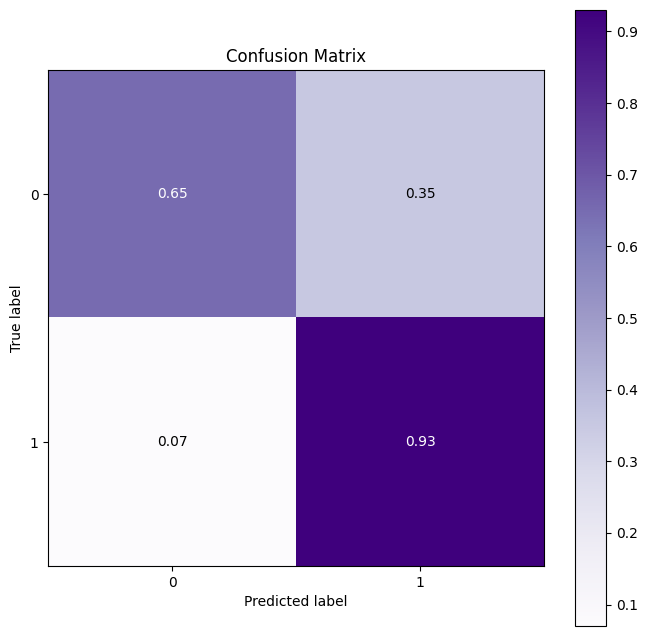

In [ ]:
import scikitplot as skplt

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
skplt.metrics.plot_confusion_matrix(y_test_pure, predictions_NB_pure,
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    ax=ax
                                    );

In [ ]:
fig.savefig('confusion_matrix_NB_pure.png')

## Naive Bayes - PROMISE

In [ ]:
Naive_promise = MultinomialNB()

# Fit model
Naive_promise.fit(train_X_tfidf_promise, y_train_promise)

# Predict the labels on validation dataset
predictions_NB_promise = Naive_promise.predict(test_X_tfidf_promise)

# Print metrics
print(classification_report(predictions_NB_promise, y_test_promise))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       156
           1       0.95      0.92      0.94       166

    accuracy                           0.93       322
   macro avg       0.93      0.94      0.93       322
weighted avg       0.94      0.93      0.93       322



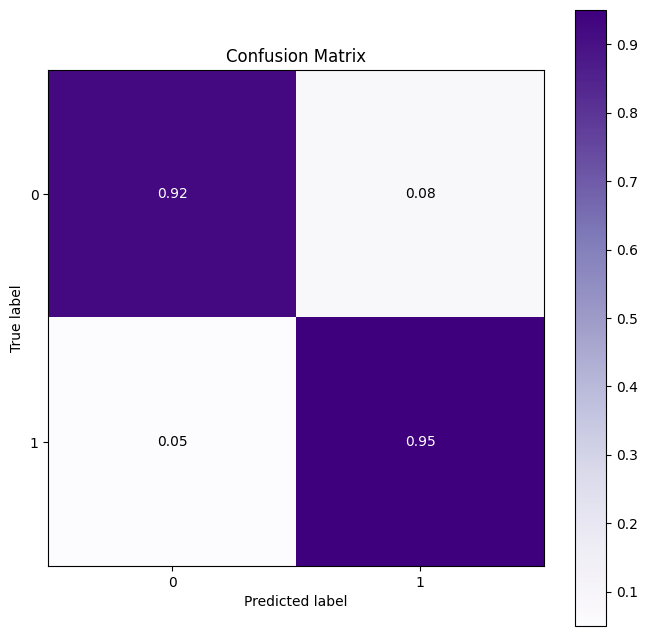

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
skplt.metrics.plot_confusion_matrix(y_test_promise, predictions_NB_promise,
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    ax=ax
                                    );
fig.savefig('confusion_matrix_NB_promise.png')

## Naive Bayes - External - Title

In [ ]:
Naive_external_title = MultinomialNB()

# Fit model
Naive_external_title.fit(train_X_tfidf_external_title, y_train_external_title)

# Predict the labels on validation dataset
predictions_NB_external_title = Naive_external_title.predict(test_X_tfidf_external_title)


# Print metrics
print(classification_report(predictions_NB_external_title, y_test_external_title))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1380
           1       0.80      0.76      0.78      1122

    accuracy                           0.81      2502
   macro avg       0.81      0.80      0.80      2502
weighted avg       0.81      0.81      0.81      2502



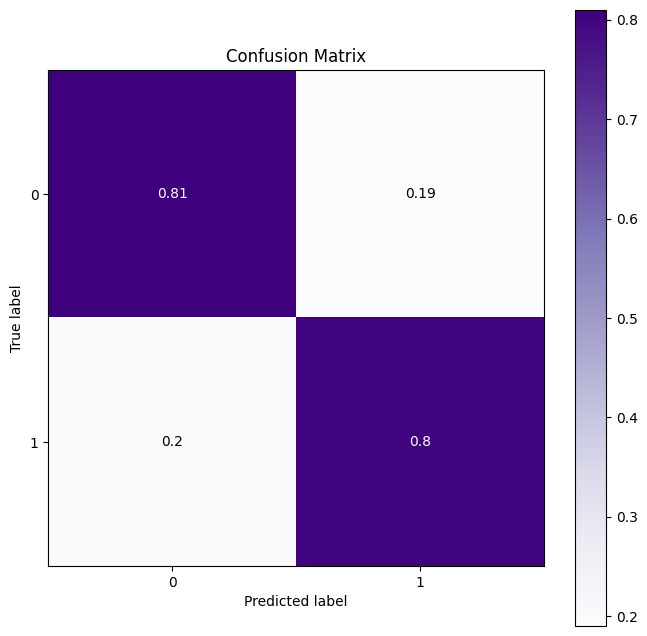

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
skplt.metrics.plot_confusion_matrix(y_test_external_title, predictions_NB_external_title,
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    ax=ax
                                    );
fig.savefig('confusion_matrix_NB_external_title.png')

## Naive Bayes - External - Description

In [ ]:
Naive_external_description = MultinomialNB()

# Fit model
Naive_external_description.fit(train_X_tfidf_external_description,y_train_external_description)

# Predict the labels on validation dataset
predictions_NB_external_description = Naive_external_description.predict(test_X_tfidf_external_description)

# Print metrics
print(classification_report(predictions_NB_external_description, y_test_external_description))

              precision    recall  f1-score   support

           0       0.79      0.80      0.79      1416
           1       0.74      0.71      0.73      1086

    accuracy                           0.76      2502
   macro avg       0.76      0.76      0.76      2502
weighted avg       0.76      0.76      0.76      2502



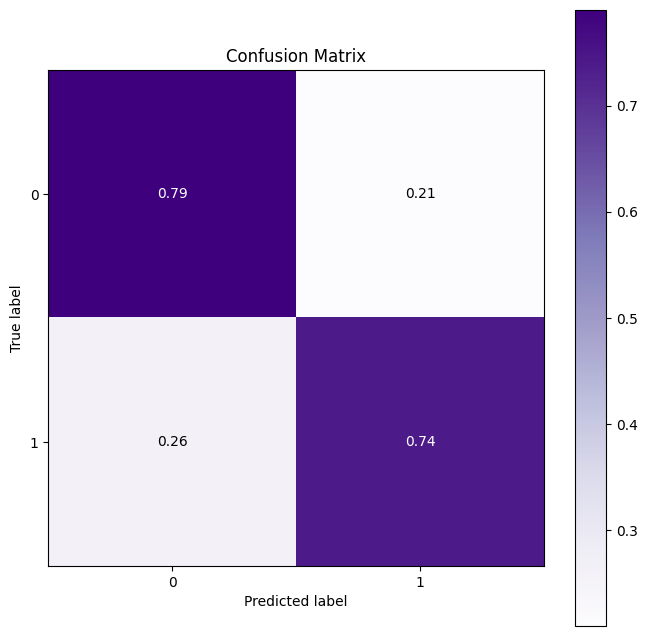

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
skplt.metrics.plot_confusion_matrix(y_test_external_description, predictions_NB_external_description,
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    ax=ax
                                    );
fig.savefig('confusion_matrix_NB_external_description.png')

## Naive Bayes - Non-External - Title

In [ ]:
Naive_title = MultinomialNB()

# Fit model
Naive_title.fit(train_X_tfidf_title, y_train_title)

# Predict the labels on validation dataset
predictions_NB_title = Naive_title.predict(test_X_tfidf_title)


# Print metrics
print(classification_report(predictions_NB_title, y_test_title))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89      1204
           1       0.90      0.89      0.89      1224

    accuracy                           0.89      2428
   macro avg       0.89      0.89      0.89      2428
weighted avg       0.89      0.89      0.89      2428



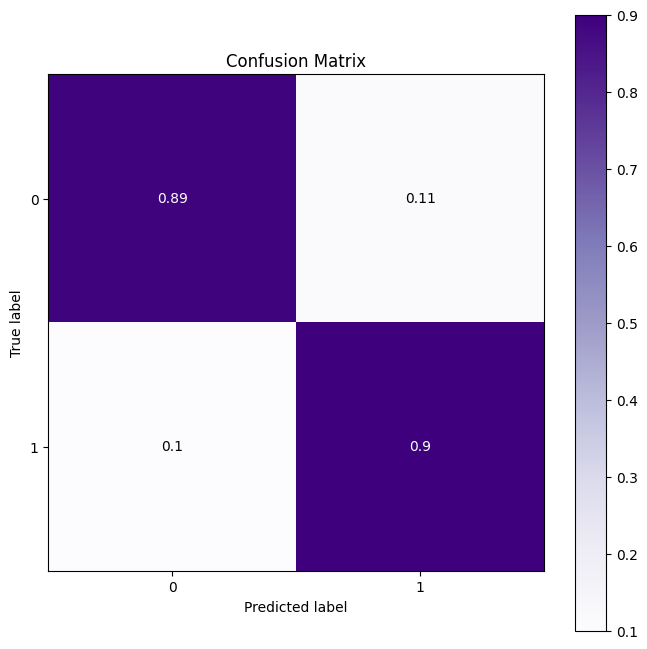

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
skplt.metrics.plot_confusion_matrix(y_test_title, predictions_NB_title,
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    ax=ax
                                    );
fig.savefig('confusion_matrix_NB_title.png')

## Naive Bayes - Non-External - Description

In [ ]:
Naive_description = MultinomialNB()

# Fit model
Naive_description.fit(train_X_tfidf_description, y_train_description)

# Predict the labels on validation dataset
predictions_NB_description = Naive_description.predict(test_X_tfidf_description)

# Print metrics
print(classification_report(predictions_NB_description, y_test_description))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1192
           1       0.91      0.89      0.90      1236

    accuracy                           0.90      2428
   macro avg       0.90      0.90      0.90      2428
weighted avg       0.90      0.90      0.90      2428



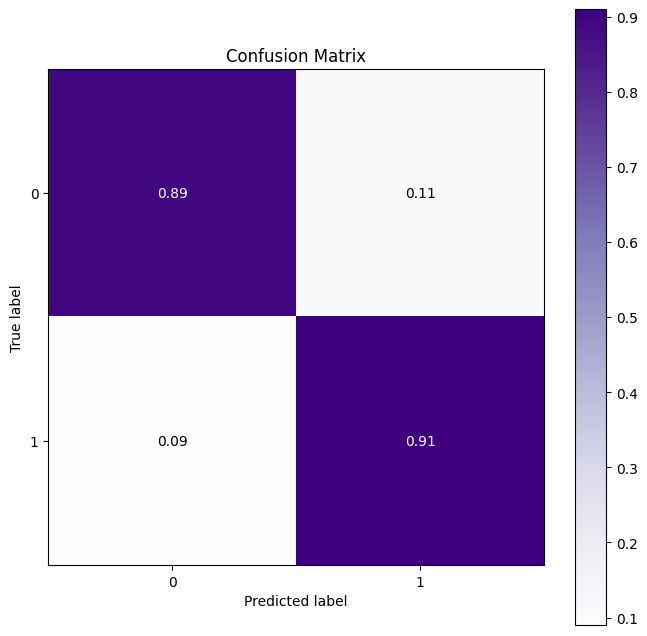

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
skplt.metrics.plot_confusion_matrix(y_test_description, predictions_NB_description,
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    ax=ax
                                    );
fig.savefig('confusion_matrix_NB_description.png')

## Naive Bayes - Combined

In [ ]:
Naive_combined = MultinomialNB()

# Fit model
Naive_combined.fit(train_X_tfidf_combined, y_train_combined)

# Predict the labels on validation dataset
predictions_NB_combined = Naive_combined.predict(test_X_tfidf_combined)

# Print metrics
print(classification_report(predictions_NB_combined, y_test_combined))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       332
           1       0.92      0.83      0.87       408

    accuracy                           0.87       740
   macro avg       0.87      0.87      0.87       740
weighted avg       0.87      0.87      0.87       740



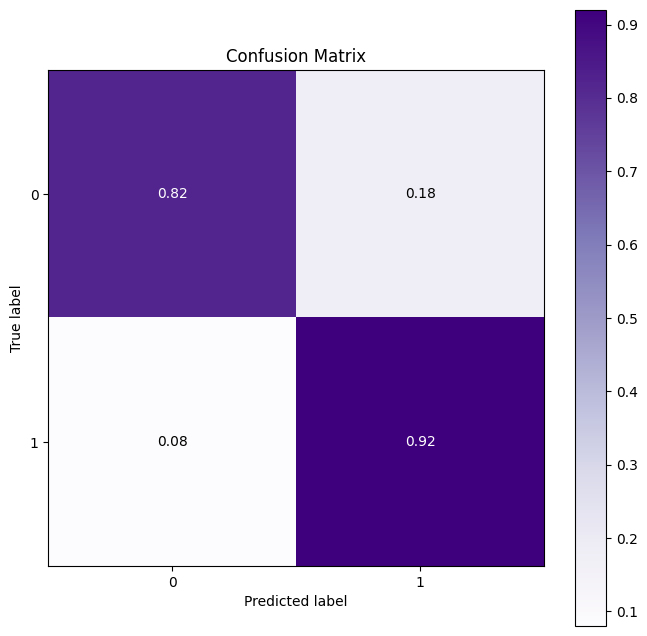

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
skplt.metrics.plot_confusion_matrix(y_test_combined, predictions_NB_combined,
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    ax=ax
                                    );
fig.savefig('confusion_matrix_NB_combined.png')

# SVM

## SVM - PURE

In [ ]:
# Fit the training dataset on the classifier
SVM_pure = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM_pure.fit(train_X_tfidf_pure, y_train_pure)

# Predict the labels on validation dataset
predictions_SVM_pure = SVM_pure.predict(test_X_tfidf_pure)

print(classification_report(predictions_SVM_pure, y_test_pure))

              precision    recall  f1-score   support

           0       0.85      0.86      0.86       123
           1       0.86      0.85      0.86       124

    accuracy                           0.86       247
   macro avg       0.86      0.86      0.86       247
weighted avg       0.86      0.86      0.86       247



In [ ]:
predictions_SVM_pure_train = SVM_pure.predict(train_X_tfidf_pure)

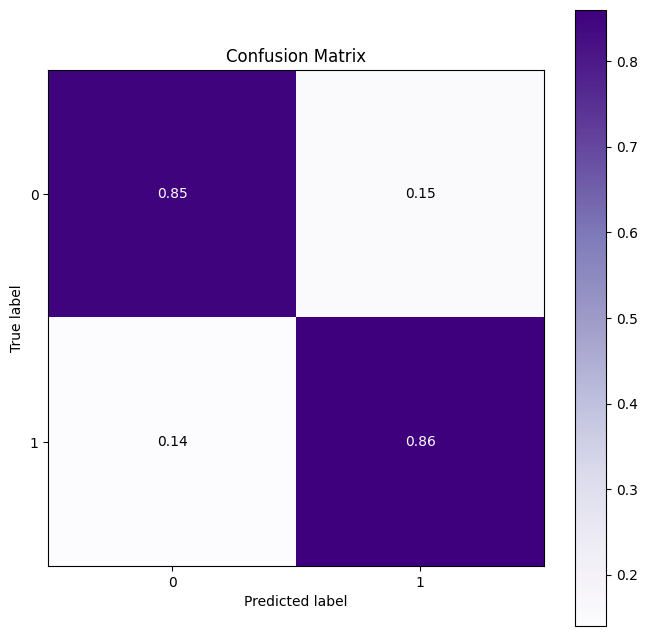

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
skplt.metrics.plot_confusion_matrix(y_test_pure, predictions_SVM_pure,
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    ax=ax
                                    );
fig.savefig('confusion_matrix_SVM_pure.png')

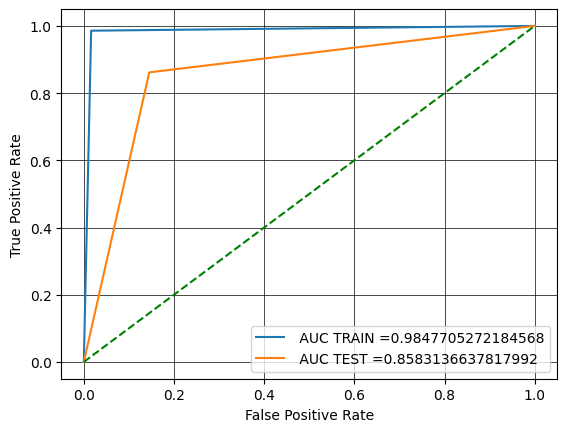

<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.metrics import roc_curve, auc
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_pure, predictions_SVM_pure_train)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test_pure, predictions_SVM_pure)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.savefig('roc_curve_SVM_pure.png')

## SVM - PROMISE

In [ ]:
# Fit the training dataset on the classifier
SVM_promise = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM_promise.fit(train_X_tfidf_promise, y_train_promise)

# Predict the labels on validation dataset
predictions_SVM_promise = SVM_promise.predict(test_X_tfidf_promise)

print(classification_report(predictions_SVM_promise, y_test_promise))

              precision    recall  f1-score   support

           0       0.93      0.92      0.92       162
           1       0.92      0.93      0.92       160

    accuracy                           0.92       322
   macro avg       0.92      0.92      0.92       322
weighted avg       0.92      0.92      0.92       322



In [ ]:
predictions_SVM_promise_train = SVM_promise.predict(train_X_tfidf_promise)

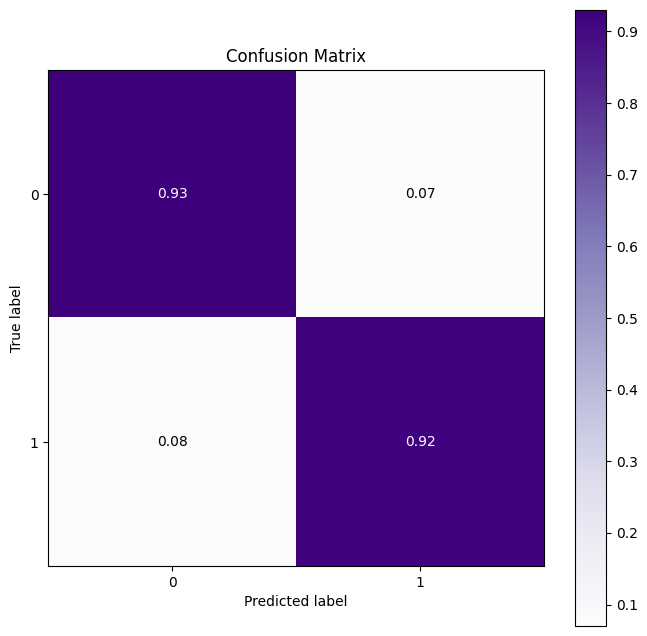

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
skplt.metrics.plot_confusion_matrix(y_test_promise, predictions_SVM_promise,
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    ax=ax
                                    );
fig.savefig('confusion_matrix_SVM_promise.png')

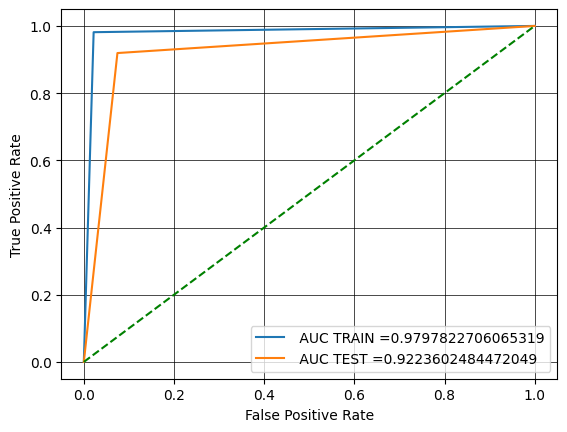

In [ ]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_promise, predictions_SVM_promise_train)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test_promise, predictions_SVM_promise)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.savefig('roc_curve_SVM_promise.png')

## SVM - External -Title

In [ ]:
# Fit the training dataset on the classifier
SVM_external_title = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM_external_title.fit(train_X_tfidf_external_title,y_train_external_title)

# Predict the labels on validation dataset
predictions_SVM_external_title = SVM_external_title.predict(test_X_tfidf_external_title)
predictions_SVM_external_title_train = SVM_external_title.predict(train_X_tfidf_external_title)

print(classification_report(predictions_SVM_external_title, y_test_external_title))

              precision    recall  f1-score   support

           0       0.91      0.83      0.86      1595
           1       0.74      0.85      0.79       907

    accuracy                           0.84      2502
   macro avg       0.82      0.84      0.83      2502
weighted avg       0.85      0.84      0.84      2502



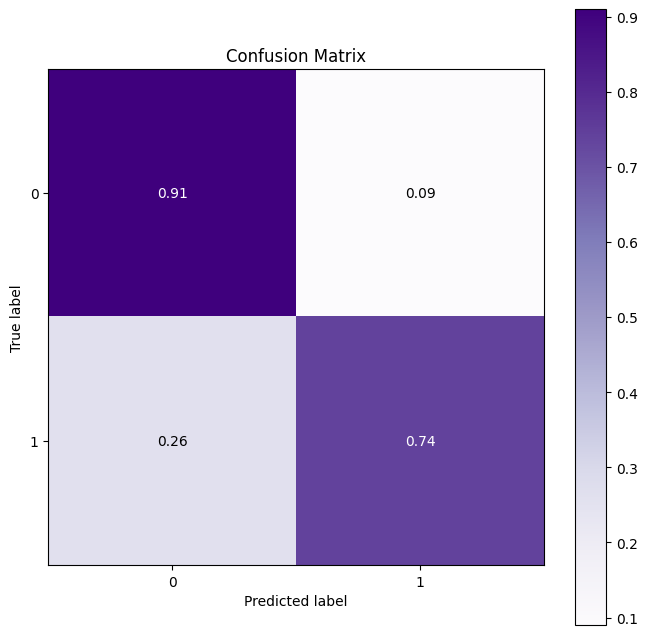

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
skplt.metrics.plot_confusion_matrix(y_test_external_title, predictions_SVM_external_title,
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    ax=ax
                                    );
fig.savefig('confusion_matrix_SVM_external_title.png')

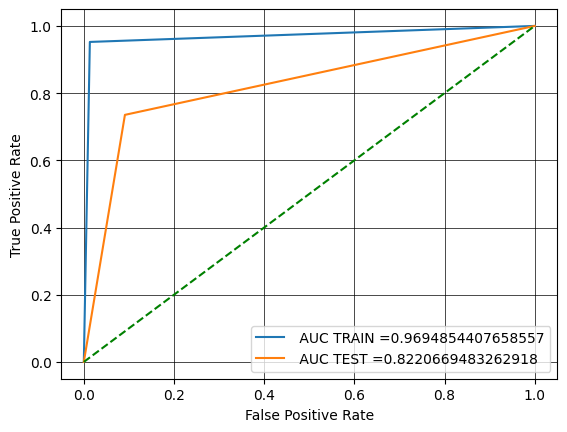

In [ ]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_external_title, predictions_SVM_external_title_train)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test_external_title, predictions_SVM_external_title)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.savefig('roc_curve_SVM_external_title.png')

## SVM - External - Description

In [ ]:
# Fit the training dataset on the classifier
SVM_external_description = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM_external_description.fit(train_X_tfidf_external_description, y_train_external_description)

# Predict the labels on validation dataset
predictions_SVM_external_description = SVM_external_description.predict(test_X_tfidf_external_description)

print(classification_report(predictions_SVM_external_description, y_test_external_description))

              precision    recall  f1-score   support

           0       0.90      0.81      0.85      1601
           1       0.71      0.84      0.77       901

    accuracy                           0.82      2502
   macro avg       0.81      0.82      0.81      2502
weighted avg       0.83      0.82      0.82      2502



In [ ]:
predictions_SVM_external_description_train = SVM_external_description.predict(train_X_tfidf_external_description)

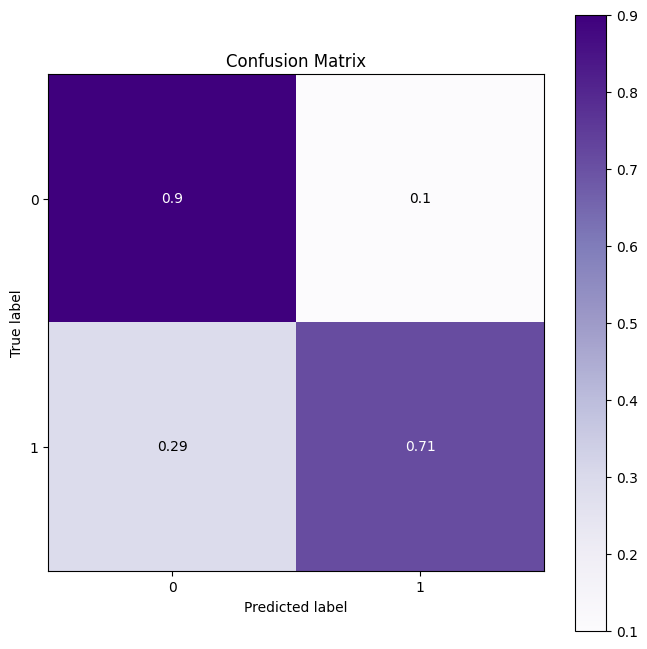

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
skplt.metrics.plot_confusion_matrix(y_test_external_description, predictions_SVM_external_description,
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    ax=ax
                                    );
fig.savefig('confusion_matrix_SVM_external_description.png')

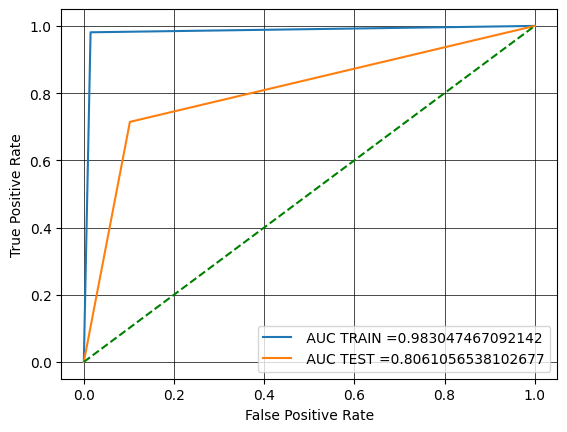

In [ ]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_external_description, predictions_SVM_external_description_train)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test_external_description, predictions_SVM_external_description)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.savefig('roc_curve_SVM_external_description.png')

## SVM - Non-External -Title

In [ ]:
# Fit the training dataset on the classifier
SVM_title = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM_title.fit(train_X_tfidf_title,y_train_title)

# Predict the labels on validation dataset
predictions_SVM_title = SVM_title.predict(test_X_tfidf_title)
predictions_SVM_title_train = SVM_title.predict(train_X_tfidf_title)

print(classification_report(predictions_SVM_title, y_test_title))

              precision    recall  f1-score   support

           0       0.95      0.86      0.90      1350
           1       0.84      0.95      0.89      1078

    accuracy                           0.90      2428
   macro avg       0.90      0.90      0.90      2428
weighted avg       0.90      0.90      0.90      2428



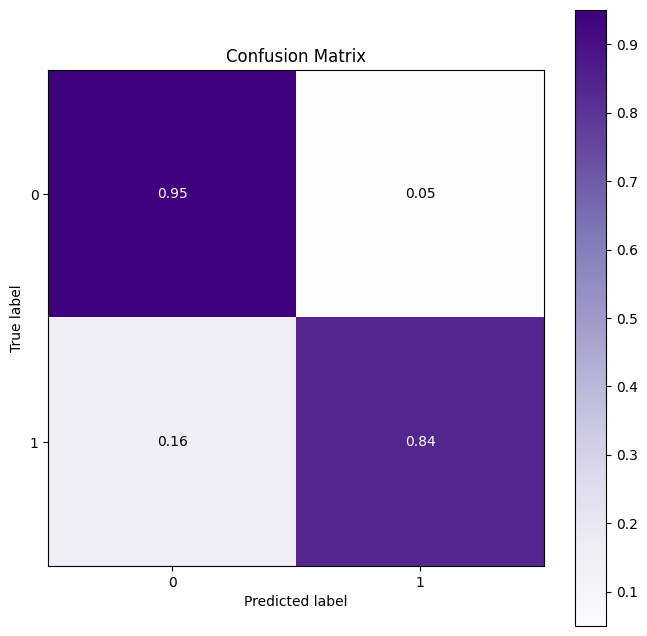

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
skplt.metrics.plot_confusion_matrix(y_test_title, predictions_SVM_title,
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    ax=ax
                                    );
fig.savefig('confusion_matrix_SVM_title.png')

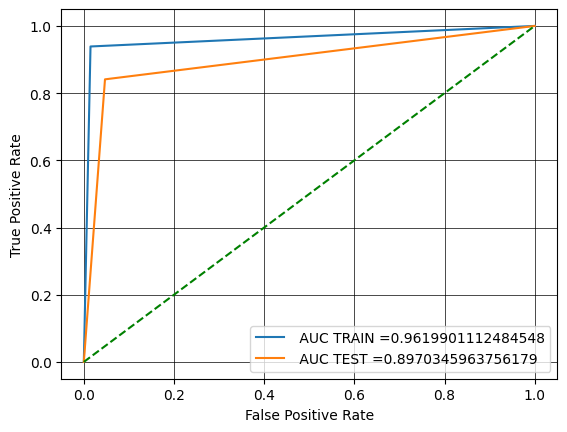

In [ ]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_title, predictions_SVM_title_train)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test_title, predictions_SVM_title)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.savefig('roc_curve_SVM_title.png')

## SVM - Non-External - Description

In [ ]:
# Fit the training dataset on the classifier
SVM_description = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM_description.fit(train_X_tfidf_description, y_train_description)

# Predict the labels on validation dataset
predictions_SVM_description = SVM_description.predict(test_X_tfidf_description)
predictions_SVM_description_train = SVM_description.predict(train_X_tfidf_description)

print(classification_report(predictions_SVM_description, y_test_description))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      1300
           1       0.88      0.95      0.91      1128

    accuracy                           0.92      2428
   macro avg       0.92      0.92      0.92      2428
weighted avg       0.92      0.92      0.92      2428



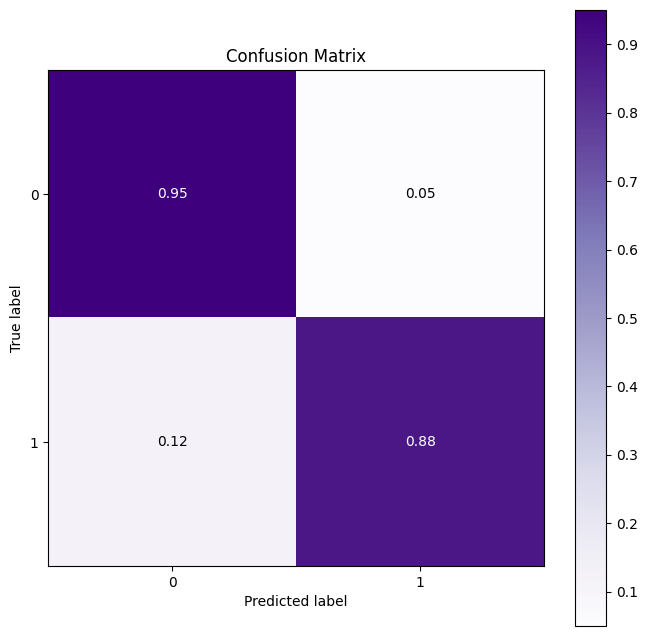

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
skplt.metrics.plot_confusion_matrix(y_test_description, predictions_SVM_description,
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    ax=ax
                                    );
fig.savefig('confusion_matrix_SVM_description.png')

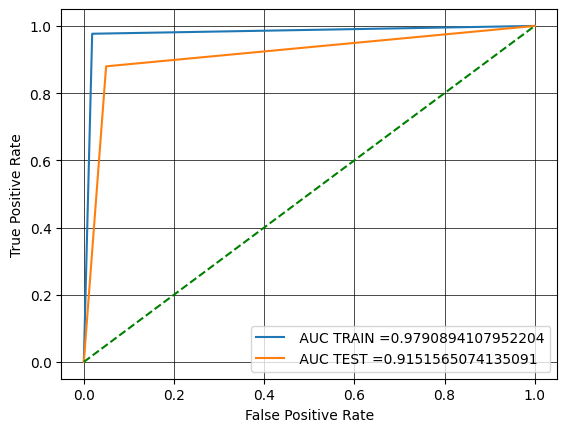

In [ ]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_description, predictions_SVM_description_train)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test_description, predictions_SVM_description)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.savefig('roc_curve_SVM_description.png')

## SVM - Combined

In [ ]:
# Fit the training dataset on the classifier
SVM_combined = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM_combined.fit(train_X_tfidf_combined, y_train_combined)

# Predict the labels on validation dataset
predictions_SVM_combined = SVM_combined.predict(test_X_tfidf_combined)
predictions_SVM_combined_train = SVM_combined.predict(train_X_tfidf_combined)

print(classification_report(predictions_SVM_combined, y_test_combined))

              precision    recall  f1-score   support

           0       0.90      0.83      0.86       398
           1       0.82      0.89      0.85       342

    accuracy                           0.86       740
   macro avg       0.86      0.86      0.86       740
weighted avg       0.86      0.86      0.86       740



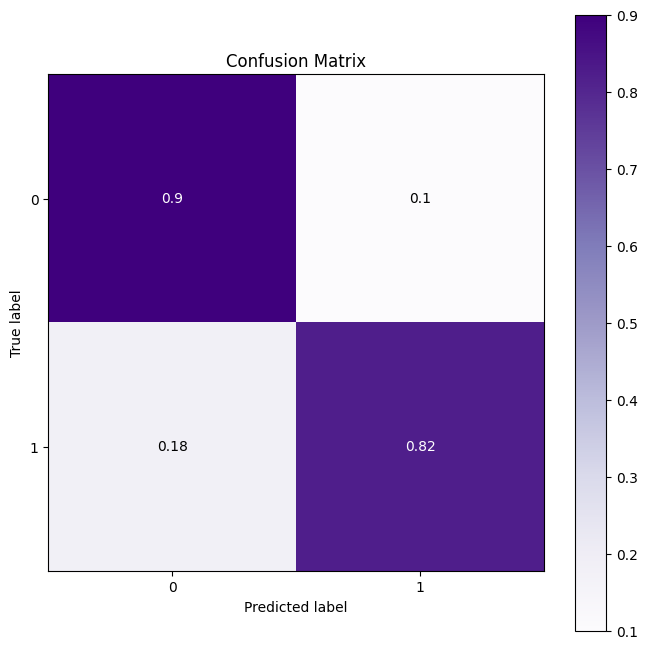

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
skplt.metrics.plot_confusion_matrix(y_test_combined, predictions_SVM_combined,
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    ax=ax
                                    );
fig.savefig('confusion_matrix_SVM_combined.png')

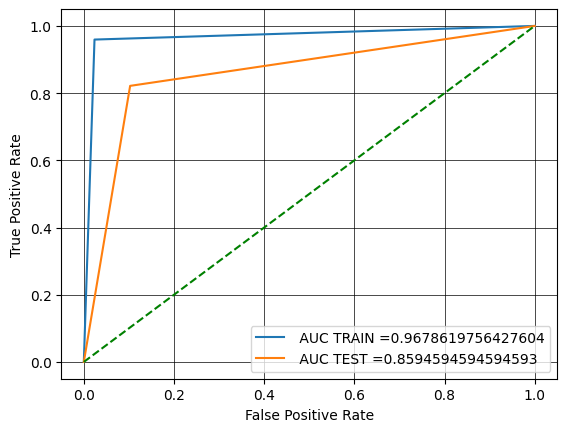

In [ ]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_combined, predictions_SVM_combined_train)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test_combined, predictions_SVM_combined)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.savefig('roc_curve_SVM_combined.png')

# LSTM

## LSTM - PURE

In [ ]:
# Encode data
encoder_pure = tf.keras.layers.TextVectorization(max_tokens=1000)
encoder_pure.adapt(train_ds_pure.map(lambda text, label: text))
vocab_pure = np.array(encoder_pure.get_vocabulary())

# Create model
model_pure = tf.keras.Sequential([
    encoder_pure,
    tf.keras.layers.Embedding(
        input_dim=len(encoder_pure.get_vocabulary()),
        output_dim=64,
        mask_zero=True
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile model
model_pure.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=[BinaryAccuracy(), Recall(), Precision()]
)

In [ ]:
# Fit model
history_pure = model_pure.fit(
    train_ds_pure,
    epochs=10,
    validation_data=test_ds_pure,
    validation_steps=len(X_test_pure)//32 
)

Epoch 1/10
31/31 [==============================] - 16s 203ms/step - loss: 0.6917 - binary_accuracy: 0.4995 - recall_7: 0.0000e+00 - precision_7: 0.0000e+00 - val_loss: 0.6901 - val_binary_accuracy: 0.4955 - val_recall_7: 0.0000e+00 - val_precision_7: 0.0000e+00
Epoch 2/10
31/31 [==============================] - 1s 32ms/step - loss: 0.6884 - binary_accuracy: 0.4995 - recall_7: 0.0000e+00 - precision_7: 0.0000e+00 - val_loss: 0.6867 - val_binary_accuracy: 0.4955 - val_recall_7: 0.0000e+00 - val_precision_7: 0.0000e+00
Epoch 3/10
31/31 [==============================] - 1s 31ms/step - loss: 0.6830 - binary_accuracy: 0.4995 - recall_7: 0.0000e+00 - precision_7: 0.0000e+00 - val_loss: 0.6806 - val_binary_accuracy: 0.4955 - val_recall_7: 0.0000e+00 - val_precision_7: 0.0000e+00
Epoch 4/10
31/31 [==============================] - 1s 33ms/step - loss: 0.6719 - binary_accuracy: 0.4995 - recall_7: 0.0000e+00 - precision_7: 0.0000e+00 - val_loss: 0.6679 - val_binary_accuracy: 0.4955 - val_recal

In [ ]:
# Predict and print metrics
y_pred_pure = model_pure.predict(test_ds_pure)
y_pred_pure = np.where(y_pred_pure > 0.0, 1, 0)

print(classification_report(y_test_pure, y_pred_pure)) #new

8/8 [==============================] - 2s 7ms/step
              precision    recall  f1-score   support

           0       0.83      0.84      0.84       124
           1       0.84      0.83      0.83       123

    accuracy                           0.83       247
   macro avg       0.83      0.83      0.83       247
weighted avg       0.83      0.83      0.83       247



In [ ]:
y_pred_pure_train = model_pure.predict(train_ds_pure)
y_pred_pure_train = np.where(y_pred_pure_train > 0.0, 1, 0)

31/31 [==============================] - 0s 10ms/step


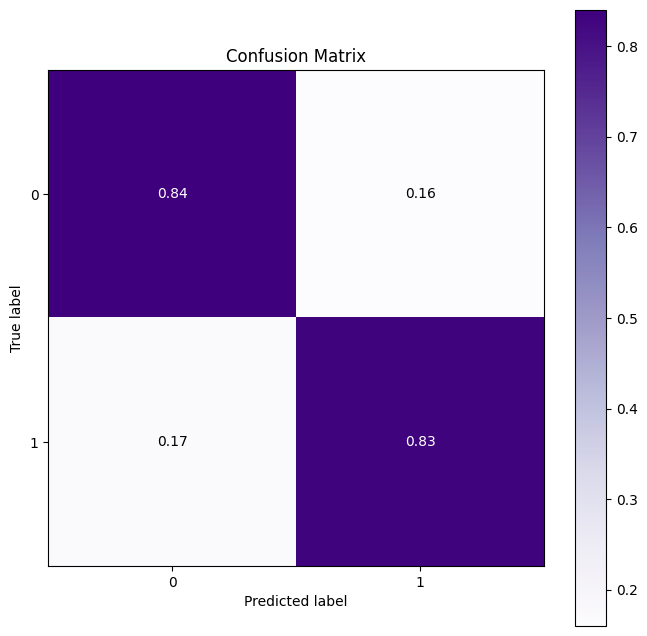

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
skplt.metrics.plot_confusion_matrix(y_test_pure, y_pred_pure,
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    ax=ax
                                    );
fig.savefig('confusion_matrix_LSTM_pure.png')

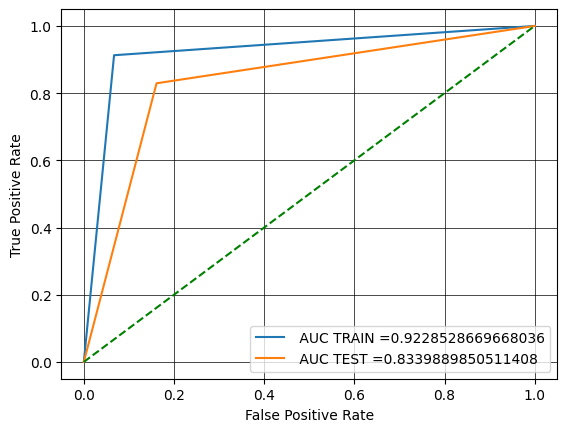

In [ ]:
from sklearn.metrics import roc_curve, auc
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_pure, y_pred_pure_train)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test_pure, y_pred_pure)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.savefig('roc_curve_LSTM_pure.png')

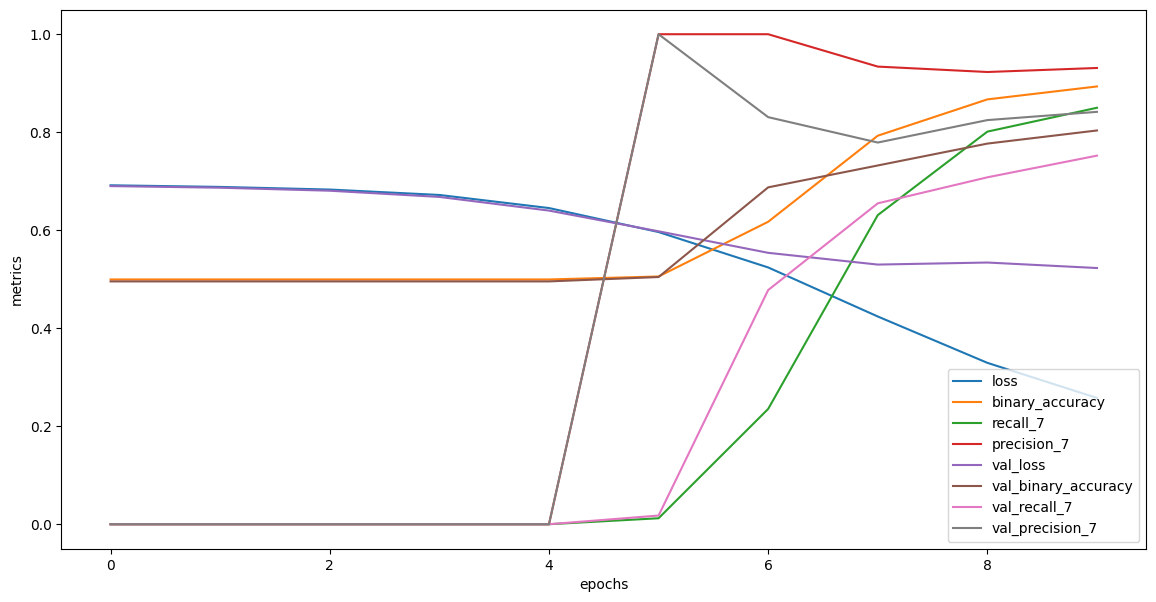

In [ ]:
pd.DataFrame(history_pure.history).plot(
    figsize=(14, 7),
    xlabel='epochs',
    ylabel='metrics'
)
plt.savefig("training_metrics_LSTM_pure.png")

## LSTM - PROMISE

In [ ]:
# Encode data
encoder_promise = tf.keras.layers.TextVectorization(max_tokens=1000)
encoder_promise.adapt(train_ds_promise.map(lambda text, label: text))
vocab_promise = np.array(encoder_promise.get_vocabulary())

# Create model
model_promise = tf.keras.Sequential([
    encoder_promise,
    tf.keras.layers.Embedding(
        input_dim=len(encoder_promise.get_vocabulary()),
        output_dim=64,
        mask_zero=True
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile model
model_promise.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=[BinaryAccuracy(), Recall(), Precision()]
)

In [ ]:
# Fit model
history_promise = model_promise.fit(
    train_ds_promise,
    epochs=10,
    validation_data=test_ds_promise,
    validation_steps=len(X_test_promise)//32 
)

Epoch 1/10
41/41 [==============================] - 19s 196ms/step - loss: 0.6927 - binary_accuracy: 0.5000 - recall_8: 0.0000e+00 - precision_8: 0.0000e+00 - val_loss: 0.6906 - val_binary_accuracy: 0.5031 - val_recall_8: 0.0000e+00 - val_precision_8: 0.0000e+00
Epoch 2/10
41/41 [==============================] - 1s 18ms/step - loss: 0.6888 - binary_accuracy: 0.5000 - recall_8: 0.0000e+00 - precision_8: 0.0000e+00 - val_loss: 0.6846 - val_binary_accuracy: 0.5031 - val_recall_8: 0.0000e+00 - val_precision_8: 0.0000e+00
Epoch 3/10
41/41 [==============================] - 1s 17ms/step - loss: 0.6774 - binary_accuracy: 0.5000 - recall_8: 0.0000e+00 - precision_8: 0.0000e+00 - val_loss: 0.6643 - val_binary_accuracy: 0.5031 - val_recall_8: 0.0000e+00 - val_precision_8: 0.0000e+00
Epoch 4/10
41/41 [==============================] - 1s 21ms/step - loss: 0.6312 - binary_accuracy: 0.5816 - recall_8: 0.1680 - precision_8: 0.9730 - val_loss: 0.5803 - val_binary_accuracy: 0.7719 - val_recall_8: 0.6

In [ ]:
# Predict and print metrics
y_pred_promise = model_promise.predict(test_ds_promise)
y_pred_promise = np.where(y_pred_promise > 0.0, 1, 0)

print(classification_report(y_test_promise, y_pred_promise)) 

11/11 [==============================] - 2s 7ms/step
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       161
           1       0.95      0.91      0.93       161

    accuracy                           0.93       322
   macro avg       0.93      0.93      0.93       322
weighted avg       0.93      0.93      0.93       322



In [ ]:
y_pred_promise_train = model_promise.predict(train_ds_promise)
y_pred_promise_train = np.where(y_pred_promise_train > 0.0, 1, 0)

41/41 [==============================] - 0s 6ms/step


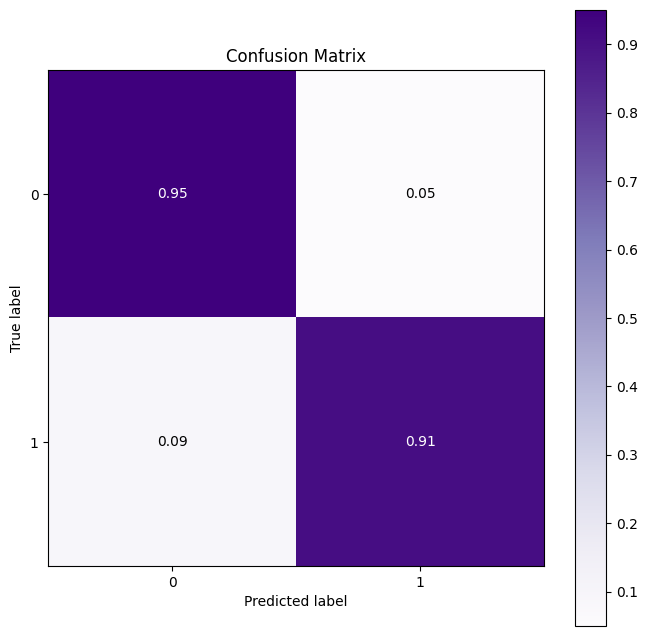

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
skplt.metrics.plot_confusion_matrix(y_test_promise, y_pred_promise,
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    ax=ax
                                    );
fig.savefig('confusion_matrix_LSTM_promise.png')

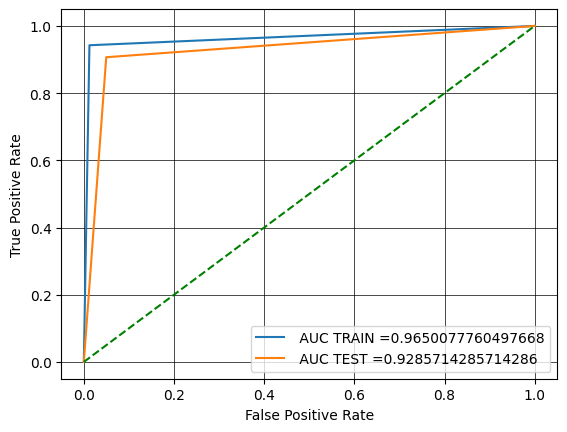

In [ ]:
from sklearn.metrics import roc_curve, auc
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_promise, y_pred_promise_train)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test_promise, y_pred_promise)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.savefig('roc_curve_LSTM_promise.png')

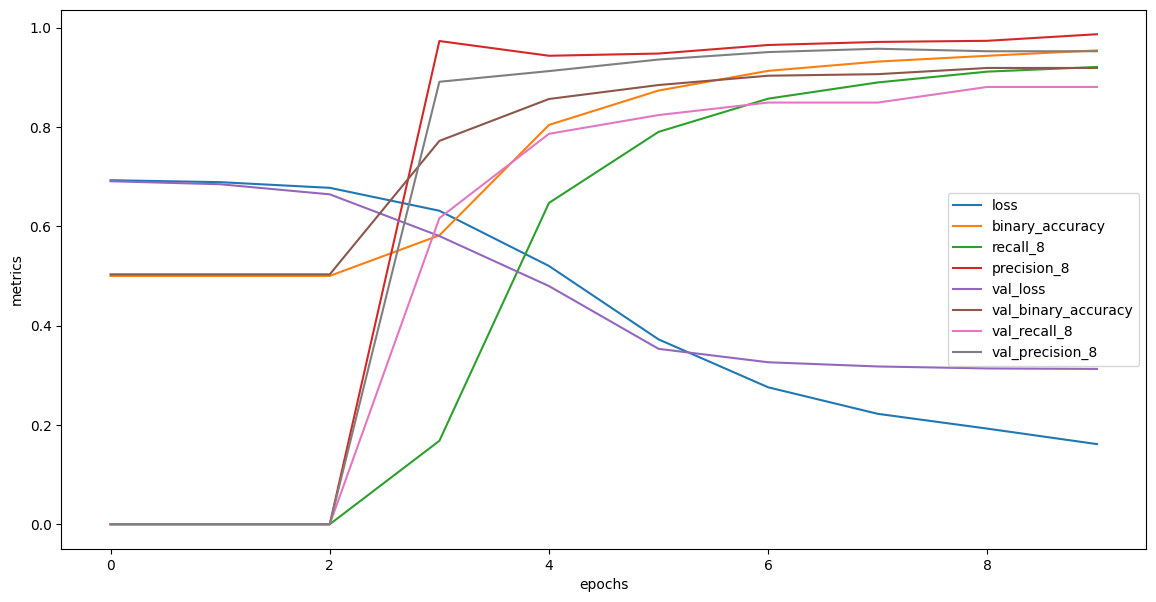

In [ ]:
pd.DataFrame(history_promise.history).plot(
    figsize=(14, 7),
    xlabel='epochs',
    ylabel='metrics'
)
plt.savefig("training_metrics_LSTM_promise.png")

## LSTM - External - Title

In [ ]:
# Encode data
encoder_external_title = tf.keras.layers.TextVectorization(max_tokens=1000)
encoder_external_title.adapt(train_ds_external_title.map(lambda text, label: text))
vocab_external_title = np.array(encoder_external_title.get_vocabulary())

# Create model
model_external_title = tf.keras.Sequential([
    encoder_external_title,
    tf.keras.layers.Embedding(
        input_dim=len(encoder_external_title.get_vocabulary()),
        output_dim=64,
        mask_zero=True
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile model
model_external_title.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=[BinaryAccuracy(), Recall(), Precision()]
)

In [ ]:
# Fit model
history_external_title = model_external_title.fit(
    train_ds_external_title,
    epochs=10,
    validation_data=test_ds_external_title,
    validation_steps=30
)

Epoch 1/10
314/314 [==============================] - 28s 56ms/step - loss: 0.6555 - binary_accuracy: 0.5233 - recall_4: 0.0485 - precision_4: 0.9643 - val_loss: 0.5543 - val_binary_accuracy: 0.7042 - val_recall_4: 0.3417 - val_precision_4: 0.8608
Epoch 2/10
314/314 [==============================] - 4s 13ms/step - loss: 0.3085 - binary_accuracy: 0.8602 - recall_4: 0.7539 - precision_4: 0.9574 - val_loss: 0.4397 - val_binary_accuracy: 0.8177 - val_recall_4: 0.6457 - val_precision_4: 0.8832
Epoch 3/10
314/314 [==============================] - 6s 18ms/step - loss: 0.2301 - binary_accuracy: 0.9026 - recall_4: 0.8329 - precision_4: 0.9678 - val_loss: 0.4202 - val_binary_accuracy: 0.8385 - val_recall_4: 0.6910 - val_precision_4: 0.8958
Epoch 4/10
314/314 [==============================] - 4s 14ms/step - loss: 0.2057 - binary_accuracy: 0.9142 - recall_4: 0.8538 - precision_4: 0.9712 - val_loss: 0.4138 - val_binary_accuracy: 0.8427 - val_recall_4: 0.7111 - val_precision_4: 0.8871
Epoch 5/10


In [ ]:
# Predict and print metrics
y_pred_external_title = model_external_title.predict(test_ds_external_title)
y_pred_external_title = np.where(y_pred_external_title > 0.0, 1, 0)

print(classification_report(y_test_external_title, y_pred_external_title))

79/79 [==============================] - 2s 4ms/step
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1448
           1       0.82      0.78      0.80      1054

    accuracy                           0.83      2502
   macro avg       0.83      0.83      0.83      2502
weighted avg       0.83      0.83      0.83      2502



In [ ]:
y_pred_external_title_train = model_external_title.predict(train_ds_external_title)
y_pred_external_title_train = np.where(y_pred_external_title_train > 0.0, 1, 0)

314/314 [==============================] - 2s 6ms/step


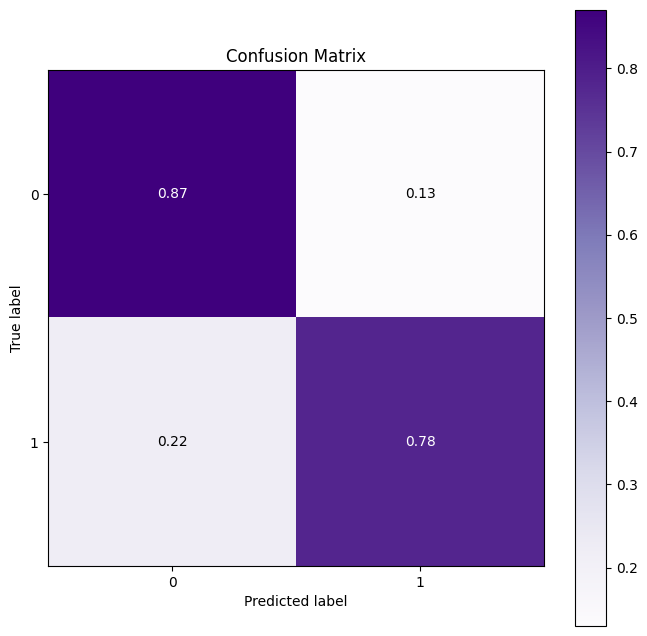

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
skplt.metrics.plot_confusion_matrix(y_test_external_title, y_pred_external_title,
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    ax=ax
                                    );
fig.savefig('confusion_matrix_LSTM_external_title.png')

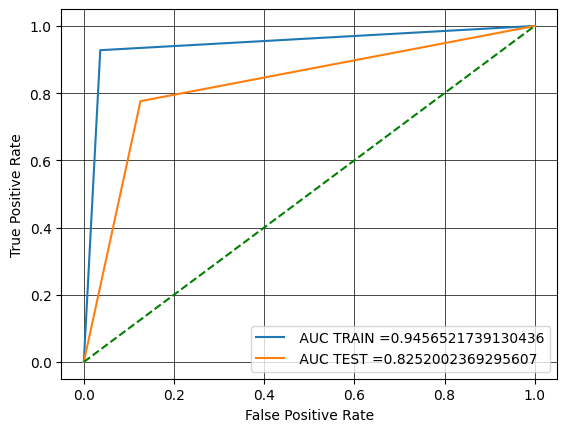

In [ ]:
from sklearn.metrics import roc_curve, auc
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_external_title, y_pred_external_title_train)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test_external_title, y_pred_external_title)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.savefig('roc_curve_LSTM_external_title.png')

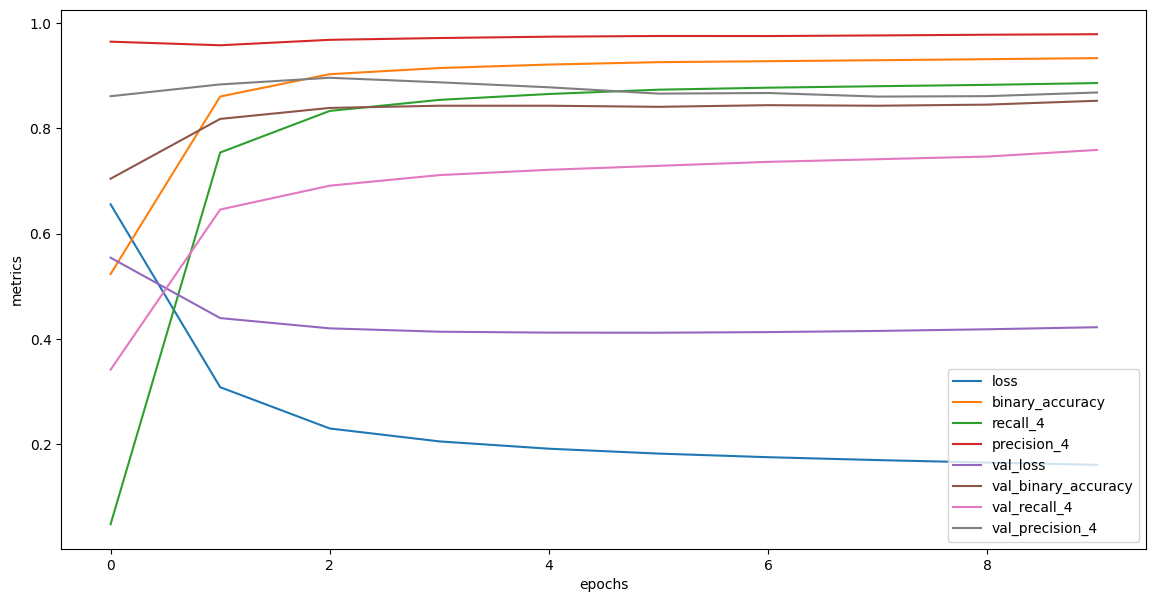

In [ ]:
pd.DataFrame(history_external_title.history).plot(
    figsize=(14, 7),
    xlabel='epochs',
    ylabel='metrics'
)
plt.savefig("training_metrics_LSTM_external_title.png")

## LSTM - External - Description


In [ ]:
# Encode data
encoder_external_description = tf.keras.layers.TextVectorization(max_tokens=1000)
encoder_external_description.adapt(train_ds_external_description.map(lambda text, label: text))
vocab_external_description = np.array(encoder_external_description.get_vocabulary())

# Create model
model_external_description = tf.keras.Sequential([
    encoder_external_description,
    tf.keras.layers.Embedding(
        input_dim=len(encoder_external_description.get_vocabulary()),
        output_dim=64,
        mask_zero=True
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile model
model_external_description.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=[BinaryAccuracy(), Recall(), Precision()]
)

In [ ]:
# Fit model
history_external_description = model_external_description.fit(
    train_ds_external_description,
    epochs=10,
    validation_data=test_ds_external_description,
    validation_steps=30
)

Epoch 1/10
314/314 [==============================] - 74s 192ms/step - loss: 0.6178 - binary_accuracy: 0.5865 - recall_3: 0.1891 - precision_3: 0.9213 - val_loss: 0.6008 - val_binary_accuracy: 0.6896 - val_recall_3: 0.3518 - val_precision_3: 0.7778
Epoch 2/10
314/314 [==============================] - 39s 126ms/step - loss: 0.3505 - binary_accuracy: 0.8463 - recall_3: 0.7515 - precision_3: 0.9274 - val_loss: 0.5389 - val_binary_accuracy: 0.7719 - val_recall_3: 0.6482 - val_precision_3: 0.7656
Epoch 3/10
314/314 [==============================] - 42s 134ms/step - loss: 0.2670 - binary_accuracy: 0.8925 - recall_3: 0.8416 - precision_3: 0.9369 - val_loss: 0.4867 - val_binary_accuracy: 0.7896 - val_recall_3: 0.6131 - val_precision_3: 0.8356
Epoch 4/10
314/314 [==============================] - 29s 92ms/step - loss: 0.2227 - binary_accuracy: 0.9104 - recall_3: 0.8698 - precision_3: 0.9466 - val_loss: 0.4868 - val_binary_accuracy: 0.8010 - val_recall_3: 0.6583 - val_precision_3: 0.8265
Epoch

In [ ]:
# Predict and print metrics
y_pred_external_description = model_external_description.predict(test_ds_external_description)
y_pred_external_description = np.where(y_pred_external_description > 0.0, 1, 0)

print(classification_report(y_test_external_description, y_pred_external_description))

79/79 [==============================] - 6s 27ms/step
              precision    recall  f1-score   support

           0       0.82      0.83      0.82      1448
           1       0.76      0.75      0.75      1054

    accuracy                           0.79      2502
   macro avg       0.79      0.79      0.79      2502
weighted avg       0.79      0.79      0.79      2502



In [ ]:
y_pred_external_description_train = model_external_description.predict(train_ds_external_description)
y_pred_external_description_train = np.where(y_pred_external_description_train > 0.0, 1, 0)

314/314 [==============================] - 8s 26ms/step


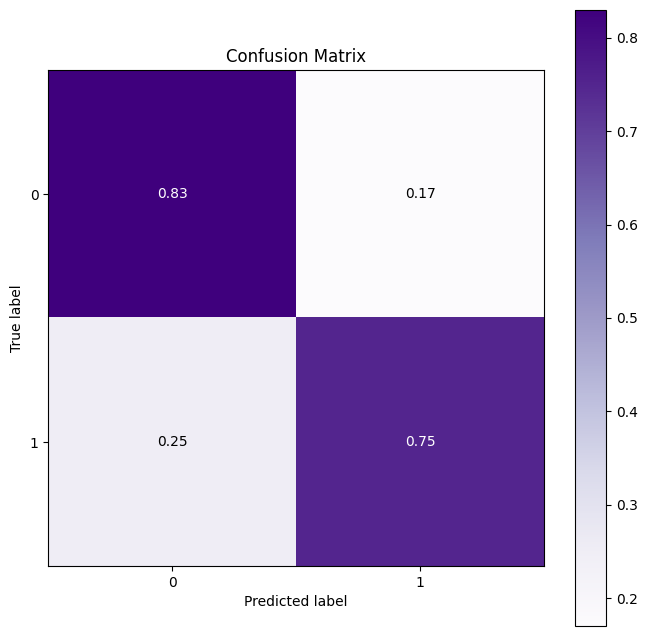

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
skplt.metrics.plot_confusion_matrix(y_test_external_description, y_pred_external_description,
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    ax=ax
                                    );
fig.savefig('confusion_matrix_LSTM_external_description.png')

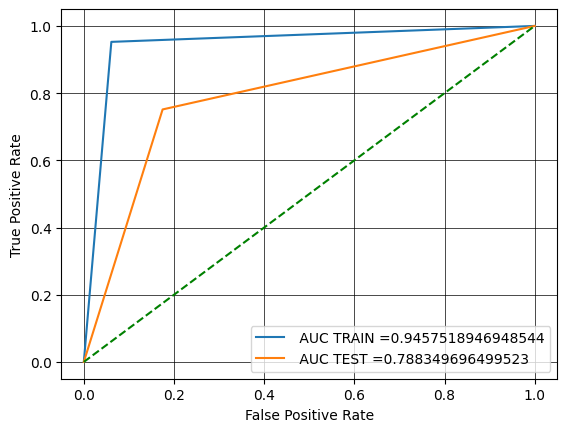

In [ ]:
from sklearn.metrics import roc_curve, auc
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_external_description, y_pred_external_description_train)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test_external_description, y_pred_external_description)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.savefig('roc_curve_LSTM_external_description.png')

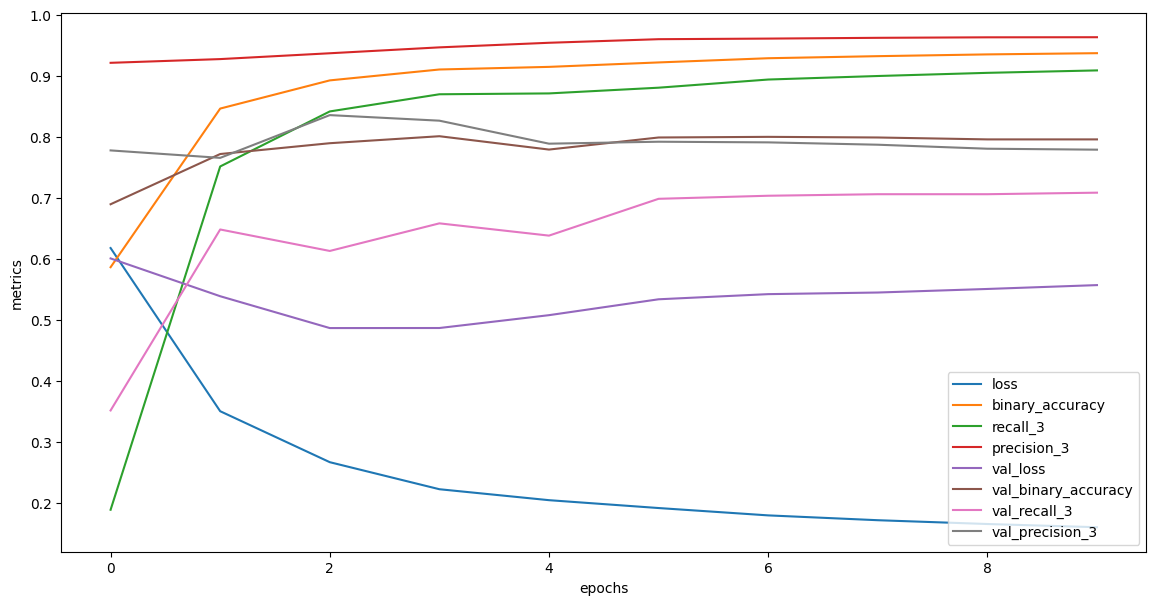

In [ ]:
pd.DataFrame(history_external_description.history).plot(
    figsize=(14, 7),
    xlabel='epochs',
    ylabel='metrics'
)
plt.savefig("training_metrics_LSTM_external_description.png")

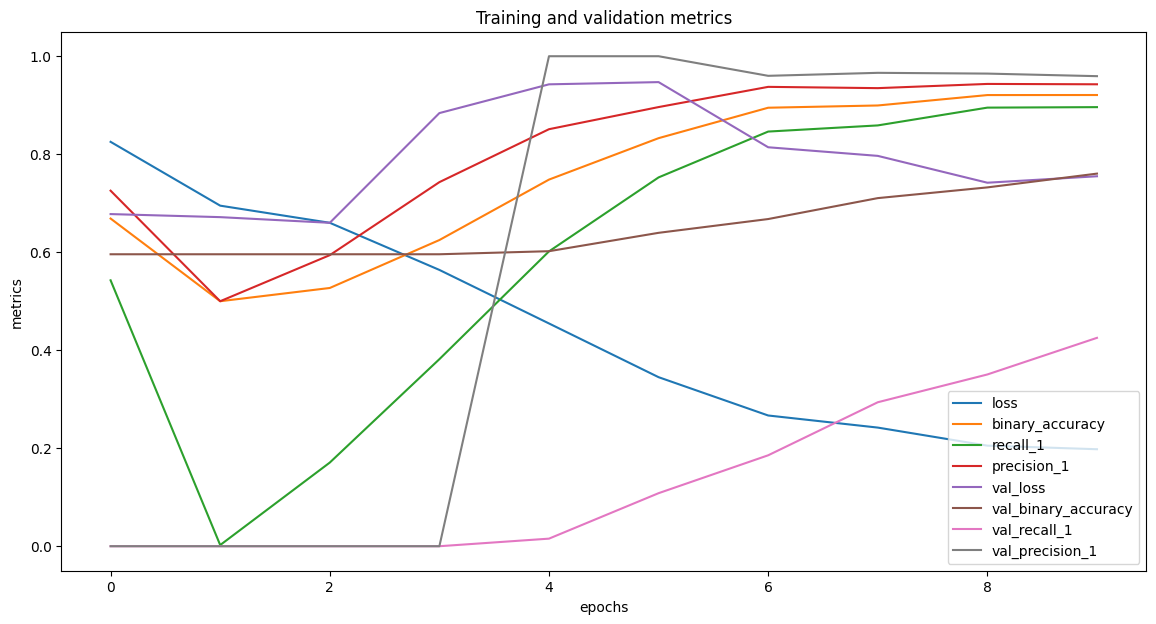

In [ ]:
pd.DataFrame(history_external_description.history).plot(
    figsize=(14, 7),
    xlabel='epochs',
    ylabel='metrics',
    title='Training and validation metrics'
)
plt.show()

## LSTM - Non-External - Title

In [ ]:
# Encode data
encoder_title = tf.keras.layers.TextVectorization(max_tokens=1000)
encoder_title.adapt(train_ds_title.map(lambda text, label: text))
vocab_title = np.array(encoder_title.get_vocabulary())

# Create model
model_title = tf.keras.Sequential([
    encoder_title,
    tf.keras.layers.Embedding(
        input_dim=len(encoder_title.get_vocabulary()),
        output_dim=64,
        mask_zero=True
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile model
model_title.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=[BinaryAccuracy(), Recall(), Precision()]
)

In [ ]:
# Fit model
history_title = model_title.fit(
    train_ds_title,
    epochs=10,
    validation_data=test_ds_title,
    validation_steps=30
)

Epoch 1/10
304/304 [==============================] - 25s 45ms/step - loss: 0.6546 - binary_accuracy: 0.5293 - recall_9: 0.0602 - precision_9: 0.9733 - val_loss: 0.5067 - val_binary_accuracy: 0.7385 - val_recall_9: 0.4946 - val_precision_9: 0.9390
Epoch 2/10
304/304 [==============================] - 5s 16ms/step - loss: 0.3359 - binary_accuracy: 0.8443 - recall_9: 0.7227 - precision_9: 0.9548 - val_loss: 0.3449 - val_binary_accuracy: 0.8562 - val_recall_9: 0.7687 - val_precision_9: 0.9229
Epoch 3/10
304/304 [==============================] - 4s 13ms/step - loss: 0.2523 - binary_accuracy: 0.8889 - recall_9: 0.8094 - precision_9: 0.9623 - val_loss: 0.3259 - val_binary_accuracy: 0.8677 - val_recall_9: 0.7859 - val_precision_9: 0.9315
Epoch 4/10
304/304 [==============================] - 5s 15ms/step - loss: 0.2239 - binary_accuracy: 0.9016 - recall_9: 0.8323 - precision_9: 0.9663 - val_loss: 0.3216 - val_binary_accuracy: 0.8729 - val_recall_9: 0.8051 - val_precision_9: 0.9238
Epoch 5/10


In [ ]:
# Predict and print metrics
y_pred_title = model_title.predict(test_ds_title)
y_pred_title = np.where(y_pred_title > 0.0, 1, 0)

print(classification_report(y_test_title, y_pred_title))

76/76 [==============================] - 2s 4ms/step
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      1214
           1       0.88      0.87      0.88      1214

    accuracy                           0.88      2428
   macro avg       0.88      0.88      0.88      2428
weighted avg       0.88      0.88      0.88      2428



In [ ]:
y_pred_title_train = model_title.predict(train_ds_title)
y_pred_title_train = np.where(y_pred_title_train > 0.0, 1, 0)

304/304 [==============================] - 2s 6ms/step


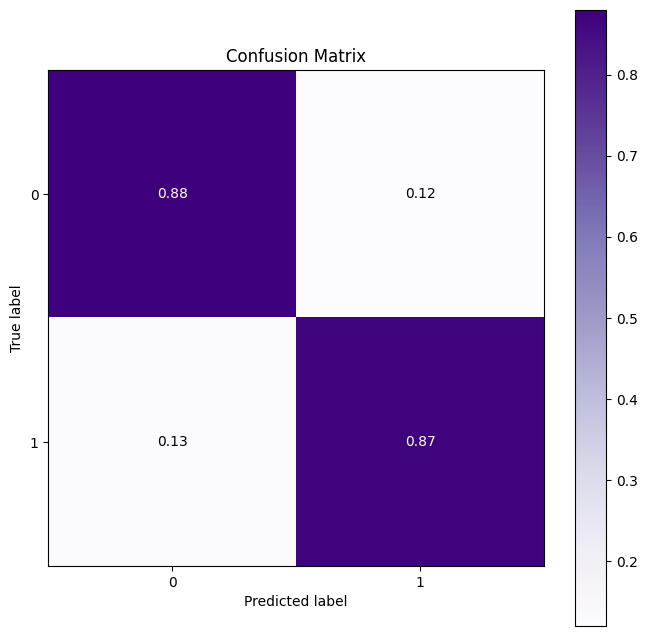

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
skplt.metrics.plot_confusion_matrix(y_test_title, y_pred_title,
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    ax=ax
                                    );
fig.savefig('confusion_matrix_LSTM_title.png')

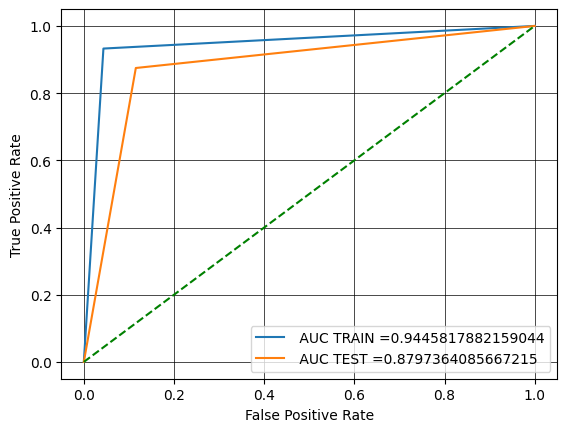

In [ ]:
from sklearn.metrics import roc_curve, auc
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_title, y_pred_title_train)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test_title, y_pred_title)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.savefig('roc_curve_LSTM_title.png')

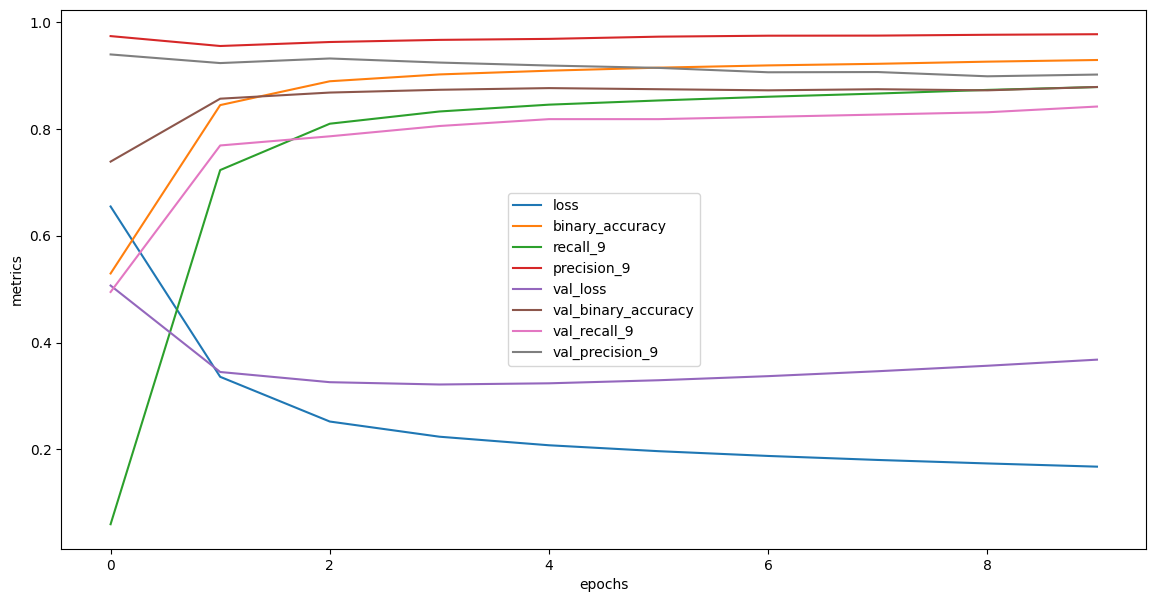

In [ ]:
pd.DataFrame(history_title.history).plot(
    figsize=(14, 7),
    xlabel='epochs',
    ylabel='metrics'
)
plt.savefig("training_metrics_LSTM_title.png")

## LSTM - Non-External - Description

In [ ]:
# Encode data
encoder_description = tf.keras.layers.TextVectorization(max_tokens=1000)
encoder_description.adapt(train_ds_description.map(lambda text, label: text))
vocab_description = np.array(encoder_description.get_vocabulary())

# Create model
model_description = tf.keras.Sequential([
    encoder_description,
    tf.keras.layers.Embedding(
        input_dim=len(encoder_description.get_vocabulary()),
        output_dim=64,
        mask_zero=True
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile model
model_description.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=[BinaryAccuracy(), Recall(), Precision()]
)

In [ ]:
# Fit model
history_description = model_description.fit(
    train_ds_description,
    epochs=10,
    validation_data=test_ds_description,
    validation_steps=30
)

Epoch 1/10
304/304 [==============================] - 105s 292ms/step - loss: 0.6518 - binary_accuracy: 0.5474 - recall_1: 0.1088 - precision_1: 0.8859 - val_loss: 0.6268 - val_binary_accuracy: 0.7802 - val_recall_1: 0.7944 - val_precision_1: 0.7634
Epoch 2/10
304/304 [==============================] - 21s 71ms/step - loss: 0.4386 - binary_accuracy: 0.7818 - recall_1: 0.6568 - precision_1: 0.8758 - val_loss: 0.3697 - val_binary_accuracy: 0.8521 - val_recall_1: 0.7730 - val_precision_1: 0.9093
Epoch 3/10
304/304 [==============================] - 25s 83ms/step - loss: 0.3394 - binary_accuracy: 0.8505 - recall_1: 0.7616 - precision_1: 0.9263 - val_loss: 0.3307 - val_binary_accuracy: 0.8583 - val_recall_1: 0.7944 - val_precision_1: 0.9027
Epoch 4/10
304/304 [==============================] - 22s 72ms/step - loss: 0.2801 - binary_accuracy: 0.8827 - recall_1: 0.8175 - precision_1: 0.9401 - val_loss: 0.2911 - val_binary_accuracy: 0.8792 - val_recall_1: 0.8266 - val_precision_1: 0.9169
Epoch 

In [ ]:
# Predict and print metrics
y_pred_description = model_description.predict(test_ds_description)
y_pred_description = np.where(y_pred_description > 0.0, 1, 0)

print(classification_report(y_test_description, y_pred_description))

76/76 [==============================] - 4s 28ms/step
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      1214
           1       0.91      0.87      0.89      1214

    accuracy                           0.89      2428
   macro avg       0.89      0.89      0.89      2428
weighted avg       0.89      0.89      0.89      2428



In [ ]:
y_pred_description_train = model_description.predict(train_ds_description)
y_pred_description_train = np.where(y_pred_description_train > 0.0, 1, 0)

304/304 [==============================] - 10s 32ms/step


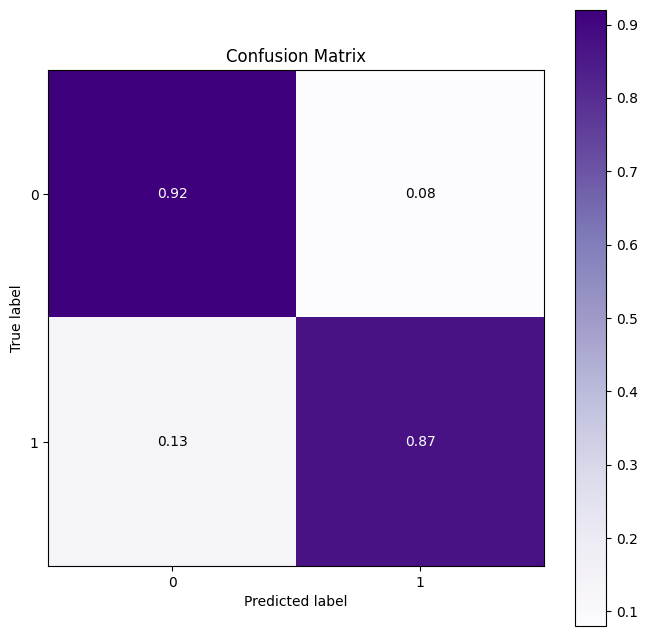

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
skplt.metrics.plot_confusion_matrix(y_test_description, y_pred_description,
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    ax=ax
                                    );
fig.savefig('confusion_matrix_LSTM_description.png')

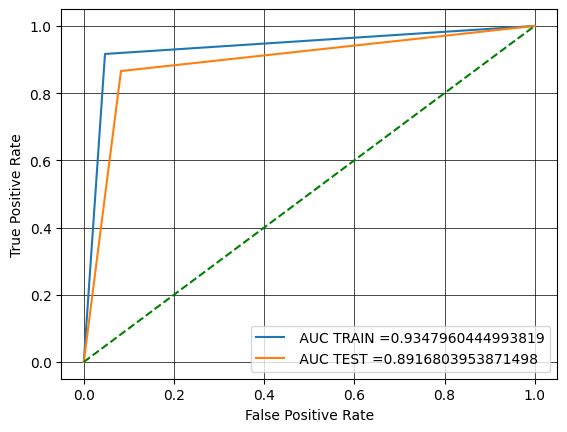

In [ ]:
from sklearn.metrics import roc_curve, auc
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_description, y_pred_description_train)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test_description, y_pred_description)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.savefig('roc_curve_LSTM_description.png')

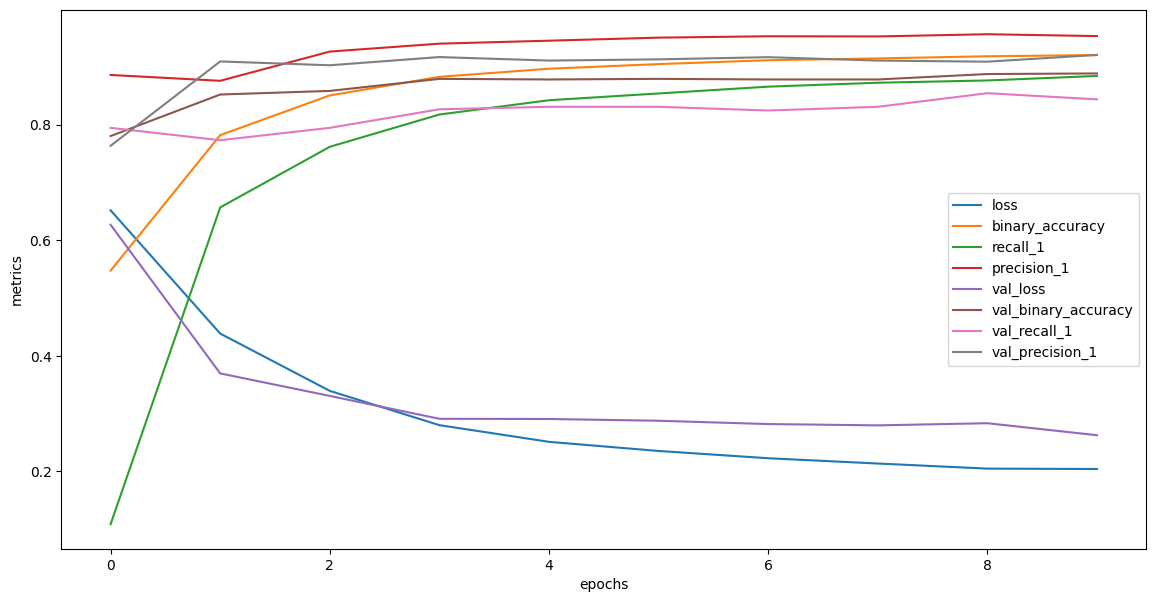

In [ ]:
pd.DataFrame(history_description.history).plot(
    figsize=(14, 7),
    xlabel='epochs',
    ylabel='metrics'
)
plt.savefig("training_metrics_LSTM_description.png")

## LSTM - Combined

In [ ]:
# Encode data
encoder_combined = tf.keras.layers.TextVectorization(max_tokens=1000)
encoder_combined.adapt(train_ds_combined.map(lambda text, label: text))
vocab_combined = np.array(encoder_combined.get_vocabulary())

# Create model
model_combined = tf.keras.Sequential([
    encoder_combined,
    tf.keras.layers.Embedding(
        input_dim=len(encoder_combined.get_vocabulary()),
        output_dim=64,
        mask_zero=True
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile model
model_combined.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=[BinaryAccuracy(), Recall(), Precision()]
)

In [ ]:
# Fit model
history_combined = model_combined.fit(
    train_ds_combined,
    epochs=10,
    validation_data=test_ds_combined,
    validation_steps=len(X_test_combined)//32 
)

Epoch 1/10
93/93 [==============================] - 40s 255ms/step - loss: 0.6921 - binary_accuracy: 0.5000 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.6900 - val_binary_accuracy: 0.4986 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/10
93/93 [==============================] - 3s 28ms/step - loss: 0.6842 - binary_accuracy: 0.5000 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.6731 - val_binary_accuracy: 0.4986 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/10
93/93 [==============================] - 2s 20ms/step - loss: 0.6106 - binary_accuracy: 0.5731 - recall: 0.1590 - precision: 0.9252 - val_loss: 0.5519 - val_binary_accuracy: 0.7065 - val_recall: 0.5122 - val_precision: 0.8400
Epoch 4/10
93/93 [==============================] - 2s 17ms/step - loss: 0.4713 - binary_accuracy: 0.7585 - recall: 0.5670 - precision: 0.9189 - val_loss: 0.4565 - val_binary_accuracy: 0.7636 - val_recall: 0.6016 - val_precision: 0.8916
Epoch 5/10
93/93 [

In [ ]:
# Predict and print metrics
y_pred_combined = model_combined.predict(test_ds_combined)
y_pred_combined = np.where(y_pred_combined > 0.0, 1, 0)

print(classification_report(y_test_combined, y_pred_combined))

24/24 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       370
           1       0.85      0.82      0.84       370

    accuracy                           0.84       740
   macro avg       0.84      0.84      0.84       740
weighted avg       0.84      0.84      0.84       740



In [ ]:
y_pred_combined_train = model_combined.predict(train_ds_combined)
y_pred_combined_train = np.where(y_pred_combined_train > 0.0, 1, 0)

93/93 [==============================] - 1s 7ms/step


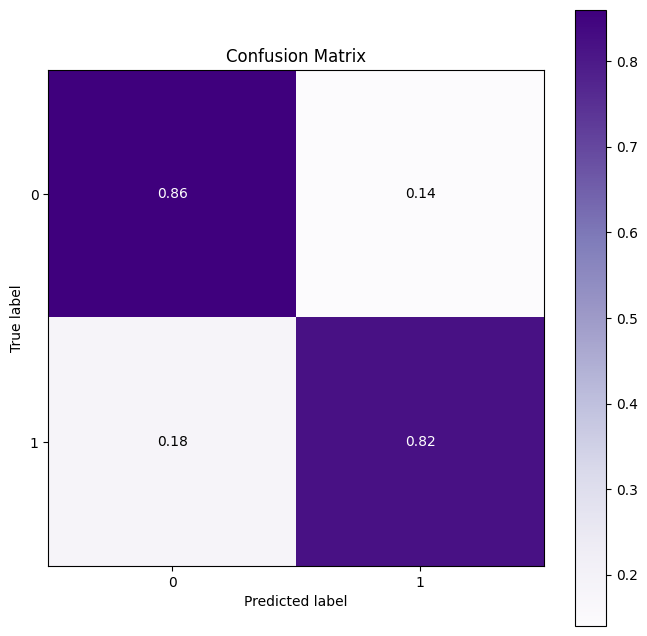

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
skplt.metrics.plot_confusion_matrix(y_test_combined, y_pred_combined,
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    ax=ax
                                    );
fig.savefig('confusion_matrix_LSTM_combined.png')

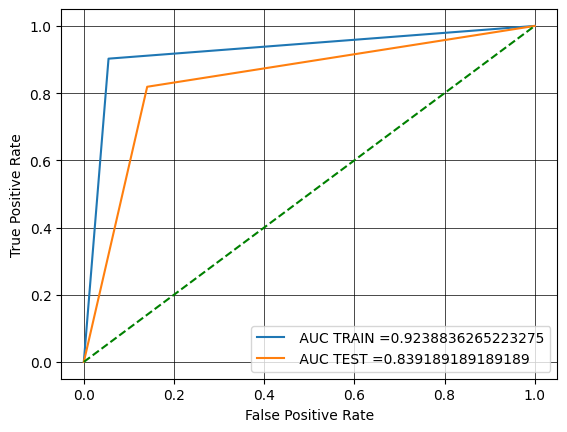

In [ ]:
from sklearn.metrics import roc_curve, auc
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_combined, y_pred_combined_train)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test_combined, y_pred_combined)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.savefig('roc_curve_LSTM_combined.png')

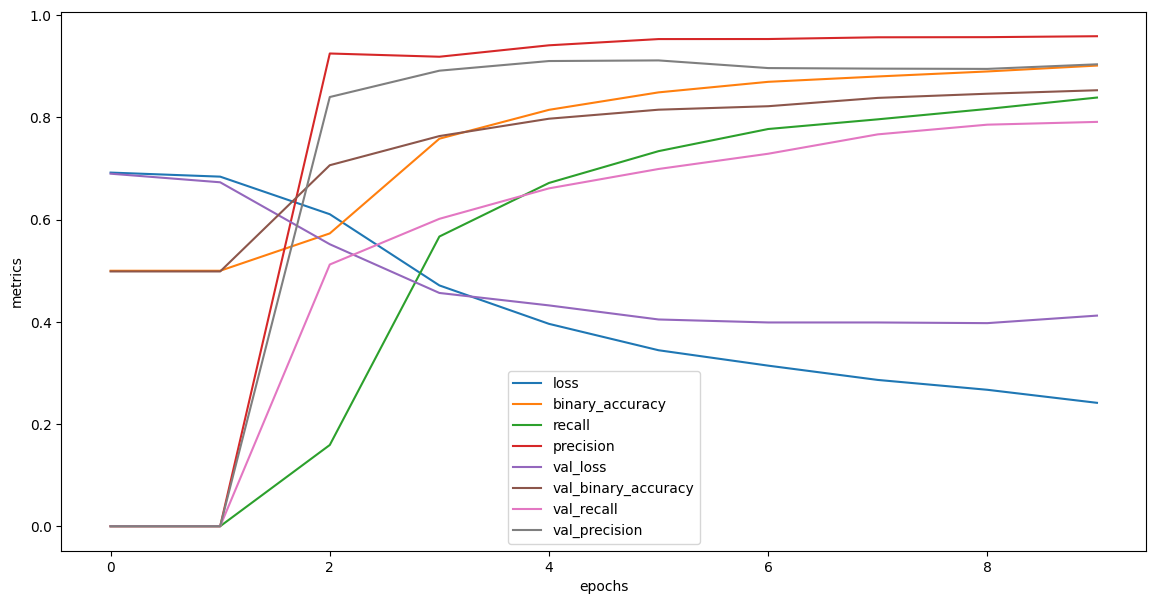

In [ ]:
pd.DataFrame(history_combined.history).plot(
    figsize=(14, 7),
    xlabel='epochs',
    ylabel='metrics'
)
plt.savefig("training_metrics_LSTM_combined.png")

# SmallBERT

In [ ]:
def build_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
        name='preprocessing'
    )
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1",
        trainable=True,
        name='BERT_encoder'
    )
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()
epochs = 10
init_lr = 3e-5

## SmallBERT - PURE

In [ ]:
model_pure = build_model()

steps_per_epoch_pure = tf.data.experimental.cardinality(train_ds_pure).numpy()
num_train_steps_pure = steps_per_epoch_pure * 10
num_warmup_steps_pure = int(0.1*num_train_steps_pure)


optimizer_pure = optimization.create_optimizer(
    init_lr=init_lr,
    num_train_steps=num_train_steps_pure,
    num_warmup_steps=num_warmup_steps_pure,
    optimizer_type='adamw'
)
model_pure.compile(
    optimizer=optimizer_pure,
    loss=loss,
    metrics=metrics
)

In [ ]:
history_pure = model_pure.fit(
    x=train_ds_pure,
    validation_data=test_ds_pure,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=2, restore_best_weights=True
        )
    ]
)

Epoch 1/10
31/31 [==============================] - 15s 286ms/step - loss: 0.8096 - binary_accuracy: 0.5852 - val_loss: 0.5467 - val_binary_accuracy: 0.7004
Epoch 2/10
31/31 [==============================] - 8s 249ms/step - loss: 0.5051 - binary_accuracy: 0.7431 - val_loss: 0.3682 - val_binary_accuracy: 0.8502
Epoch 3/10
31/31 [==============================] - 8s 257ms/step - loss: 0.3669 - binary_accuracy: 0.8345 - val_loss: 0.3284 - val_binary_accuracy: 0.8502
Epoch 4/10
31/31 [==============================] - 10s 324ms/step - loss: 0.2683 - binary_accuracy: 0.8832 - val_loss: 0.3174 - val_binary_accuracy: 0.8785
Epoch 5/10
31/31 [==============================] - 8s 246ms/step - loss: 0.1966 - binary_accuracy: 0.9239 - val_loss: 0.3710 - val_binary_accuracy: 0.8543
Epoch 6/10
31/31 [==============================] - 8s 254ms/step - loss: 0.1719 - binary_accuracy: 0.9320 - val_loss: 0.3354 - val_binary_accuracy: 0.8664


In [ ]:
y_pred_pure = model_pure.predict(test_ds_pure)
y_pred_pure = np.where(y_pred_pure > 0.0, 1, 0)

print(classification_report(y_test_pure, y_pred_pure))

8/8 [==============================] - 2s 150ms/step
              precision    recall  f1-score   support

           0       0.93      0.80      0.86       124
           1       0.82      0.94      0.88       123

    accuracy                           0.87       247
   macro avg       0.88      0.87      0.87       247
weighted avg       0.88      0.87      0.87       247



In [ ]:
y_pred_pure_2 = model_pure.predict(test_ds_title)
y_pred_pure_2 = np.where(y_pred_pure_2 > 0.0, 1, 0)

print(classification_report(y_test_title, y_pred_pure_2))

76/76 [==============================] - 8s 102ms/step
              precision    recall  f1-score   support

           0       0.64      0.89      0.74      1214
           1       0.82      0.51      0.63      1214

    accuracy                           0.70      2428
   macro avg       0.73      0.70      0.69      2428
weighted avg       0.73      0.70      0.69      2428



In [ ]:
y_pred_pure_3 = model_pure.predict(test_ds_external_title)
y_pred_pure_3 = np.where(y_pred_pure_3 > 0.0, 1, 0)

print(classification_report(y_test_external_title, y_pred_pure_3))

79/79 [==============================] - 9s 109ms/step
              precision    recall  f1-score   support

           0       0.72      0.86      0.79      1449
           1       0.74      0.55      0.63      1055

    accuracy                           0.73      2504
   macro avg       0.73      0.71      0.71      2504
weighted avg       0.73      0.73      0.72      2504



In [ ]:
examples = [
    sec_sample_issue["issue_title"],
    nonsec_sample_issue["issue_title"]    
]
a = model_pure.predict(tf.constant(examples))
a = np.where(a > 0.0, 1, 0)
print(a)


1/1 [==============================] - 0s 104ms/step
[[1]
 [0]]


In [ ]:
model_pure.save('pure_smallbert_L4_H512_A8', include_optimizer=False)

In [ ]:
y_pred_pure_train = model_pure.predict(train_ds_pure)
y_pred_pure_train = np.where(y_pred_pure_train > 0.0, 1, 0)

31/31 [==============================] - 7s 235ms/step


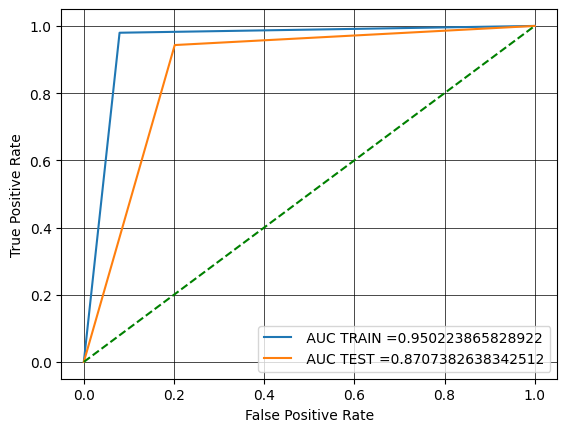

In [ ]:
from sklearn.metrics import roc_curve, auc
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_pure, y_pred_pure_train)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test_pure, y_pred_pure)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.savefig('roc_curve_BERT_pure.png')

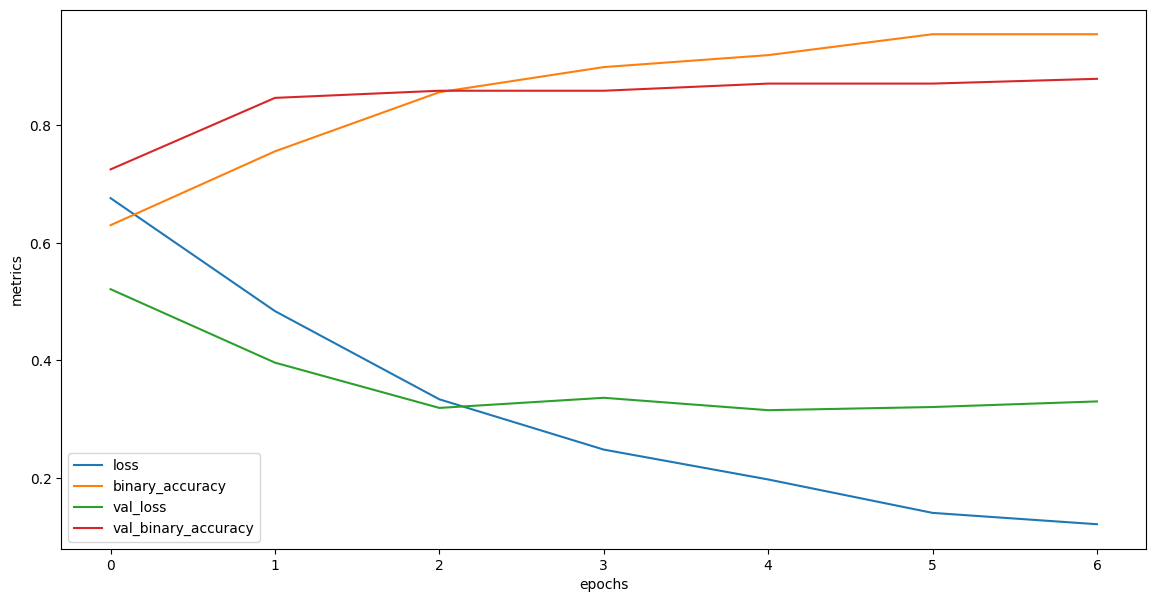

In [ ]:
pd.DataFrame(history_pure.history).plot(
    figsize=(14, 7),
    xlabel='epochs',
    ylabel='metrics'
)
plt.savefig("training_metrics_BERT_pure.png")

## SmallBERT - PROMISE

In [ ]:
model_promise = build_model()

steps_per_epoch_promise = tf.data.experimental.cardinality(train_ds_promise).numpy()
num_train_steps_promise = steps_per_epoch_promise * epochs
num_warmup_steps_promise = int(0.1*num_train_steps_promise)


optimizer_promise = optimization.create_optimizer(
    init_lr=init_lr,
    num_train_steps=num_train_steps_promise,
    num_warmup_steps=num_warmup_steps_promise,
    optimizer_type='adamw'
)
model_promise.compile(
    optimizer=optimizer_promise,
    loss=loss,
    metrics=metrics
)

In [ ]:
history_promise = model_promise.fit(
    x=train_ds_promise,
    validation_data=test_ds_promise,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=2, restore_best_weights=True
        )
    ]
)

Epoch 1/5
41/41 [==============================] - 21s 300ms/step - loss: 0.5101 - binary_accuracy: 0.8484 - val_loss: 0.2848 - val_binary_accuracy: 0.8758
Epoch 2/5
41/41 [==============================] - 11s 270ms/step - loss: 0.2630 - binary_accuracy: 0.8779 - val_loss: 0.2090 - val_binary_accuracy: 0.9379
Epoch 3/5
41/41 [==============================] - 16s 394ms/step - loss: 0.1733 - binary_accuracy: 0.9238 - val_loss: 0.1856 - val_binary_accuracy: 0.9441
Epoch 4/5
41/41 [==============================] - 14s 338ms/step - loss: 0.1294 - binary_accuracy: 0.9495 - val_loss: 0.1841 - val_binary_accuracy: 0.9472
Epoch 5/5
41/41 [==============================] - 12s 281ms/step - loss: 0.0989 - binary_accuracy: 0.9658 - val_loss: 0.1825 - val_binary_accuracy: 0.9472


In [ ]:
y_pred_promise = model_promise.predict(test_ds_promise)
y_pred_promise = np.where(y_pred_promise > 0.0, 1, 0)

print(classification_report(y_test_promise, y_pred_promise))

11/11 [==============================] - 1s 91ms/step
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       161
           1       0.93      0.96      0.95       161

    accuracy                           0.95       322
   macro avg       0.95      0.95      0.95       322
weighted avg       0.95      0.95      0.95       322



In [ ]:
y_pred_promise_2 = model_promise.predict(test_ds_title)
y_pred_promise_2 = np.where(y_pred_promise_2 > 0.0, 1, 0)

print(classification_report(y_test_title, y_pred_promise_2))

76/76 [==============================] - 8s 106ms/step
              precision    recall  f1-score   support

           0       0.63      0.56      0.59      1214
           1       0.60      0.67      0.63      1214

    accuracy                           0.61      2428
   macro avg       0.61      0.61      0.61      2428
weighted avg       0.61      0.61      0.61      2428



In [ ]:
y_pred_promise_3 = model_promise.predict(test_ds_external_title)
y_pred_promise_3 = np.where(y_pred_promise_3 > 0.0, 1, 0)

print(classification_report(y_test_external_title, y_pred_promise_3))

79/79 [==============================] - 11s 144ms/step
              precision    recall  f1-score   support

           0       0.72      0.56      0.63      1449
           1       0.53      0.70      0.60      1055

    accuracy                           0.62      2504
   macro avg       0.62      0.63      0.62      2504
weighted avg       0.64      0.62      0.62      2504



In [ ]:
examples = [
    sec_sample_issue["issue_title"],
    nonsec_sample_issue["issue_title"]    
]
a = model_promise.predict(tf.constant(examples))
a = np.where(a > 0.0, 1, 0)
print(a)

1/1 [==============================] - 2s 2s/step
[[1]
 [1]]


In [ ]:
model_promise.save('promise_smallbert_L4_H512_A8', include_optimizer=False)

In [ ]:
y_pred_promise_train = model_promise.predict(train_ds_promise)
y_pred_promise_train = np.where(y_pred_promise_train > 0.0, 1, 0)

41/41 [==============================] - 4s 101ms/step


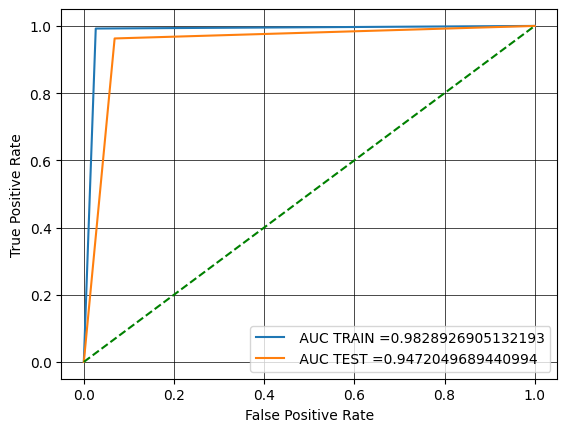

In [ ]:
from sklearn.metrics import roc_curve, auc
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_promise, y_pred_promise_train)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test_promise, y_pred_promise)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.savefig('roc_curve_BERT_promise.png')

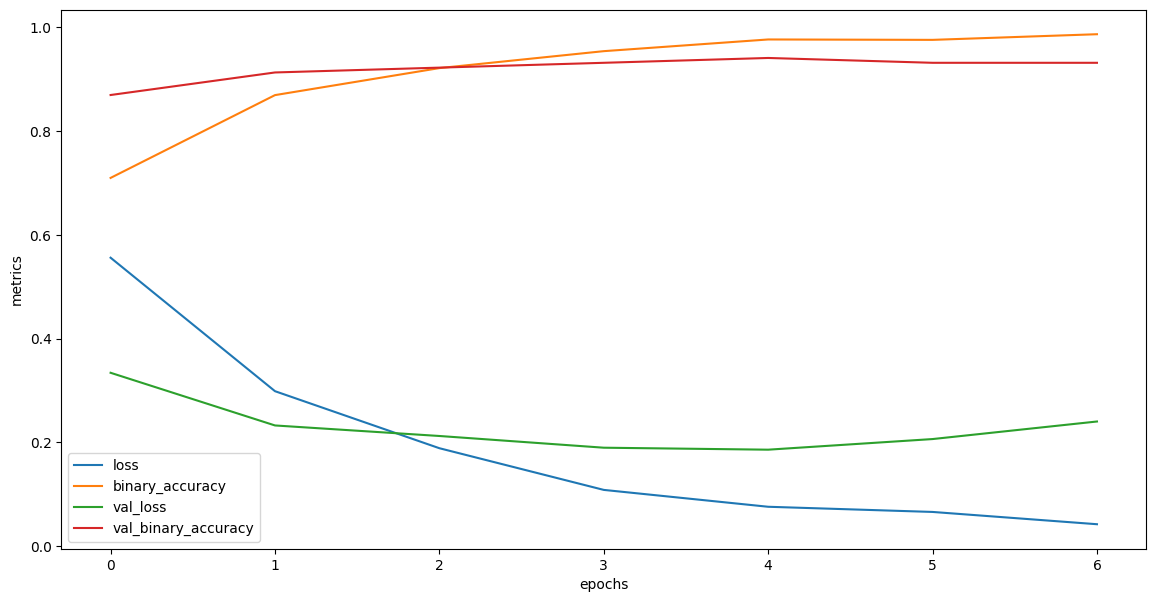

In [ ]:
pd.DataFrame(history_promise.history).plot(
    figsize=(14, 7),
    xlabel='epochs',
    ylabel='metrics'
)
plt.savefig("training_metrics_BERT_promise.png")

## SmallBERT - External - Title

In [ ]:
model_external_title = build_model()

steps_per_epoch_external_title = tf.data.experimental.cardinality(train_ds_external_title).numpy()
num_train_steps_external_title = steps_per_epoch_external_title * epochs
num_warmup_steps_external_title = int(0.1*num_train_steps_external_title)


optimizer_external_title = optimization.create_optimizer(
    init_lr=init_lr,
    num_train_steps=num_train_steps_external_title,
    num_warmup_steps=num_warmup_steps_external_title,
    optimizer_type='adamw'
)
model_external_title.compile(
    optimizer=optimizer_external_title,
    loss=loss,
    metrics=metrics
)

In [ ]:
history_external_title = model_external_title.fit(
    x=train_ds_external_title,
    validation_data=test_ds_external_title,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=2, restore_best_weights=True
        )
    ]
)

Epoch 1/5
314/314 [==============================] - 91s 260ms/step - loss: 0.4592 - binary_accuracy: 0.7512 - val_loss: 0.4365 - val_binary_accuracy: 0.8191
Epoch 2/5
314/314 [==============================] - 79s 251ms/step - loss: 0.2445 - binary_accuracy: 0.9011 - val_loss: 0.4011 - val_binary_accuracy: 0.8526
Epoch 3/5
314/314 [==============================] - 81s 257ms/step - loss: 0.1627 - binary_accuracy: 0.9361 - val_loss: 0.4137 - val_binary_accuracy: 0.8654
Epoch 4/5
314/314 [==============================] - 78s 247ms/step - loss: 0.1204 - binary_accuracy: 0.9531 - val_loss: 0.4681 - val_binary_accuracy: 0.8650


In [ ]:
examples = [
    sec_sample_issue["issue_title"],
    nonsec_sample_issue["issue_title"]    
]
a = model_external_title.predict(tf.constant(examples))
a = np.where(a > 0.0, 1, 0)
print(a)

1/1 [==============================] - 2s 2s/step
[[1]
 [0]]


In [ ]:
y_pred_external_title = model_external_title.predict(test_ds_external_title)
y_pred_external_title = np.where(y_pred_external_title > 0.0, 1, 0)

print(classification_report(y_test_external_title, y_pred_external_title))

79/79 [==============================] - 15s 193ms/step
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      1448
           1       0.82      0.83      0.82      1054

    accuracy                           0.85      2502
   macro avg       0.85      0.85      0.85      2502
weighted avg       0.85      0.85      0.85      2502



In [ ]:
y_pred_external_title_2 = model_external_title.predict(train_ds_promise)
y_pred_external_title_2 = np.where(y_pred_external_title_2 > 0.0, 1, 0)

print(classification_report(y_train_promise, y_pred_external_title_2))

41/41 [==============================] - 6s 149ms/step
              precision    recall  f1-score   support

           0       0.92      0.24      0.38       643
           1       0.56      0.98      0.71       643

    accuracy                           0.61      1286
   macro avg       0.74      0.61      0.55      1286
weighted avg       0.74      0.61      0.55      1286



In [ ]:
model_external_title.save('external_title_smallbert_L4_H512_A8', include_optimizer=False)

In [ ]:
y_pred_external_title_train = model_external_title.predict(train_ds_external_title)
y_pred_external_title_train = np.where(y_pred_external_title_train > 0.0, 1, 0)

314/314 [==============================] - 44s 139ms/step


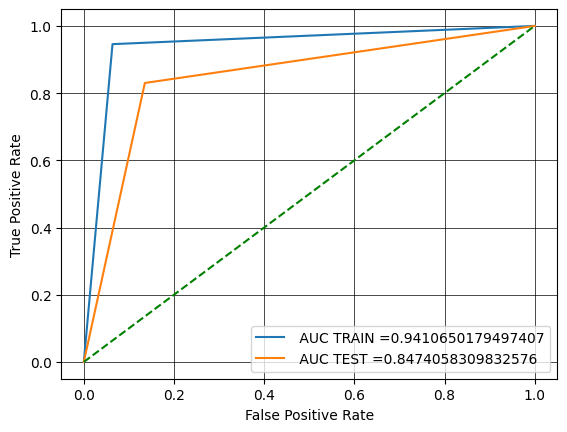

In [ ]:
from sklearn.metrics import roc_curve, auc
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_external_title, y_pred_external_title_train)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test_external_title, y_pred_external_title)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.savefig('roc_curve_BERT_external_title.png')

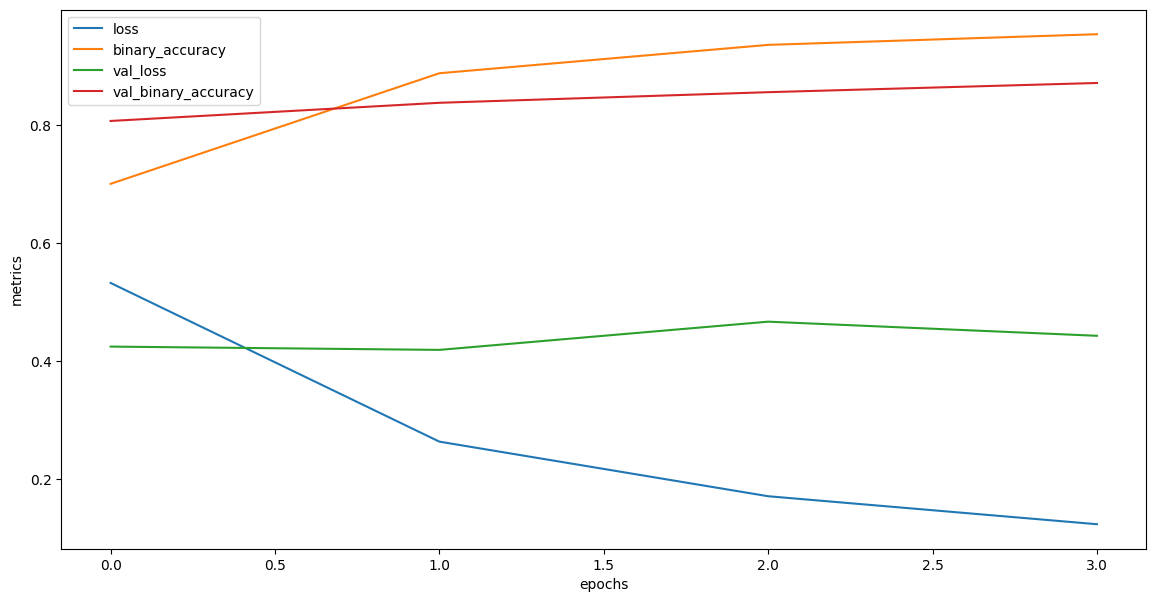

In [ ]:
pd.DataFrame(history_external_title.history).plot(
    figsize=(14, 7),
    xlabel='epochs',
    ylabel='metrics'
)
plt.savefig("training_metrics_BERT_external_title.png")

## SmallBERT - External - Description

In [ ]:
model_external_description = build_model()

steps_per_epoch_external_description = tf.data.experimental.cardinality(train_ds_external_description).numpy()
num_train_steps_external_description = steps_per_epoch_external_description * epochs
num_warmup_steps_external_description = int(0.1*num_train_steps_external_description)


optimizer_external_description = optimization.create_optimizer(
    init_lr=init_lr,
    num_train_steps=num_train_steps_external_description,
    num_warmup_steps=num_warmup_steps_external_description,
    optimizer_type='adamw'
)
model_external_description.compile(
    optimizer=optimizer_external_description,
    loss=loss,
    metrics=metrics
)

In [ ]:
history_external_description = model_external_description.fit(
    x=train_ds_external_description,
    validation_data=test_ds_external_description,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=2, restore_best_weights=True
        )
    ]
)

Epoch 1/5
314/314 [==============================] - 93s 272ms/step - loss: 0.4247 - binary_accuracy: 0.7929 - val_loss: 0.4453 - val_binary_accuracy: 0.8191
Epoch 2/5
314/314 [==============================] - 85s 271ms/step - loss: 0.1900 - binary_accuracy: 0.9274 - val_loss: 0.4390 - val_binary_accuracy: 0.8391
Epoch 3/5
314/314 [==============================] - 85s 270ms/step - loss: 0.1212 - binary_accuracy: 0.9574 - val_loss: 0.4817 - val_binary_accuracy: 0.8566
Epoch 4/5
314/314 [==============================] - 85s 269ms/step - loss: 0.0898 - binary_accuracy: 0.9700 - val_loss: 0.5612 - val_binary_accuracy: 0.8470


In [ ]:
examples = [
    sec_sample_issue["issue_title"],
    nonsec_sample_issue["issue_title"]    
]
a = model_external_description.predict(tf.constant(examples))
a = np.where(a > 0.0, 1, 0)
print(a)

1/1 [==============================] - 1s 659ms/step
[[1]
 [1]]


In [ ]:
y_pred_external_description = model_external_description.predict(test_ds_external_description)
y_pred_external_description = np.where(y_pred_external_description > 0.0, 1, 0)

print(classification_report(y_test_external_description, y_pred_external_description))

79/79 [==============================] - 16s 203ms/step
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1448
           1       0.85      0.77      0.81      1054

    accuracy                           0.85      2502
   macro avg       0.85      0.84      0.84      2502
weighted avg       0.85      0.85      0.85      2502



In [ ]:
y_pred_external_description_2 = model_external_description.predict(train_ds_promise)
y_pred_external_description_2 = np.where(y_pred_external_description_2 > 0.0, 1, 0)

print(classification_report(y_train_promise, y_pred_external_description_2))

41/41 [==============================] - 7s 171ms/step
              precision    recall  f1-score   support

           0       0.85      0.61      0.71       643
           1       0.70      0.89      0.78       643

    accuracy                           0.75      1286
   macro avg       0.77      0.75      0.74      1286
weighted avg       0.77      0.75      0.74      1286



In [ ]:
model_external_description.save('external_description_smallbert_L4_H512_A8', include_optimizer=False)

In [ ]:
y_pred_external_description_train = model_external_description.predict(train_ds_external_description)
y_pred_external_description_train = np.where(y_pred_external_description_train > 0.0, 1, 0)

314/314 [==============================] - 41s 129ms/step


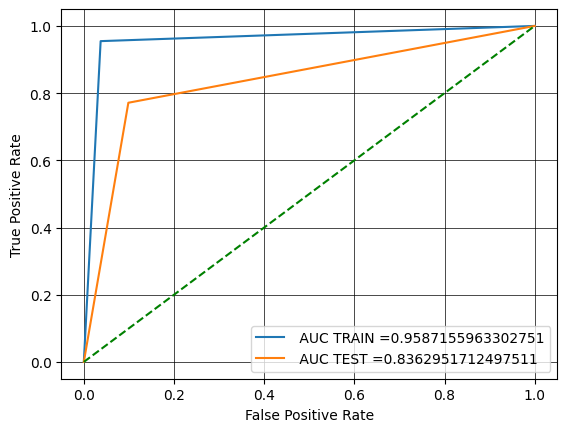

In [ ]:
from sklearn.metrics import roc_curve, auc
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_external_description, y_pred_external_description_train)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test_external_description, y_pred_external_description)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.savefig('roc_curve_BERT_external_description.png')

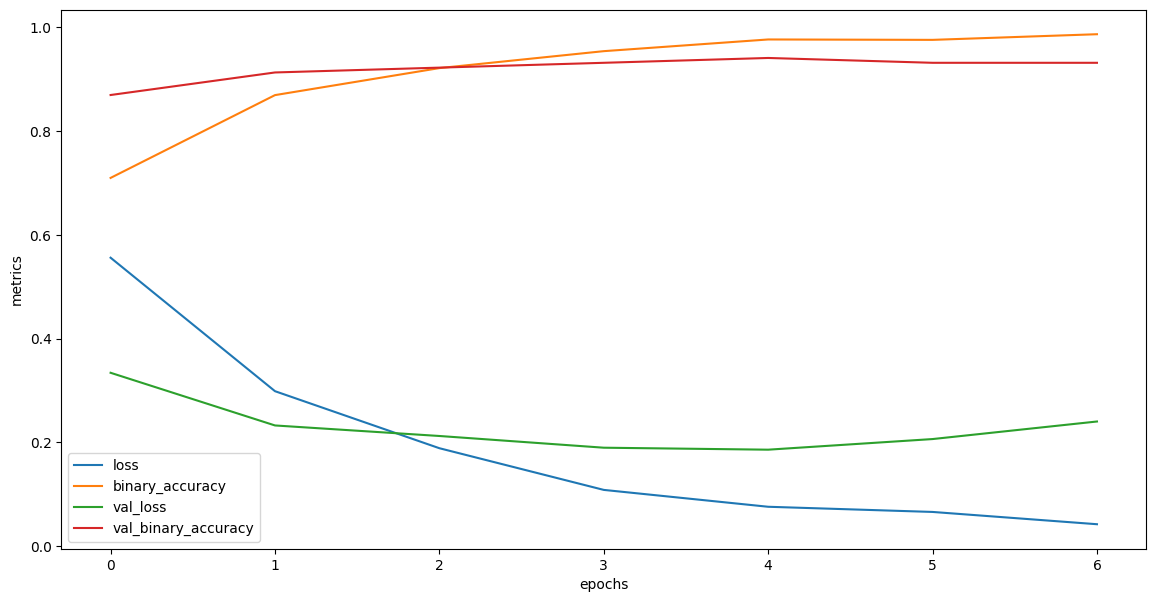

In [ ]:
pd.DataFrame(history_external_description.history).plot(
    figsize=(14, 7),
    xlabel='epochs',
    ylabel='metrics'
)
plt.savefig("training_metrics_BERT_external_description.png")

## SmallBERT - Non-External - Title

In [ ]:
model_title = build_model()

steps_per_epoch_title = tf.data.experimental.cardinality(train_ds_title).numpy()
num_train_steps_title = steps_per_epoch_title * epochs
num_warmup_steps_title = int(0.1*num_train_steps_title)


optimizer_title = optimization.create_optimizer(
    init_lr=init_lr,
    num_train_steps=num_train_steps_title,
    num_warmup_steps=num_warmup_steps_title,
    optimizer_type='adamw'
)
model_title.compile(
    optimizer=optimizer_title,
    loss=loss,
    metrics=metrics
)

In [ ]:
history_title = model_title.fit(
    x=train_ds_title,
    validation_data=test_ds_title,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=2, restore_best_weights=True
        )
    ]
)

Epoch 1/5
304/304 [==============================] - 85s 259ms/step - loss: 0.4706 - binary_accuracy: 0.7662 - val_loss: 0.4629 - val_binary_accuracy: 0.8245
Epoch 2/5
304/304 [==============================] - 74s 244ms/step - loss: 0.2628 - binary_accuracy: 0.8888 - val_loss: 0.2870 - val_binary_accuracy: 0.8999
Epoch 3/5
304/304 [==============================] - 77s 255ms/step - loss: 0.1809 - binary_accuracy: 0.9292 - val_loss: 0.2878 - val_binary_accuracy: 0.9106
Epoch 4/5
304/304 [==============================] - 76s 251ms/step - loss: 0.1351 - binary_accuracy: 0.9492 - val_loss: 0.3081 - val_binary_accuracy: 0.9098


In [ ]:
examples = [
    sec_sample_issue["issue_title"],
    nonsec_sample_issue["issue_title"]    
]
a = model_title.predict(tf.constant(examples))
a = np.where(a > 0.0, 1, 0)
print(a)

1/1 [==============================] - 1s 694ms/step
[[1]
 [0]]


In [ ]:
y_pred_title = model_title.predict(test_ds_title)
y_pred_title = np.where(y_pred_title > 0.0, 1, 0)

print(classification_report(y_test_title, y_pred_title))

76/76 [==============================] - 14s 189ms/step
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      1214
           1       0.93      0.92      0.93      1214

    accuracy                           0.93      2428
   macro avg       0.93      0.93      0.93      2428
weighted avg       0.93      0.93      0.93      2428



In [ ]:
y_pred_title_2 = model_title.predict(train_ds_promise)
y_pred_title_2 = np.where(y_pred_title_2 > 0.0, 1, 0)

print(classification_report(y_train_promise, y_pred_title_2))

41/41 [==============================] - 7s 179ms/step
              precision    recall  f1-score   support

           0       0.92      0.20      0.33       643
           1       0.55      0.98      0.71       643

    accuracy                           0.59      1286
   macro avg       0.74      0.59      0.52      1286
weighted avg       0.74      0.59      0.52      1286



In [ ]:
model_title.save('non_external_title_smallbert_L4_H512_A8', include_optimizer=False)

In [ ]:
y_pred_title_train = model_title.predict(train_ds_title)
y_pred_title_train = np.where(y_pred_title_train > 0.0, 1, 0)

304/304 [==============================] - 36s 119ms/step


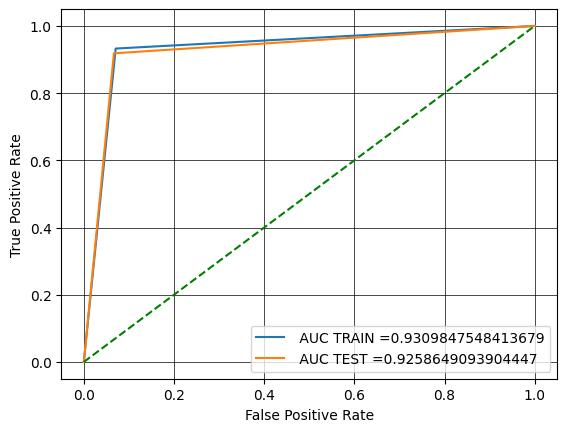

In [ ]:
from sklearn.metrics import roc_curve, auc
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_title, y_pred_title_train)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test_title, y_pred_title)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.savefig('roc_curve_BERT_title.png')

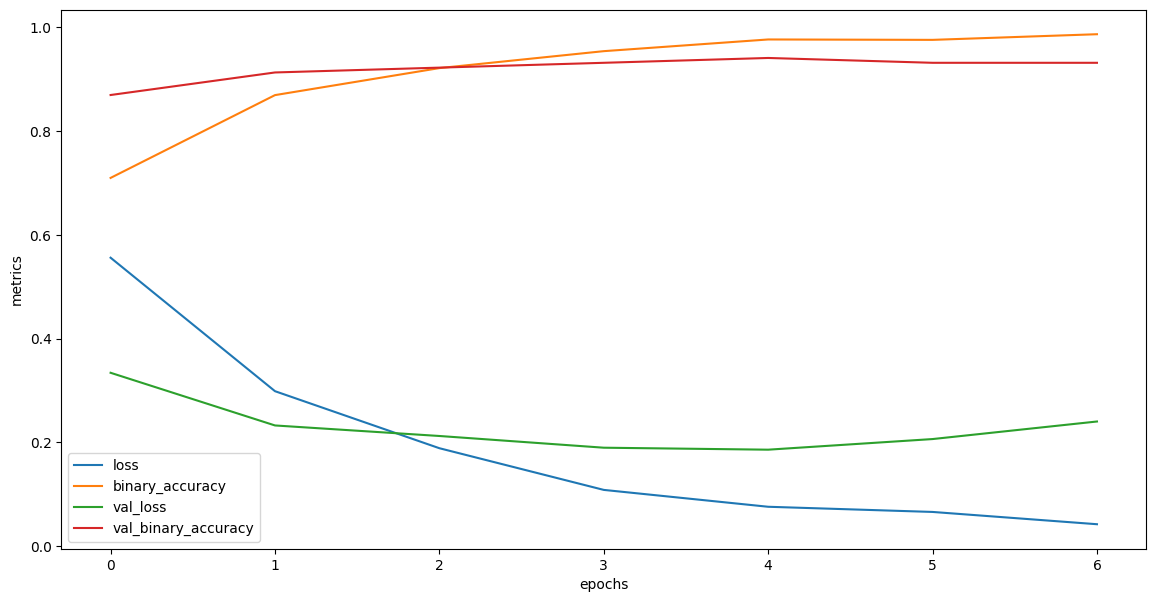

In [ ]:
pd.DataFrame(history_title.history).plot(
    figsize=(14, 7),
    xlabel='epochs',
    ylabel='metrics'
)
plt.savefig("training_metrics_BERT_title.png")

## SmallBERT - Non-External - Description

In [ ]:
model_description = build_model()

steps_per_epoch_description = tf.data.experimental.cardinality(train_ds_description).numpy()
num_train_steps_description = steps_per_epoch_description * epochs
num_warmup_steps_description = int(0.1*num_train_steps_description)


optimizer_description = optimization.create_optimizer(
    init_lr=init_lr,
    num_train_steps=num_train_steps_description,
    num_warmup_steps=num_warmup_steps_description,
    optimizer_type='adamw'
)
model_description.compile(
    optimizer=optimizer_description,
    loss=loss,
    metrics=metrics
)

In [ ]:
history_description = model_description.fit(
    x=train_ds_description,
    validation_data=test_ds_description,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=2, restore_best_weights=True
        )
    ]
)

Epoch 1/5
304/304 [==============================] - 115s 351ms/step - loss: 0.4189 - binary_accuracy: 0.8023 - val_loss: 0.3896 - val_binary_accuracy: 0.8583
Epoch 2/5
304/304 [==============================] - 110s 362ms/step - loss: 0.2159 - binary_accuracy: 0.9160 - val_loss: 0.2996 - val_binary_accuracy: 0.9016
Epoch 3/5
304/304 [==============================] - 119s 391ms/step - loss: 0.1475 - binary_accuracy: 0.9453 - val_loss: 0.2743 - val_binary_accuracy: 0.9152
Epoch 4/5
304/304 [==============================] - 108s 354ms/step - loss: 0.0999 - binary_accuracy: 0.9658 - val_loss: 0.3256 - val_binary_accuracy: 0.9110
Epoch 5/5
304/304 [==============================] - 85s 279ms/step - loss: 0.0804 - binary_accuracy: 0.9729 - val_loss: 0.3063 - val_binary_accuracy: 0.9152


In [ ]:
examples = [
    sec_sample_issue["issue_title"],
    nonsec_sample_issue["issue_title"]    
]
a = model_description.predict(tf.constant(examples))
a = np.where(a > 0.0, 1, 0)
print(a)

1/1 [==============================] - 1s 686ms/step
[[1]
 [0]]


In [ ]:
y_pred_description = model_description.predict(test_ds_description)
y_pred_description = np.where(y_pred_description > 0.0, 1, 0)

print(classification_report(y_test_description, y_pred_description))

76/76 [==============================] - 18s 233ms/step
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1214
           1       0.93      0.97      0.95      1214

    accuracy                           0.95      2428
   macro avg       0.95      0.95      0.95      2428
weighted avg       0.95      0.95      0.95      2428



In [ ]:
y_pred_description_2 = model_description.predict(train_ds_promise)
y_pred_description_2 = np.where(y_pred_description_2 > 0.0, 1, 0)

print(classification_report(y_train_promise, y_pred_description_2))

41/41 [==============================] - 6s 137ms/step
              precision    recall  f1-score   support

           0       0.92      0.49      0.64       643
           1       0.65      0.96      0.78       643

    accuracy                           0.73      1286
   macro avg       0.79      0.73      0.71      1286
weighted avg       0.79      0.73      0.71      1286



In [ ]:
model_description.save('non_external_description_smallbert_L4_H512_A8', include_optimizer=False)

In [ ]:
y_pred_description_train = model_description.predict(train_ds_description)
y_pred_description_train = np.where(y_pred_description_train > 0.0, 1, 0)

304/304 [==============================] - 58s 190ms/step


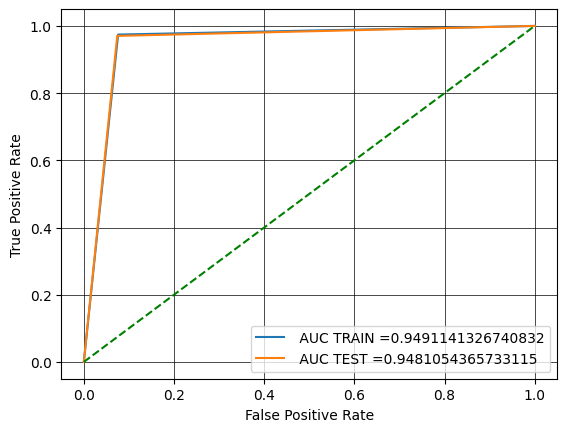

In [ ]:
from sklearn.metrics import roc_curve, auc
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_description, y_pred_description_train)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test_description, y_pred_description)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.savefig('roc_curve_BERT_description.png')

## SmallBERT - Combined

In [ ]:
model_combined = build_model()

steps_per_epoch_combined = tf.data.experimental.cardinality(train_ds_combined).numpy()
num_train_steps_combined = steps_per_epoch_combined * epochs
num_warmup_steps_combined = int(0.1*num_train_steps_combined)


optimizer_combined = optimization.create_optimizer(
    init_lr=init_lr,
    num_train_steps=num_train_steps_combined,
    num_warmup_steps=num_warmup_steps_combined,
    optimizer_type='adamw'
)
model_combined.compile(
    optimizer=optimizer_combined,
    loss=loss,
    metrics=metrics
)

In [ ]:
history_combined = model_combined.fit(
    x=train_ds_combined,
    validation_data=test_ds_combined,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=2, restore_best_weights=True
        )
    ]
)

Epoch 1/5
375/375 [==============================] - 101s 253ms/step - loss: 0.4966 - binary_accuracy: 0.7302 - val_loss: 0.3082 - val_binary_accuracy: 0.8632
Epoch 2/5
375/375 [==============================] - 94s 250ms/step - loss: 0.2708 - binary_accuracy: 0.8864 - val_loss: 0.2916 - val_binary_accuracy: 0.8852
Epoch 3/5
375/375 [==============================] - 94s 251ms/step - loss: 0.1924 - binary_accuracy: 0.9269 - val_loss: 0.2954 - val_binary_accuracy: 0.9002
Epoch 4/5
375/375 [==============================] - 93s 249ms/step - loss: 0.1443 - binary_accuracy: 0.9455 - val_loss: 0.3331 - val_binary_accuracy: 0.9035


In [ ]:
examples = [
    sec_sample_issue["issue_title"],
    nonsec_sample_issue["issue_title"]    
]
a = model_combined.predict(tf.constant(examples))
a = np.where(a > 0.0, 1, 0)
print(a)

1/1 [==============================] - 3s 3s/step
[[1]
 [1]]


In [ ]:
y_pred_combined = model_combined.predict(test_ds_combined)
y_pred_combined = np.where(y_pred_combined > 0.0, 1, 0)

print(classification_report(y_test_combined, y_pred_combined))

94/94 [==============================] - 11s 116ms/step
              precision    recall  f1-score   support

           0       0.86      0.93      0.90      1498
           1       0.92      0.85      0.89      1498

    accuracy                           0.89      2996
   macro avg       0.89      0.89      0.89      2996
weighted avg       0.89      0.89      0.89      2996



In [ ]:
y_pred_combined_2 = model_combined.predict(test_ds_title)
y_pred_combined_2 = np.where(y_pred_combined_2 > 0.0, 1, 0)

print(classification_report(y_test_title, y_pred_combined_2))

76/76 [==============================] - 7s 92ms/step
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      1214
           1       0.95      0.91      0.93      1214

    accuracy                           0.93      2428
   macro avg       0.93      0.93      0.93      2428
weighted avg       0.93      0.93      0.93      2428



In [ ]:
y_pred_combined_3 = model_combined.predict(test_ds_external_title)
y_pred_combined_3 = np.where(y_pred_combined_3 > 0.0, 1, 0)

print(classification_report(y_test_external_title, y_pred_combined_3))

79/79 [==============================] - 9s 120ms/step
              precision    recall  f1-score   support

           0       0.89      0.92      0.91      1449
           1       0.89      0.85      0.87      1055

    accuracy                           0.89      2504
   macro avg       0.89      0.88      0.89      2504
weighted avg       0.89      0.89      0.89      2504



In [ ]:
model_combined.save('combined_smallbert_L4_H512_A8', include_optimizer=False)

In [ ]:
y_pred_combined_train = model_combined.predict(train_ds_combined)
y_pred_combined_train = np.where(y_pred_combined_train > 0.0, 1, 0)

41/41 [==============================] - 5s 129ms/step


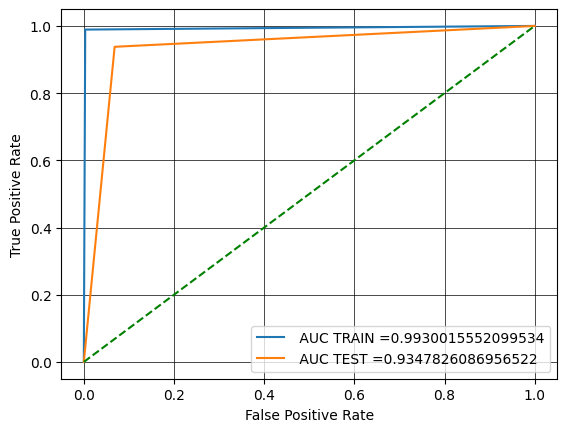

In [ ]:
from sklearn.metrics import roc_curve, auc
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_combined, y_pred_combined_train)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test_combined, y_pred_combined)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.savefig('roc_curve_BERT_combined.png')

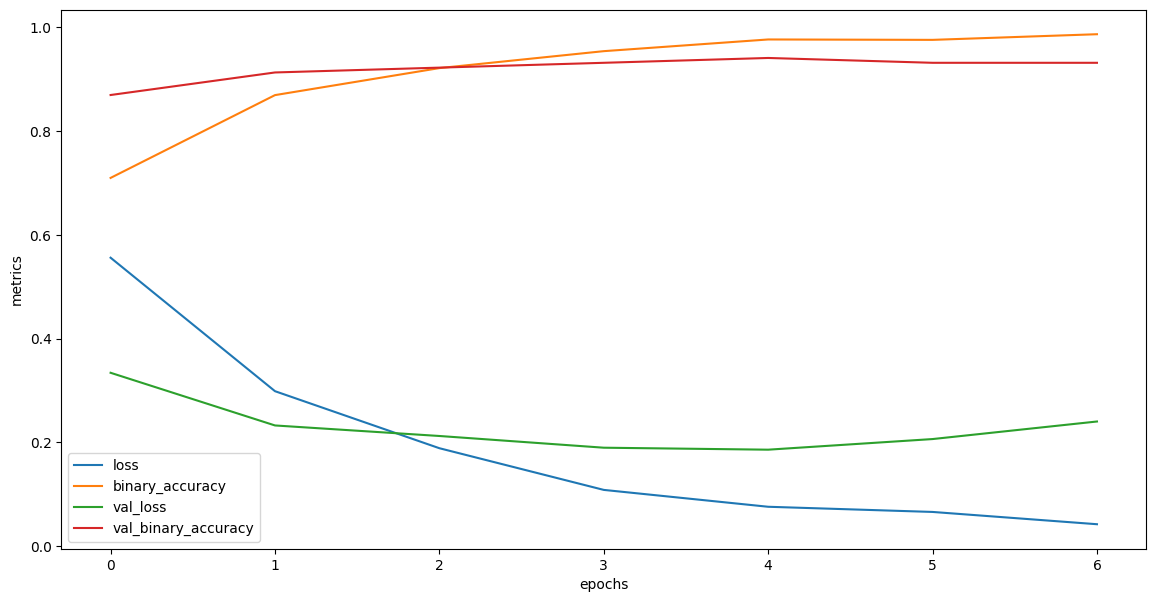

In [ ]:
pd.DataFrame(history_combined.history).plot(
    figsize=(14, 7),
    xlabel='epochs',
    ylabel='metrics'
)
plt.savefig("training_metrics_BERT_combined.png")

# Load models

In [90]:
import zipfile, os
os.mkdir('old_models')

In [91]:
non_external_description_url = 'https://www.dropbox.com/s/rguuhi5bz033ofb/non_external_description_smallbert_L4_H512_A8.zip?dl=1'
non_external_description_dir = './old_models/non_external_description_smallbert_L4_H512_A8.zip'
non_external_title_url = 'https://www.dropbox.com/s/n6hmferek8iizvf/non_external_title_smallbert_L4_H512_A8.zip?dl=1'
non_external_title_dir = './old_models/non_external_title_smallbert_L4_H512_A8.zip'
external_title_url = 'https://www.dropbox.com/s/92a4j6z83g90dov/external_title_smallbert_L4_H512_A8.zip?dl=1'
external_title_dir = './old_models/external_title_smallbert_L4_H512_A8.zip'
external_description_url = 'https://www.dropbox.com/s/7mdcleynn94c32l/external_description_smallbert_L4_H512_A8.zip?dl=1'
external_description_dir = './old_models/external_description_smallbert_L4_H512_A8.zip'
combined_url = 'https://www.dropbox.com/s/az9aldindjvbboy/combined_smallbert_L4_H512_A8.zip?dl=1'
combined_dir = './old_models/combined_smallbert_L4_H512_A8.zip'
promise_url = 'https://www.dropbox.com/s/7ubq7pv592ewu89/promise_smallbert_L4_H512_A8.zip?dl=1'
promise_dir = './old_models/promise_smallbert_L4_H512_A8.zip'
pure_url = 'https://www.dropbox.com/s/qr3qj6ks1k97910/pure_smallbert_L4_H512_A8.zip?dl=1'
pure_dir = './old_models/pure_smallbert_L4_H512_A8.zip'


def download_file_and_save(url, path):
    response = requests.get(url)
    with open(path, "wb+") as f:
        f.write(response.content)
        
def unzip_file(name):
  with zipfile.ZipFile(f"./old_models/{name}.zip", 'r') as zip_ref:
    zip_ref.extractall(f"./old_models/{name}")

In [92]:
download_file_and_save(non_external_description_url, non_external_description_dir)
download_file_and_save(non_external_title_url, non_external_title_dir)
download_file_and_save(external_title_url, external_title_dir)
download_file_and_save(external_description_url, external_description_dir)
download_file_and_save(combined_url, combined_dir)
download_file_and_save(promise_url, promise_dir)
download_file_and_save(pure_url, pure_dir)

In [93]:
unzip_file("non_external_description_smallbert_L4_H512_A8")
unzip_file("non_external_title_smallbert_L4_H512_A8")
unzip_file("external_title_smallbert_L4_H512_A8")
unzip_file("external_description_smallbert_L4_H512_A8")
unzip_file("combined_smallbert_L4_H512_A8")
unzip_file("promise_smallbert_L4_H512_A8")
unzip_file("pure_smallbert_L4_H512_A8")

In [94]:
non_external_description_smallbert_L4_H512_A8 = tf.keras.models.load_model("./old_models/non_external_description_smallbert_L4_H512_A8/content/non_external_description_smallbert_L4_H512_A8")
non_external_title_smallbert_L4_H512_A8 = tf.keras.models.load_model("./old_models/non_external_title_smallbert_L4_H512_A8/content/non_external_title_smallbert_L4_H512_A8")
external_title_smallbert_L4_H512_A8 = tf.keras.models.load_model("./old_models/external_title_smallbert_L4_H512_A8/content/external_title_smallbert_L4_H512_A8")
external_description_smallbert_L4_H512_A8 = tf.keras.models.load_model("./old_models/external_description_smallbert_L4_H512_A8/content/external_description_smallbert_L4_H512_A8")
combined_smallbert_L4_H512_A8 = tf.keras.models.load_model("./old_models/combined_smallbert_L4_H512_A8/content/combined_smallbert_L4_H512_A8")
promise_smallbert_L4_H512_A8 = tf.keras.models.load_model("./old_models/promise_smallbert_L4_H512_A8/content/promise_smallbert_L4_H512_A8")
pure_smallbert_L4_H512_A8 = tf.keras.models.load_model("./old_models/pure_smallbert_L4_H512_A8/content/pure_smallbert_L4_H512_A8")

In [95]:
y_test_title.shape

(2428,)

In [96]:
import time

start = time.time()
non_external_description_smallbert_L4_H512_A8.predict(test_ds_title)
print("non_external_description_smallbert:", round(time.time()-start, 2))

start = time.time()
non_external_title_smallbert_L4_H512_A8.predict(test_ds_title)
print("non_external_title_smallbert_L4_H512_A8:", round(time.time()-start, 2))

start = time.time()
external_title_smallbert_L4_H512_A8.predict(test_ds_title)
print("external_title_smallbert_L4_H512_A8:", round(time.time()-start, 2))

start = time.time()
external_description_smallbert_L4_H512_A8.predict(test_ds_title)
print("external_description_smallbert_L4_H512_A8:", round(time.time()-start, 2))

start = time.time()
combined_smallbert_L4_H512_A8.predict(test_ds_title)
print("combined_smallbert_L4_H512_A8:", round(time.time()-start, 2))

start = time.time()
promise_smallbert_L4_H512_A8.predict(test_ds_title)
print("promise_smallbert_L4_H512_A8:", round(time.time()-start, 2))

start = time.time()
pure_smallbert_L4_H512_A8.predict(test_ds_title)
print("pure_smallbert_L4_H512_A8:", round(time.time()-start, 2))


76/76 [==============================] - 13s 127ms/step
non_external_description_smallbert: 13.32
76/76 [==============================] - 7s 91ms/step
non_external_title_smallbert_L4_H512_A8: 10.62
76/76 [==============================] - 9s 114ms/step
external_title_smallbert_L4_H512_A8: 9.3
76/76 [==============================] - 8s 96ms/step
external_description_smallbert_L4_H512_A8: 7.67
76/76 [==============================] - 12s 157ms/step
combined_smallbert_L4_H512_A8: 12.59
76/76 [==============================] - 12s 149ms/step
promise_smallbert_L4_H512_A8: 21.18
76/76 [==============================] - 9s 117ms/step
pure_smallbert_L4_H512_A8: 10.62


In [97]:
# non_external_description_smallbert_L4_H512_A8
y_pred_non_external_description_smallbert_L4_H512_A8 = non_external_description_smallbert_L4_H512_A8.predict(test_ds_description)
y_pred_non_external_description_smallbert_L4_H512_A8 = np.where(y_pred_non_external_description_smallbert_L4_H512_A8 > 0.0, 1, 0)

# non_external_title_smallbert_L4_H512_A8
y_pred_non_external_title_smallbert_L4_H512_A8 = non_external_title_smallbert_L4_H512_A8.predict(test_ds_title)
y_pred_non_external_title_smallbert_L4_H512_A8 = np.where(y_pred_non_external_title_smallbert_L4_H512_A8 > 0.0, 1, 0)

# external_title_smallbert_L4_H512_A8
y_pred_external_title_smallbert_L4_H512_A8 = external_title_smallbert_L4_H512_A8.predict(test_ds_external_title)
y_pred_external_title_smallbert_L4_H512_A8 = np.where(y_pred_external_title_smallbert_L4_H512_A8 > 0.0, 1, 0)

# external_description_smallbert_L4_H512_A8
y_pred_external_description_smallbert_L4_H512_A8 = external_description_smallbert_L4_H512_A8.predict(test_ds_external_description)
y_pred_external_description_smallbert_L4_H512_A8 = np.where(y_pred_external_description_smallbert_L4_H512_A8 > 0.0, 1, 0)

# combined_smallbert_L4_H512_A8
y_pred_combined_smallbert_L4_H512_A8 = combined_smallbert_L4_H512_A8.predict(test_ds_combined)
y_pred_combined_smallbert_L4_H512_A8 = np.where(y_pred_combined_smallbert_L4_H512_A8 > 0.0, 1, 0)

# promise_smallbert_L4_H512_A8
y_pred_promise_smallbert_L4_H512_A8 = promise_smallbert_L4_H512_A8.predict(test_ds_promise)
y_pred_promise_smallbert_L4_H512_A8 = np.where(y_pred_promise_smallbert_L4_H512_A8 > 0.0, 1, 0)

# pure_smallbert_L4_H512_A8
y_pred_pure_smallbert_L4_H512_A8 = pure_smallbert_L4_H512_A8.predict(test_ds_pure)
y_pred_pure_smallbert_L4_H512_A8 = np.where(y_pred_pure_smallbert_L4_H512_A8 > 0.0, 1, 0)



8/8 [==============================] - 1s 88ms/step


In [98]:
y_test_pure.shape

(247,)

In [109]:
def get_csv(test_dataset, predicted_labels_old, filename):
  issues = np.empty((0))
  original_labels = np.empty((0))
  for issue, label in test_dataset:
    original_labels = np.concatenate([original_labels, label.numpy()])
    issues = np.concatenate([issues, issue.numpy()])
  original_labels = original_labels.astype(int)
  issues = issues.astype(str)

  predicted_labels = np.empty((0))
  for i in predicted_labels_old:
    predicted_labels = np.concatenate([predicted_labels, i])
  predicted_labels = predicted_labels.astype(int)
  print({'Text': len(issues), 'Predicted': len(predicted_labels), 'Original': len(original_labels)})

  df = pd.DataFrame({'Text': issues, 'Predicted': predicted_labels, 'Original': original_labels})
  df.to_csv(filename, encoding='utf-8', index=False)
  return df

In [100]:
os.mkdir("predicted")

In [110]:
get_csv(test_ds_description, y_pred_non_external_description_smallbert_L4_H512_A8, "predicted/non_external_description_smallbert_L4_H512_A8.csv")
get_csv(test_ds_title, y_pred_non_external_title_smallbert_L4_H512_A8, "predicted/non_external_title_smallbert_L4_H512_A8.csv")
get_csv(test_ds_external_title, y_pred_external_title_smallbert_L4_H512_A8, "predicted/external_title_smallbert_L4_H512_A8.csv")
get_csv(test_ds_external_description, y_pred_external_description_smallbert_L4_H512_A8, "predicted/external_description_smallbert_L4_H512_A8.csv")
get_csv(test_ds_combined, y_pred_combined_smallbert_L4_H512_A8, "predicted/combined_smallbert_L4_H512_A8.csv")
get_csv(test_ds_promise, y_pred_promise_smallbert_L4_H512_A8, "predicted/promise_smallbert_L4_H512_A8.csv")
get_csv(test_ds_pure, y_pred_pure_smallbert_L4_H512_A8, "predicted/pure_smallbert_L4_H512_A8.csv")

{'Text': 2428, 'Predicted': 2428, 'Original': 2428}
{'Text': 2428, 'Predicted': 2428, 'Original': 2428}
{'Text': 2502, 'Predicted': 2502, 'Original': 2502}
{'Text': 2502, 'Predicted': 2502, 'Original': 2502}
{'Text': 740, 'Predicted': 740, 'Original': 740}
{'Text': 322, 'Predicted': 322, 'Original': 322}


,Text,Predicted,Original
0,the principle of least privilege exists users ...,1,1
1,the systems must conform to the microsoft acce...,0,0
2,the state terminated shall be used to permanen...,0,0
3,primary actor selects the question to edit,0,0
4,deserialization of untrusted data is avoided o...,1,1
...,...,...,...
317,changes to revenue and expense formulae must b...,0,0
318,primary actor indicates he she wishes to edit ...,0,0
319,the system shall be able to display report of ...,0,0
320,the card should use unique diversified secret ...,1,1


# SecReq V2

In [86]:
import re
import torch.nn as nn
from transformers import DistilBertModel, BertModel
import os
import time
import torch
# import requests
import numpy as np
import pandas as pd
# from tqdm import tqdm
# import streamlit as st
from copy import deepcopy
# import torch.nn.functional as F
from transformers import DistilBertTokenizer, BertTokenizer
from torch.utils.data import TensorDataset, Dataset, DataLoader, SequentialSampler

class BertClassifier(nn.Module):

    def __init__(self, model_name, freeze_bert=False):
        super(BertClassifier, self).__init__()

        if model_name == 'distilbert-base-uncased':
            self.bert = DistilBertModel.from_pretrained(model_name)
            self.classifier = nn.Sequential(nn.Linear(768, 50), nn.ELU(), nn.Linear(50, 2))

        elif model_name == 'distilbert-base-uncased-ver2':
            self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
            self.classifier = nn.Sequential(nn.Linear(768, 50), nn.ELU(),
                                            nn.Dropout(0.1), nn.Linear(50, 2))

        else:
            self.bert = BertModel.from_pretrained(model_name)
            self.classifier = nn.Sequential(nn.Linear(768, 50), nn.Softplus(),
                                            nn.Dropout(0.1), nn.Linear(50, 1),
                                            nn.Sigmoid())
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids,
                        attention_mask=attention_mask)
        last_hidden_state_cls = outputs[0][:, 0, :]
        logits = self.classifier(last_hidden_state_cls)
        return logits

In [87]:
MODEL_FOLDER = "./models"
MODEL_TYPE_T5 = "t5"
MODEL_FILENAME = f"{MODEL_TYPE_T5}"
MODEL_PATH_T5 = os.path.join(MODEL_FOLDER, MODEL_FILENAME)

# SecReq desrepancies
PT_T5_URL = "https://www.dropbox.com/s/dc05grxthra0hth/pytorch_model.bin?dl=1"
CONFIG_T5_URL = "https://www.dropbox.com/s/ubcq8m53959lq0e/config.json?dl=1"
PT_BERT_URL = "https://www.dropbox.com/s/fie0w0rfn7kd8j6/best_model_state.pth?dl=1"
BERT_REQS = "https://www.dropbox.com/s/la6l54nbzl6bcw8/best_model_state_bert.bin?dl=1"
DISTILBERT_REQS = "https://www.dropbox.com/s/fnciqukud9nkja4/distilbert_model.bin?dl=1"

PT_T5_PATH = os.path.join(MODEL_PATH_T5, "pytorch_model.bin")
CONFIG_T5_PATH = os.path.join(MODEL_PATH_T5, "config.json")
BERT_PATH = os.path.join(MODEL_FOLDER, "best_model_state.pth")
BERT_PATH_2 = os.path.join(MODEL_FOLDER, "best_model_state_bert.bin")
DISTILBERT_PATH = os.path.join(MODEL_FOLDER, "distilbert_model.bin")


In [92]:
def download_model():
    if not os.path.exists(MODEL_FOLDER):
        os.mkdir(MODEL_FOLDER)
    if os.path.exists(MODEL_PATH_T5):
        return
    os.mkdir(MODEL_PATH_T5)
    download_file_and_save(CONFIG_T5_URL, CONFIG_T5_PATH)        
    download_file_and_save(PT_T5_URL, PT_T5_PATH) 
    download_file_and_save(PT_BERT_URL, BERT_PATH)
    download_file_and_save(BERT_REQS, BERT_PATH_2)
    download_file_and_save(DISTILBERT_REQS, DISTILBERT_PATH)  

def download_file_and_save(url, path):
    response = requests.get(url)
    with open(path, "wb+") as f:
        f.write(response.content)

# Functions section

def preprocessing_for_bert(tokenizer, data, MAX_LEN=200):
    input_ids = []
    attention_masks = []
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  
            add_special_tokens=True,       
            max_length=MAX_LEN,                  
            pad_to_max_length=True,                   
            return_attention_mask=True,
            truncation = True)
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    return input_ids, attention_masks

def text_preprocessing(text):
    text = re.sub(r'(@.*?)[\s]', ' ', text)
    text = re.sub(r'&amp;', '&', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text
  
def bert_step(model, tokenizer, dataset, MAX_LEN, type):
    batch_size = 4
    inputs, masks = preprocessing_for_bert(tokenizer, dataset, MAX_LEN=MAX_LEN)
    data = TensorDataset(inputs, masks)
    sampler = SequentialSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)
    results = bert_predict(model, dataloader, type)
    sents = dataset.loc[dataset.index[np.where(results.flatten() == 1.0)]]
    del dataset
    return sents

def bert_predict(bert, dataloader, type = 'bert'):
    results = []
    bert.eval()
    bert.to(device)
    if type == 'bert':
        for batch in dataloader:
            b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)
            with torch.no_grad():
                logits = bert(b_input_ids, b_attn_mask)
            results.append(np.round(logits.cpu().numpy()))
    else:
        for batch in dataloader:
            b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)
            with torch.no_grad():
                logits = bert(b_input_ids, b_attn_mask)
            results.append(torch.argmax(logits, dim=1).cpu().numpy())

    return np.concatenate(results, axis=0)


In [94]:
if os.path.exists('./models') is False:
    download_model()

time.sleep(5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name_1 = 'bert-base-uncased'
model_name_2 = 'distilbert-base-uncased-ver2'

# BERT Initialization Section
model_bert = BertClassifier(model_name = model_name_1)
# model_bert.load_state_dict(deepcopy(torch.load("models/bert_model.bin", device)))
model_bert.load_state_dict(deepcopy(torch.load("models/best_model_state_bert.bin", device)))
model_bert = model_bert.to(device)
tokenizer_bert = BertTokenizer.from_pretrained(model_name_1, 
                                               do_lower_case=True)

# distilBERT Initialzation Section
model_distilbert = BertClassifier(model_name = model_name_2)
model_distilbert.load_state_dict(deepcopy(torch.load("models/distilbert_model.bin", device)))
model_distilbert = model_distilbert.to(device)
tokenizer_distilbert = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', 
                                                           do_lower_case=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## SecReq V2 - PROMISE

In [ ]:
def get_labels(initial_dataset, sec_dataset):
  pred_labels = []
  for i in initial_dataset:
    if i in sec_dataset:
      pred_labels.append(1)
    else:
      pred_labels.append(0)
  return pred_labels

In [149]:
# PROMISE
requirements_promise = list(df_promise['Text_clean'])
requirements_promise = pd.DataFrame(requirements_promise, columns=["Text"])

start = time.time()
sents_req_promise = bert_step(model_bert, tokenizer_bert, 
                      requirements_promise['Text'], 300, 'bert')
print("Time after 1 step:", time.time()-start)
middle = time.time()
sents_sec_promise = bert_step(model_distilbert, tokenizer_distilbert, 
                      sents_req_promise, 200, 'distilbert') 
print("Time after 2 step:", time.time()-middle)   

print("\nInitial dataset:", len(requirements_promise))
print("Requirements:", len(list(sents_req_promise)))
print("Security requirements:", len(list(sents_sec_promise)))

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Time after 1 step: 34.71753406524658
Time after 2 step: 8.958099603652954

Initial dataset: 1608
Requirements: 1218
Security requirements: 553


In [150]:
y_pred_promise = get_labels(list(df_promise['Text_clean']), list(sents_sec_promise))

In [151]:
print(classification_report(y_pred_promise, df_promise['Label']))

              precision    recall  f1-score   support

           0       0.93      0.71      0.81      1055
           1       0.62      0.90      0.74       553

    accuracy                           0.78      1608
   macro avg       0.78      0.81      0.77      1608
weighted avg       0.83      0.78      0.78      1608



In [108]:
# PROMISE 2 - only second step
requirements_promise = df_promise['Text_clean']

middle = time.time()
sents_sec_promise_2 = bert_step(model_distilbert, tokenizer_distilbert, 
                      requirements_promise, 200, 'distilbert') 
print("Time after 2 step:", time.time()-middle)   

print("\nInitial dataset:", len(list(requirements_promise)))
print("Security requirements:", len(list(sents_sec_promise_2)))

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Time after 2 step: 14.260494947433472

Initial dataset: 1608
Security requirements: 660


In [144]:
y_pred_promise_2 = get_labels(list(df_promise['Text_clean']), list(sents_sec_promise_2))

In [148]:
print(classification_report(y_pred_promise_2, df_promise['Label']))

              precision    recall  f1-score   support

           0       0.91      0.78      0.84       948
           1       0.74      0.90      0.81       660

    accuracy                           0.82      1608
   macro avg       0.82      0.84      0.82      1608
weighted avg       0.84      0.82      0.83      1608



## SecReq V2 - GitHub titles

In [141]:
# GitHub titles
requirements_titles = list(df_norm['issue_title_clean'])
requirements_titles = pd.DataFrame(requirements_titles, columns=["Text"])

start = time.time()
sents_req_titles = bert_step(model_bert, tokenizer_bert, 
                      requirements_titles['Text'], 300, 'bert')
print("Time after 1 step:", time.time()-start)
middle = time.time()
sents_sec_titles = bert_step(model_distilbert, tokenizer_distilbert, 
                      sents_req_titles, 200, 'distilbert') 
print("Time after 2 step:", time.time()-middle)   

print("\nInitial dataset:", len(requirements_titles))
print("Requirements:", len(list(sents_req_titles)))
print("Security requirements:", len(list(sents_sec_titles)))

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Time after 1 step: 257.5388853549957
Time after 2 step: 55.00076723098755

Initial dataset: 12136
Requirements: 7421
Security requirements: 1357


In [142]:
y_pred_title = get_labels(list(df_norm['issue_title_clean']), list(sents_sec_titles))

In [143]:
print(classification_report(y_pred_title, df_norm['label']))

              precision    recall  f1-score   support

           0       0.99      0.56      0.71     10779
           1       0.21      0.95      0.35      1357

    accuracy                           0.60     12136
   macro avg       0.60      0.75      0.53     12136
weighted avg       0.90      0.60      0.67     12136



In [111]:
# GitHub titles 2
requirements_titles = df_norm['issue_title_clean']

middle = time.time()
sents_sec_titles_2 = bert_step(model_distilbert, tokenizer_distilbert, 
                      requirements_titles, 200, 'distilbert') 
print("Time after 2 step:", time.time()-middle)   

print("\nInitial dataset:", len(list(requirements_titles)))
print("Security requirements:", len(list(sents_sec_titles_2)))

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Time after 2 step: 100.2830708026886

Initial dataset: 12136
Security requirements: 1861


In [136]:
y_pred_title_2 = get_labels(list(df_norm['issue_title_clean']), list(sents_sec_titles_2))

In [137]:
print(classification_report(y_pred_title_2, df_norm['label']))

              precision    recall  f1-score   support

           0       0.98      0.58      0.73     10275
           1       0.29      0.94      0.44      1861

    accuracy                           0.64     12136
   macro avg       0.64      0.76      0.59     12136
weighted avg       0.88      0.64      0.69     12136



## SecReq V2 - GitHub titles short

In [110]:
# GitHub titles short
requirements_titles_short = list(X_test_title)
requirements_titles_short = pd.DataFrame(requirements_titles_short, columns=["Text"])

start = time.time()
sents_req_titles_short = bert_step(model_bert, tokenizer_bert, 
                      requirements_titles_short['Text'], 300, 'bert')
print("Time after 1 step:", time.time()-start)
middle = time.time()
sents_sec_titles_short = bert_step(model_distilbert, tokenizer_distilbert, 
                      sents_req_titles_short, 200, 'distilbert') 
print("Time after 2 step:", time.time()-middle)   

print("\nInitial dataset:", len(requirements_titles_short))
print("Requirements:", len(list(sents_req_titles_short)))
print("Security requirements:", len(list(sents_sec_titles_short)))

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Time after 1 step: 51.62901592254639
Time after 2 step: 11.45711612701416

Initial dataset: 2428
Requirements: 1420
Security requirements: 262


In [134]:
y_pred_titles_short = get_labels(list(X_test_title), list(sents_sec_titles_short))

In [135]:
print(classification_report(y_pred_titles_short, y_test_title))

              precision    recall  f1-score   support

           0       0.99      0.56      0.71      2166
           1       0.21      0.96      0.34       262

    accuracy                           0.60      2428
   macro avg       0.60      0.76      0.53      2428
weighted avg       0.91      0.60      0.67      2428



In [113]:
# GitHub titles short 2
requirements_titles_short = X_test_title

middle = time.time()
sents_sec_titles_short_2 = bert_step(model_distilbert, tokenizer_distilbert, 
                      requirements_titles_short, 200, 'distilbert') 
print("Time after 2 step:", time.time()-middle)   

print("\nInitial dataset:", len(list(requirements_titles_short)))
print("Security requirements:", len(list(sents_sec_titles_short_2)))

Time after 2 step: 20.648037672042847

Initial dataset: 2428
Security requirements: 376


In [132]:
y_pred_titles_short_2 = get_labels(list(X_test_title), list(sents_sec_titles_short_2))

In [133]:
print(classification_report(y_pred_titles_short_2, y_test_title))

              precision    recall  f1-score   support

           0       0.99      0.58      0.73      2052
           1       0.30      0.96      0.45       376

    accuracy                           0.64      2428
   macro avg       0.64      0.77      0.59      2428
weighted avg       0.88      0.64      0.69      2428



## SecReq V2 - GitHub descriptions

In [112]:
# GitHub descriptions
requirements_descriptions = list(X_test_description)
requirements_descriptions = pd.DataFrame(requirements_descriptions, columns=["Text"])

start = time.time()
sents_req_descriptions = bert_step(model_bert, tokenizer_bert, 
                      requirements_descriptions['Text'], 300, 'bert')
print("Time after 1 step:", time.time()-start)
middle = time.time()
sents_sec_descriptions = bert_step(model_distilbert, tokenizer_distilbert, 
                      sents_req_descriptions, 200, 'distilbert') 
print("Time after 2 step:", time.time()-middle)   

print("\nInitial dataset:", len(requirements_descriptions))
print("Requirements:", len(list(sents_req_descriptions)))
print("Security requirements:", len(list(sents_sec_descriptions)))

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Time after 1 step: 69.4350278377533
Time after 2 step: 36.4695520401001

Initial dataset: 2428
Requirements: 2071
Security requirements: 361


In [130]:
y_pred_description = get_labels(list(X_test_description), list(sents_sec_descriptions))

In [131]:
print(classification_report(y_pred_description, y_test_description))

              precision    recall  f1-score   support

           0       0.99      0.58      0.73      2067
           1       0.29      0.98      0.45       361

    accuracy                           0.64      2428
   macro avg       0.64      0.78      0.59      2428
weighted avg       0.89      0.64      0.69      2428



In [114]:
# GitHub descriptions 2
requirements_descriptions = X_test_description

middle = time.time()
sents_sec_descriptions_2 = bert_step(model_distilbert, tokenizer_distilbert, 
                      requirements_descriptions, 200, 'distilbert') 
print("Time after 2 step:", time.time()-middle)   

print("\nInitial dataset:", len(list(requirements_descriptions)))
print("Security requirements:", len(list(sents_sec_descriptions_2)))

Time after 2 step: 33.935452938079834

Initial dataset: 2428
Security requirements: 382


In [125]:
y_pred_description_2 = get_labels(list(X_test_description), list(sents_sec_descriptions_2))

In [127]:
print(classification_report(y_pred_description_2, y_test_description))

              precision    recall  f1-score   support

           0       0.99      0.59      0.74      2046
           1       0.31      0.98      0.47       382

    accuracy                           0.65      2428
   macro avg       0.65      0.78      0.60      2428
weighted avg       0.88      0.65      0.70      2428



## SecReq V2 - PURE

In [115]:
# PURE
requirements_pure = list(df_pure['Text_clean'])
requirements_pure = pd.DataFrame(requirements_pure, columns=["Text"])

start = time.time()
sents_req_pure = bert_step(model_bert, tokenizer_bert, 
                      requirements_pure['Text'], 300, 'bert')
print("Time after 1 step:", time.time()-start)
middle = time.time()
sents_sec_pure = bert_step(model_distilbert, tokenizer_distilbert, 
                      sents_req_pure, 200, 'distilbert') 
print("Time after 2 step:", time.time()-middle)   

print("\nInitial dataset:", len(requirements_pure))
print("Requirements:", len(list(sents_req_pure)))
print("Security requirements:", len(list(sents_sec_pure)))

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Time after 1 step: 25.43451690673828
Time after 2 step: 7.7221291065216064

Initial dataset: 1232
Requirements: 953
Security requirements: 520


In [123]:
y_pred_pure = get_labels(list(df_pure['Text_clean']), list(sents_sec_pure))

In [128]:
print(classification_report(y_pred_pure, df_pure['Label']))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92       712
           1       0.84      0.99      0.91       520

    accuracy                           0.92      1232
   macro avg       0.92      0.93      0.92      1232
weighted avg       0.93      0.92      0.92      1232



In [116]:
# PURE 2
requirements_pure = df_pure['Text_clean']

middle = time.time()
sents_sec_pure_2 = bert_step(model_distilbert, tokenizer_distilbert, 
                      requirements_pure, 200, 'distilbert') 
print("Time after 2 step:", time.time()-middle)   

print("\nInitial dataset:", len(list(requirements_pure)))
print("Security requirements:", len(list(sents_sec_pure_2)))

Time after 2 step: 9.889799118041992

Initial dataset: 1232
Security requirements: 611


In [121]:
y_pred_pure_2 = get_labels(list(df_pure['Text_clean']), list(sents_sec_pure_2))

In [129]:
print(classification_report(y_pred_pure_2, df_pure['Label']))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       621
           1       0.98      0.99      0.99       611

    accuracy                           0.99      1232
   macro avg       0.99      0.99      0.99      1232
weighted avg       0.99      0.99      0.99      1232

